In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime
from scipy.optimize import curve_fit
from scipy import stats

### 123 kgN fertilizer experiment

In [2]:
fert_amount = "123"
case_clarion = "clarion" + fert_amount + "kgN"
case_webster = "webster" + fert_amount + "kgN"
#path_clarion = "/glade/derecho/scratch/jinmuluo/archive/" + case_clarion + "/lnd/hist/" 
#path_webster = "/glade/derecho/scratch/jinmuluo/archive/" + case_webster + "/lnd/hist/" 
path_clarion = "/glade/derecho/scratch/jinmuluo/archive/clarion123kgN05gC/lnd/hist/" 
path_webster = "/glade/derecho/scratch/jinmuluo/archive/webster123kgN05gC/lnd/hist/" 
path_default = "/glade/derecho/scratch/jinmuluo/archive/DefaultCLMatMESOCOSM123kgN/lnd/hist/" 

start_date = date(2022, 1, 1)
end_date = date(2023, 12, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'TOTSOMC_1m', 'TOTSOMN_1m',
          'RAIN', 'QDRAI', 'QOVER', 'QOUT120cm', 'H2OSOI', 'SOILLIQ', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'SMINN_TO_PLANT_FUN', 
          'F_NIT', 'F_NIT_vr', 'F_DENIT', 'F_DENIT_vr', 'GROSS_NMIN', 'GROSS_NMIN_vr', 'ACTUAL_IMMOB_NH4', 'ACTUAL_IMMOB_NO3',
         'LEAFN', 'LIVESTEMN', 'FROOTN', 'LIVECROOTN', 'GRAINN', 'CROPPROD1N',
         'WFPS', 'n2_n2o_ratio_denit', 'ratio_nox_n2o', 'anaerobic_frac', 'fd_WFPS']

CLM_Clarion = []
CLM_Webster = []
CLM_Default = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Default.append(path_default + "DefaultCLMatMESOCOSM" + ".clm2." + "h1" + "." + currdate + "-00000.nc" )


def cal_rmse(x1, x2):
    rmse = np.sqrt(np.mean((x1 - x2)**2))
    return rmse

In [3]:
def preprocess(ds, fields= NInput + GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)
dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)
dsCLM_Default = xr.open_mfdataset(CLM_Default, decode_times=True, preprocess=preprocess)

x = np.zeros(len(dsCLM_Clarion['levsoi']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levsoi'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levsoi'][i].values - dsCLM_Clarion['levsoi'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth=(dsCLM_Clarion['levsoi'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth=(dsCLM_Webster['levsoi'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth=(dsCLM_Default['levsoi'].coords, x))

x = np.zeros(len(dsCLM_Clarion['levdcmp']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levdcmp'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levdcmp'][i].values - dsCLM_Clarion['levdcmp'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth2=(dsCLM_Clarion['levdcmp'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth2=(dsCLM_Webster['levdcmp'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth2=(dsCLM_Default['levdcmp'].coords, x))

In [4]:
# Read the mesocsom measurements
p2 = "/glade/work/jinmuluo/MESONET/measurements/2023data/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022_2023.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'soil_gas_fluxes_combined_2022_2023_control.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

mean_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_cla_2023 = mean_dsNO_cla.loc[mean_dsNO_cla.index > "2023-01-01"]
mean_dsNO_cla_2022 = mean_dsNO_cla.loc[mean_dsNO_cla.index < "2023-01-01"]
std_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_cla_2023 = std_dsNO_cla.loc[std_dsNO_cla.index > "2023-01-01"]
std_dsNO_cla_2022 = std_dsNO_cla.loc[std_dsNO_cla.index < "2023-01-01"]
min_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_cla_2023 = min_dsNO_cla.loc[min_dsNO_cla.index > "2023-01-01"]
min_dsNO_cla_2022 = min_dsNO_cla.loc[min_dsNO_cla.index < "2023-01-01"]
max_dsNO_cla = dsNO.loc[('Clarion', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_cla_2023 = max_dsNO_cla.loc[max_dsNO_cla.index > "2023-01-01"]
max_dsNO_cla_2022 = max_dsNO_cla.loc[max_dsNO_cla.index < "2023-01-01"]
mean_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_web_2023 = mean_dsNO_web.loc[mean_dsNO_web.index > "2023-01-01"]
mean_dsNO_web_2022 = mean_dsNO_web.loc[mean_dsNO_web.index < "2023-01-01"]
std_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_web_2023 = std_dsNO_web.loc[std_dsNO_web.index > "2023-01-01"]
std_dsNO_web_2022 = std_dsNO_web.loc[std_dsNO_web.index < "2023-01-01"]
min_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_web_2023 = min_dsNO_web.loc[min_dsNO_web.index > "2023-01-01"]
min_dsNO_web_2022 = min_dsNO_web.loc[min_dsNO_web.index < "2023-01-01"]
max_dsNO_web = dsNO.loc[('Webster', 123), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_web_2023 = max_dsNO_web.loc[max_dsNO_web.index > "2023-01-01"]
max_dsNO_web_2022 = max_dsNO_web.loc[max_dsNO_web.index < "2023-01-01"]
mean_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_cla_2023 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index > "2023-01-01"]
mean_dsN2O_cla_2022 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index < "2023-01-01"]
std_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_cla_2023 = std_dsN2O_cla.loc[std_dsN2O_cla.index > "2023-01-01"]
std_dsN2O_cla_2022 = std_dsN2O_cla.loc[std_dsN2O_cla.index < "2023-01-01"]
min_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_cla_2023 = min_dsN2O_cla.loc[min_dsN2O_cla.index > "2023-01-01"]
min_dsN2O_cla_2022 = min_dsN2O_cla.loc[min_dsN2O_cla.index < "2023-01-01"]
max_dsN2O_cla = dsN2O.loc[('Clarion', 123), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_cla_2023 = max_dsN2O_cla.loc[max_dsN2O_cla.index > "2023-01-01"]
max_dsN2O_cla_2022 = max_dsN2O_cla.loc[max_dsN2O_cla.index < "2023-01-01"]
mean_dsN2O_web = dsN2O.loc[('Webster', 123), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_web_2023 = mean_dsN2O_web.loc[mean_dsN2O_web.index > "2023-01-01"]
mean_dsN2O_web_2022 = mean_dsN2O_web.loc[mean_dsN2O_web.index < "2023-01-01"]
std_dsN2O_web = dsN2O.loc[('Webster', 123), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_web_2023 = std_dsN2O_web.loc[std_dsN2O_web.index > "2023-01-01"]
std_dsN2O_web_2022 = std_dsN2O_web.loc[std_dsN2O_web.index < "2023-01-01"]
min_dsN2O_web = dsN2O.loc[('Webster', 123), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_web_2023 = min_dsN2O_web.loc[min_dsN2O_web.index > "2023-01-01"]
min_dsN2O_web_2022 = min_dsN2O_web.loc[min_dsN2O_web.index < "2023-01-01"]
max_dsN2O_web = dsN2O.loc[('Webster', 123), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_web_2023 = max_dsN2O_web.loc[max_dsN2O_web.index > "2023-01-01"]
max_dsN2O_web_2022 = max_dsN2O_web.loc[max_dsN2O_web.index < "2023-01-01"]
no_time_2023 = mean_dsNO_cla_2023.index.values
n2o_time_2023 = mean_dsN2O_cla_2023.index.values
no_time_2022 = mean_dsNO_cla_2022.index.values
n2o_time_2022 = mean_dsN2O_cla_2022.index.values

# Read the CLM model simulations
NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Webster.time]
NO_Default = (dsCLM_Default.NOx_NITRIFY_TOTAL + dsCLM_Default.NOx_DENITRIFY_TOTAL + dsCLM_Default.F_NOx_NIT + dsCLM_Default.F_NOx_DENIT)
NO_Default = NO_Default.resample(time='D').mean()*24*3600
NO_Default.attrs['units'] = "gN/m2/d"
NO_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Default.time]

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Webster.time]
N2O_Default = (dsCLM_Default.N2O_NITRIFY_TOTAL + dsCLM_Default.F_N2O_NIT + dsCLM_Default.N2O_DENITRIFY_TOTAL+ dsCLM_Default.F_N2O_DENIT)
N2O_Default = N2O_Default.resample(time='D').mean()*24*3600
N2O_Default.attrs['units'] = "gN/m2/d"
N2O_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Default.time]

NH3_Clarion = dsCLM_Clarion.NH3_TOTAL
NH3_Clarion = NH3_Clarion.resample(time='D').mean()*24*3600
NH3_Clarion.attrs['units'] = "gN/m2/d"
NH3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Clarion.time]
NH3_Webster = dsCLM_Webster.NH3_TOTAL
NH3_Webster = NH3_Webster.resample(time='D').mean()*24*3600
NH3_Webster.attrs['units'] = "gN/m2/d"
NH3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Webster.time]
NH3_Default = dsCLM_Default.NH3_TOTAL
NH3_Default = NH3_Default.resample(time='D').mean()*24*3600
NH3_Default.attrs['units'] = "gN/m2/d"
NH3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Default.time]

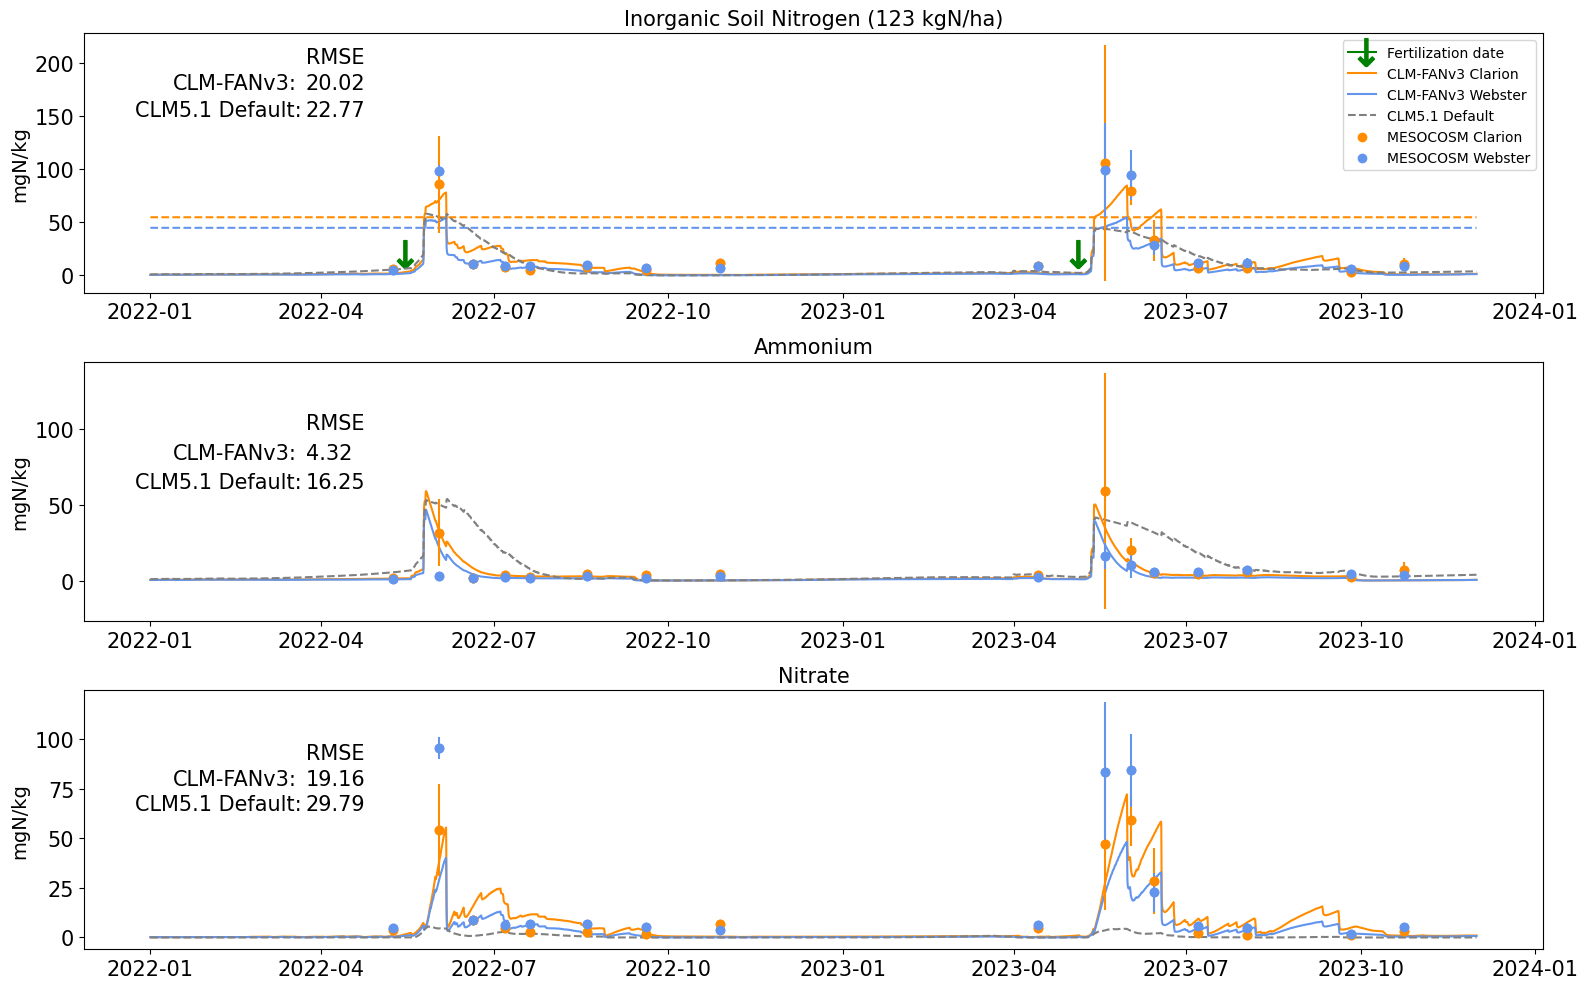

In [7]:
# Read the mesocosm measurement
fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

dsMESOCOSM = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2023data/soil_inorganic_N_combined_2022_2023_control.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

sminn_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').mean()
sminn_cla = sminn_cla.loc[sminn_cla.index > "2022-01-01"]
sminn_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_sminn'].groupby(level='date').std()
sminn_cla_std = sminn_cla_std.loc[sminn_cla_std.index > "2022-01-01"]
sminn_web = dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').mean()
sminn_web = sminn_web.loc[sminn_web.index > "2022-01-01"]
sminn_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_sminn'].groupby(level='date').std()
sminn_web_std = sminn_web_std.loc[sminn_web_std.index > "2022-01-01"]
nh4_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_cla = nh4_cla.loc[nh4_cla.index > "2022-01-01"]
nh4_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_cla_std = nh4_cla_std.loc[nh4_cla_std.index > "2022-01-01"]
nh4_web = dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_web = nh4_web.loc[nh4_web.index > "2022-01-01"]
nh4_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_web_std = nh4_web_std.loc[nh4_web_std.index > "2022-01-01"]
no3_cla = dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_cla = no3_cla.loc[no3_cla.index > "2022-01-01"]
no3_cla_std = dsMESOCOSM.loc[('Clarion', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_cla_std = no3_cla_std.loc[no3_cla_std.index > "2022-01-01"]
no3_web = dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_web = no3_web.loc[no3_web.index > "2022-01-01"]
no3_web_std = dsMESOCOSM.loc[('Webster', 123), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_web_std = no3_web_std.loc[no3_web_std.index > "2022-01-01"]
plot_time = no3_web.index.values

# Read the CLM simulation results
sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Default = dsCLM_Default['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

## gN/m3 to mgN/kg at the top 9 cm soil, soil bulk density from Steven Hall, CLM uses soil density 2650
sminn_Clarion = sminn_Clarion*1000/1125
sminn_Webster = sminn_Webster*1000/1375
sminn_Default = sminn_Default*1000/1375

sminn_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Clarion.time]
sminn_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Webster.time]
sminn_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Default.time]
## gN/m2 to mgN/kg, fertilization depth is around top 10cm
fert_conc_cla = 12.3*1000/0.2/1125
fert_conc_web = 12.3*1000/0.2/1375

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Default["FAN_TOTN"].values - dsCLM_Default["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Default = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion = nh4_Clarion*1000/1125
nh4_Webster = nh4_Webster*1000/1375
nh4_Default = nh4_Default*1000/1375
nh4_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Clarion.time]
nh4_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Webster.time]
nh4_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Default.time]

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Default["NITRATE_TOTN"].values
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Default = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/1125
no3_Webster = no3_Webster*1000/1375
no3_Default = no3_Default*1000/1375
no3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Clarion.time]
no3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Webster.time]
no3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Default.time]

# RMSE Calculations for concentrations.
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(plot_time)]
rmse_n_model = cal_rmse((sminn_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                         + sminn_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                        (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_model = cal_rmse((nh4_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + nh4_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (nh4_cla.values + nh4_web.values)/2)
rmse_no3_model = cal_rmse((no3_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + no3_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (no3_cla.values + no3_web.values)/2)

rmse_n_default = cal_rmse(sminn_Default.sel(time=sample_time, method='nearest').values.flatten(), (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_default = cal_rmse(nh4_Default.sel(time=sample_time, method='nearest').values.flatten(), (nh4_cla.values + nh4_web.values)/2)
rmse_no3_default = cal_rmse(no3_Default.sel(time=sample_time, method='nearest').values.flatten(), (no3_cla.values + no3_web.values)/2)

# graph
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
# theoretical values
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_cla, color='darkorange', linestyle='--')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_web, color='cornflowerblue', linestyle='--')

# fertilisation date
ax[0].plot(fert_date_2022 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green')
ax[0].plot(fert_date_2023 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].plot(sminn_Clarion.time, sminn_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[0].plot(sminn_Webster.time, sminn_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[0].plot(sminn_Default.time, sminn_Default.values, label='CLM5.1 Default', ls='--', color='grey')
ax[0].scatter(plot_time, sminn_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[0].scatter(plot_time, sminn_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)

ax[0].errorbar(plot_time, sminn_cla.values, yerr=sminn_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[0].errorbar(plot_time, sminn_web.values, yerr=sminn_web_std.values, fmt="o", color='cornflowerblue', zorder=2)

ax[0].set_title("Inorganic Soil Nitrogen (123 kgN/ha)", size=15)
ax[0].set_ylabel("mgN/kg", size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].text(fert_date_2022 - 55, 200, "RMSE", size=15)
ax[0].text(fert_date_2022 - 125, 175, "CLM-FANv3:", size=15)
ax[0].text(fert_date_2022 - 145, 150, "CLM5.1 Default:", size=15)
ax[0].text(fert_date_2022 - 55, 175, round(rmse_n_model, 2), size=15)
ax[0].text(fert_date_2022 - 55, 150, round(rmse_n_default, 2), size=15)

ax[1].plot(sminn_Clarion.time, nh4_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[1].plot(sminn_Webster.time, nh4_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].plot(sminn_Default.time, nh4_Default.values, label='CLM default', ls='--', color='grey')
ax[1].scatter(plot_time, nh4_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[1].scatter(plot_time, nh4_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)

ax[1].errorbar(plot_time, nh4_cla.values, yerr=nh4_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[1].errorbar(plot_time, nh4_web.values, yerr=nh4_web_std.values, fmt="o", color='cornflowerblue', zorder=2)

ax[1].set_title("Ammonium", size=15)
ax[1].set_ylabel("mgN/kg", size=14)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].text(fert_date_2022 - 55, 100, "RMSE", size=15)
ax[1].text(fert_date_2022 - 125, 80, "CLM-FANv3:", size=15)
ax[1].text(fert_date_2022 - 145, 61, "CLM5.1 Default:", size=15)
ax[1].text(fert_date_2022 - 55, 80, round(rmse_nh4_model, 2), size=15)
ax[1].text(fert_date_2022 - 55, 61, round(rmse_nh4_default, 2), size=15)

ax[2].plot(sminn_Clarion.time, no3_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[2].plot(sminn_Webster.time, no3_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].plot(sminn_Default.time, no3_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[2].scatter(plot_time, no3_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[2].scatter(plot_time, no3_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)

ax[2].errorbar(plot_time, no3_cla.values, yerr=no3_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[2].errorbar(plot_time, no3_web.values, yerr=no3_web_std.values, fmt="o", color='cornflowerblue', zorder=2)

ax[2].set_title("Nitrate", size=15)
ax[2].set_ylabel("mgN/kg", size=14)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].text(fert_date_2022 - 55, 90, "RMSE", size=15)
ax[2].text(fert_date_2022 - 125, 77, "CLM-FANv3:", size=15)
ax[2].text(fert_date_2022 - 145, 64, "CLM5.1 Default:", size=15)
ax[2].text(fert_date_2022 - 55, 77, round(rmse_no3_model, 2), size=15)
ax[2].text(fert_date_2022 - 55, 64, round(rmse_no3_default, 2), size=15)
fig.tight_layout()
ax[0].legend(loc="upper right")
fig.savefig("finalgraphs/Concentration123kgN.pdf", format='pdf')
plt.show()

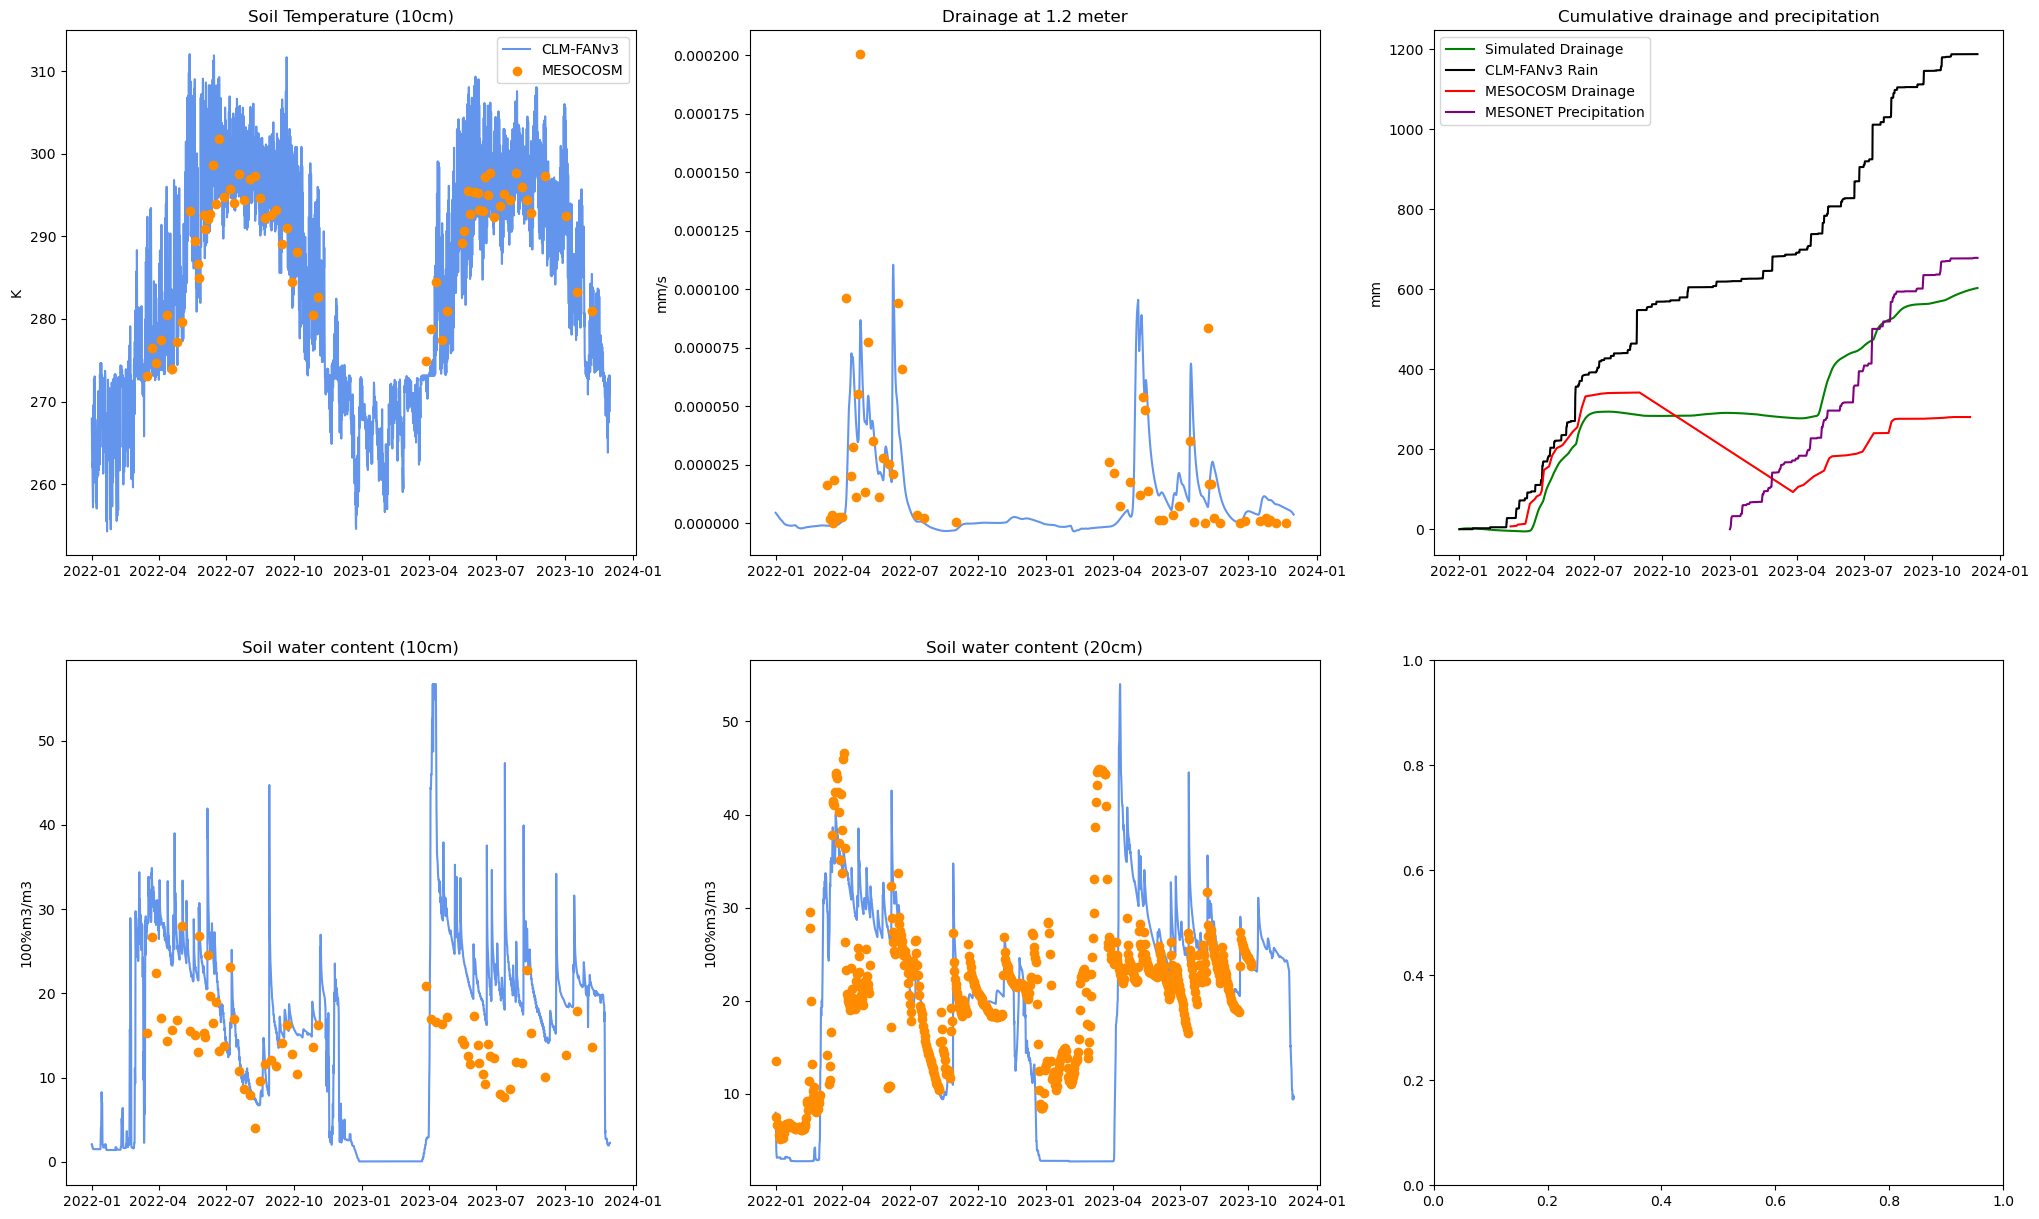

0.1423067584569637


In [8]:
# Read the mesocosm measurements
dsSoil = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2023data/soil_gas_fluxes_combined_2022_2023_control.csv")
dsSoil['date'] = pd.to_datetime(dsSoil['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsSoil['air_temperature_K'] = dsSoil['soil_temperature_C'] + 273.15
dsSoil.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsSoil = dsSoil.sort_index()
dsWater = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2023data/drainage_nitrate_combined_2022_2023_control.csv")
dsWater['date'] = pd.to_datetime(dsWater['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
##Sampling period starts from the last sampling time point. 
dsWater['instantaneous_drainage_mm_s'] = dsWater['drainage_cm']*10/dsWater['st_days']/24/3600
dsWater['cumulative_drainage_mm'] = dsWater['cumulative_annual_drainage_cm']*10
dsWater.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsWater = dsWater.sort_index()
dsWater2 = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2022data/daily_soil_temp_VWC_EC_soil_block_study_2020_2023.csv")
dsWater2['date'] = pd.to_datetime(dsWater2['year_month_day']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsWater2.set_index(['Soil', 'date'], inplace=True)

air_tem = dsSoil.loc[('Clarion'), 'air_temperature_K'].groupby('date').mean()
air_tem = air_tem.loc[air_tem.index > "2022-01-01"]
air_tem_web = dsSoil.loc[('Webster'), 'air_temperature_K'].groupby('date').mean()
air_tem_web = air_tem.loc[air_tem.index > "2022-01-01"]
h2o_meso = dsSoil.loc[('Clarion'), 'soil_moisture_volume_percent'].groupby('date').mean()
h2o_meso = h2o_meso.loc[h2o_meso.index > "2022-01-01"]
h2o_meso_20cm = dsWater2.loc['clarion'].loc['2022-01-01':'2023-12-31']['VWC']*100
h2o_meso_web = dsSoil.loc[('Webster'), 'soil_moisture_volume_percent'].groupby('date').mean()
h2o_meso_web = h2o_meso.loc[h2o_meso.index > "2022-01-01"]
h2o_meso_20cm_web = dsWater2.loc['webster'].loc['2022-01-01':'2023-12-31']['VWC']*100

runoff_meso = dsWater.loc[('Clarion'), 'instantaneous_drainage_mm_s'].groupby('date').mean()
runoff_meso_std = dsWater.loc[('Clarion'), 'instantaneous_drainage_mm_s'].groupby('date').std()
runoff_meso = runoff_meso.loc[runoff_meso.index > "2022-01-01"]
runoff_meso_web = dsWater.loc[('Webster'), 'instantaneous_drainage_mm_s'].groupby('date').mean()
runoff_meso_web_std = dsWater.loc[('Webster'), 'instantaneous_drainage_mm_s'].groupby('date').std()
runoff_meso_web = runoff_meso_web.loc[runoff_meso_web.index > "2022-01-01"]
runoff_meso_std = runoff_meso_std.loc[runoff_meso.index > "2022-01-01"]
runoff_meso_cum = dsWater.loc[('Clarion'), 'cumulative_drainage_mm'].groupby('date').mean()
runoff_meso_cum_std = dsWater.loc[('Clarion'), 'cumulative_drainage_mm'].groupby('date').std()
#runoff_meso_cum.loc[runoff_meso_cum.index > "2023-01-01"] += float(runoff_meso_cum.loc[runoff_meso_cum.index == "2022-09-01"].values)
runoff_meso_cum = runoff_meso_cum.loc[runoff_meso_cum.index > "2022-01-01"]
runoff_meso_cum_std = runoff_meso_cum_std.loc[runoff_meso_cum.index > "2022-01-01"]
runoff_meso_2022_cum = runoff_meso_cum.loc[runoff_meso_cum.index < "2023-01-01"]
runoff_meso_2022_cum_std = runoff_meso_cum_std.loc[runoff_meso_cum.index < "2023-01-01"]
runoff_meso_2023_cum = runoff_meso_cum.loc[runoff_meso_cum.index > "2023-01-01"]
runoff_meso_2023_cum_std = runoff_meso_cum_std.loc[runoff_meso_cum.index > "2023-01-01"]
runoff_meso_web_cum = dsWater.loc[('Webster'), 'cumulative_drainage_mm'].groupby('date').mean()
runoff_meso_web_cum_std = dsWater.loc[('Webster'), 'cumulative_drainage_mm'].groupby('date').std()
runoff_meso_web_cum = runoff_meso_web_cum.loc[runoff_meso_web_cum.index > "2022-01-01"]
runoff_meso_web_cum_std = runoff_meso_web_cum_std.loc[runoff_meso_web_cum.index > "2022-01-01"]
runoff_meso_web_2022_cum = runoff_meso_web_cum.loc[runoff_meso_web_cum.index < "2023-01-01"]
runoff_meso_web_2022_cum_std = runoff_meso_web_cum_std.loc[runoff_meso_web_cum.index < "2023-01-01"]
runoff_meso_web_2023_cum = runoff_meso_web_cum.loc[runoff_meso_web_cum.index > "2023-01-01"]
runoff_meso_web_2023_cum_std = runoff_meso_web_cum_std.loc[runoff_meso_web_cum.index > "2023-01-01"]

# Read the CLM simulations
tem_sim = dsCLM_Clarion['TSOI_10CM']
tem_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in tem_sim.time]
tem_sim_web = dsCLM_Webster['TSOI_10CM']
tem_sim_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in tem_sim_web.time]
tem_sim_default = dsCLM_Default['TSOI_10CM']
tem_sim_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in tem_sim_default.time]
h2o_sim = (dsCLM_Clarion['SOILLIQ']/1000/dsCLM_Clarion['depth']).sel(levsoi=[0.09]).mean(dim='levsoi') * 100
h2o_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim.time]
h2o_sim_web = (dsCLM_Webster['SOILLIQ']/1000/dsCLM_Webster['depth']).sel(levsoi=[0.09]).mean(dim='levsoi') * 100
h2o_sim_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim_web.time]
h2o_sim_default = (dsCLM_Default['SOILLIQ']/1000/dsCLM_Default['depth']).sel(levsoi=[0.09]).mean(dim='levsoi') * 100
h2o_sim_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim_default.time]
h2o_sim_20cm = (dsCLM_Clarion['SOILLIQ']/1000/dsCLM_Clarion['depth']).sel(levsoi=[0.16, 0.26]).mean(dim='levsoi') * 100
h2o_sim_20cm['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim_20cm.time]
h2o_sim_20cm_web = (dsCLM_Webster['SOILLIQ']/1000/dsCLM_Webster['depth']).sel(levsoi=[0.16, 0.26]).mean(dim='levsoi') * 100
h2o_sim_20cm_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim_20cm_web.time]
h2o_sim_20cm_default = (dsCLM_Default['SOILLIQ']/1000/dsCLM_Default['depth']).sel(levsoi=[0.16, 0.26]).mean(dim='levsoi') * 100
h2o_sim_20cm_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_sim_20cm_default.time]
runoff_sim = dsCLM_Clarion['QOUT120cm']
runoff_sim['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim.time]
runoff_sim_web = dsCLM_Webster['QOUT120cm']
runoff_sim_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_web.time]
runoff_sim_default = dsCLM_Default['QOUT120cm']
runoff_sim_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_default.time]
##Hourly resolution, from mm/s to mm
#runoff_sim_cum = (dsCLM_Clarion['QOVER']*3600 + dsCLM_Clarion['QOUT']*3600).cumsum()
runoff_sim_cum = (dsCLM_Clarion['QOUT120cm']*3600).cumsum()
runoff_sim_cum['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_cum.time]
runoff_sim_cum_web = (dsCLM_Webster['QOUT120cm']*3600).cumsum()
runoff_sim_cum_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_cum_web.time]
runoff_sim_cum_default = (dsCLM_Default['QOUT120cm']*3600).cumsum()
runoff_sim_cum_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_cum_default.time]
runoff_sim_2022_cum = (dsCLM_Clarion['QOUT120cm'].sel(time="2022")*3600).cumsum()
runoff_sim_2022_cum['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2022_cum.time]
runoff_sim_2022_cum_web = (dsCLM_Webster['QOUT120cm'].sel(time="2022")*3600).cumsum()
runoff_sim_2022_cum_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2022_cum_web.time]
runoff_sim_2022_cum_default = (dsCLM_Default['QOUT120cm'].sel(time="2022")*3600).cumsum()
runoff_sim_2022_cum_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2022_cum_default.time]

runoff_sim_2023_cum = (dsCLM_Clarion['QOUT120cm'].sel(time="2023")*3600).cumsum()
runoff_sim_2023_cum['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2023_cum.time]
runoff_sim_2023_cum_web = (dsCLM_Clarion['QOUT120cm'].sel(time="2023")*3600).cumsum()
runoff_sim_2023_cum_web['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2023_cum_web.time]
runoff_sim_2023_cum_default = (dsCLM_Default['QOUT120cm'].sel(time="2023")*3600).cumsum()
runoff_sim_2023_cum_default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_2023_cum_default.time]
runoff_sim_web_2022_cum = (dsCLM_Webster['QOUT120cm'].sel(time="2022")*3600).cumsum()
runoff_sim_web_2022_cum['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_web_2022_cum.time]
runoff_sim_web_2023_cum = (dsCLM_Webster['QOUT120cm'].sel(time="2023")*3600).cumsum()
runoff_sim_web_2023_cum['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in runoff_sim_web_2023_cum.time]
rain_sim_cum = (dsCLM_Clarion['RAIN']*3600).cumsum()
Prec = xr.open_mfdataset("/glade/work/jinmuluo/MESONET/datmdata/clmforc.BOOI4.Prec.isu_point.2023-*.nc")
Prec = Prec.sel(time=slice(cftime.DatetimeNoLeap(start_date.year, start_date.month, start_date.day), cftime.DatetimeNoLeap(end_date.year, end_date.month, end_date.day)))
## resample three hours to daily, and transform the unit form mm/sec to mm
Prec = Prec.resample(time='D').mean()*24*3600
Prec['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Prec.time]


# Graph
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
ax[0, 0].plot(tem_sim.time, tem_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0, 0].scatter(air_tem.index.values, air_tem, label='MESOCOSM', color='darkorange', zorder=2)
ax[0, 0].set_title("Soil Temperature (10cm)")
ax[0, 0].set_ylabel("K")
ax[0, 0].legend()

ax[0, 1].plot(runoff_sim.time, runoff_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0, 1].scatter(runoff_meso.index.values, runoff_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0, 1].set_title("Drainage at 1.2 meter")
ax[0, 1].set_ylabel("mm/s")

ax[0, 2].plot(runoff_sim.time, runoff_sim_cum.values,label='Simulated Drainage', color='green')
ax[0, 2].plot(runoff_sim.time, rain_sim_cum.values, label='CLM-FANv3 Rain', color='black')
ax[0, 2].plot(runoff_meso_cum.index.values, runoff_meso_cum.values, label='MESOCOSM Drainage', color='red')
ax[0, 2].plot(Prec.time, np.squeeze(Prec['PRECTmms'].cumsum().values), label='MESONET Precipitation', color='purple')
ax[0, 2].legend(loc='upper left')
ax[0, 2].set_title('Cumulative drainage and precipitation')
ax[0, 2].set_ylabel('mm')

ax[1, 0].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1, 0].scatter(h2o_meso.index.values, h2o_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1, 0].set_title("Soil water content (10cm)")
ax[1, 0].set_ylabel("100%m3/m3")

ax[1, 1].plot(h2o_sim_20cm.time, h2o_sim_20cm.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1, 1].scatter(h2o_meso_20cm.index.values, h2o_meso_20cm.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1, 1].set_title("Soil water content (20cm)")
ax[1, 1].set_ylabel("100%m3/m3")
#fig.savefig("graphs/Env_2023.jpg", dpi=300)
plt.show()

# Calculation
meso_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in h2o_meso.index]
h2o_sim_meso = h2o_sim.sel(time=meso_time)
print(((h2o_sim_meso.values - h2o_meso.values)/h2o_sim_meso.values).mean())

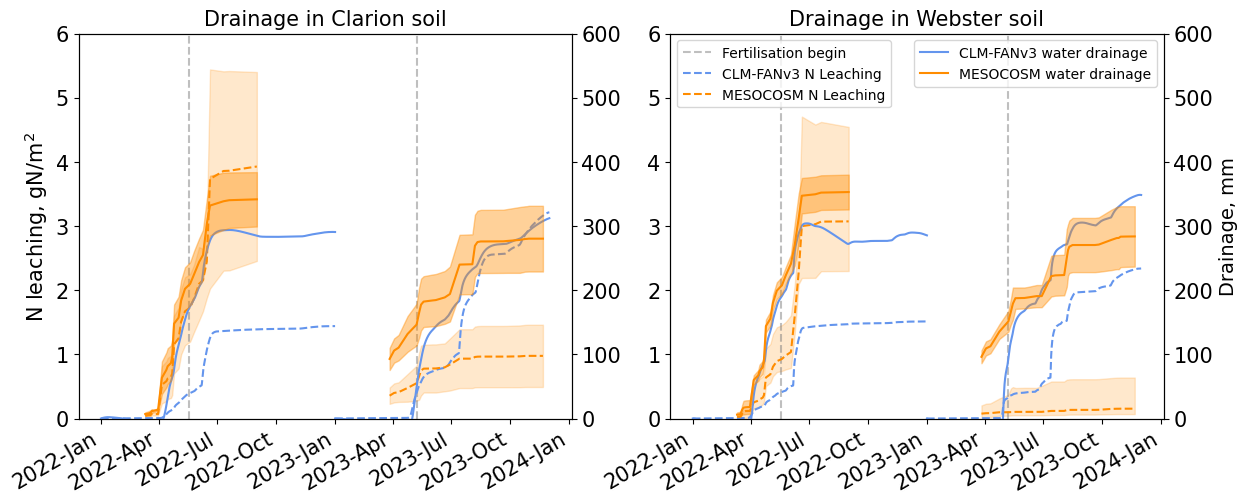

In [9]:
# Read the measuremnts
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['NO3N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['NH4N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']
dsWater['cumulative_nitrogen_gN_m2'] = dsWater['cumulative_annual_inorganicN_kg_ha']/10

runoff_meso_cum.loc[runoff_meso_cum.index > "2022-01-01"]

ndra_meso_cla_mean = dsWater.loc[('Clarion', '123'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_cla_std = dsWater.loc[('Clarion', '123'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()
ndra_meso_web_mean = dsWater.loc[('Webster', '123'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_web_std = dsWater.loc[('Webster', '123'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()

ndra_meso_cla_cum_mean = dsWater.loc[('Clarion', '123'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_cla_cum_std = dsWater.loc[('Clarion', '123'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_cla_cum_mean_2022 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index < "2023-01-01"]
ndra_meso_cla_cum_std_2022 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index < "2023-01-01"]
ndra_meso_cla_cum_mean_2023 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index > "2023-01-01"]
ndra_meso_cla_cum_std_2023 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index > "2023-01-01"]
ndra_meso_web_cum_mean = dsWater.loc[('Webster', '123'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_web_cum_std = dsWater.loc[('Webster', '123'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_web_cum_mean_2022 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index < "2023-01-01"]
ndra_meso_web_cum_std_2022 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index < "2023-01-01"]
ndra_meso_web_cum_mean_2023 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index > "2023-01-01"]
ndra_meso_web_cum_std_2023 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index > "2023-01-01"]

plottime_2022 = ndra_meso_cla_cum_mean_2022.index.values
plottime_2023 = ndra_meso_cla_cum_mean_2023.index.values

plot_width = np.zeros(runoff_meso.index.values.shape[0])
meso_modelmatched_cla = np.zeros(runoff_meso.index.values.shape[0])
meso_modelmatched_web = np.zeros(runoff_meso_web.index.values.shape[0])

for i in range(0, runoff_meso.index.values.shape[0]):
    if i == 0:
        plot_width[i] = 7
        meso_modelmatched_cla[i] = dsCLM_Clarion['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[0])[0:10], '2022-03-01')).mean().values
        meso_modelmatched_web[i] = dsCLM_Webster['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[0])[0:10], '2022-03-01')).mean().values
    else:
        plot_width[i] = runoff_meso.index.values[i] - runoff_meso.index.values[i-1]
        plot_width[i] = plot_width[i]/24/3600/1e9 #ns to days
        meso_modelmatched_cla[i] = dsCLM_Clarion['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[i-1])[0:10], str(runoff_meso.index.values[i])[0:10])).mean().values
        meso_modelmatched_web[i] = dsCLM_Webster['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[i-1])[0:10], str(runoff_meso.index.values[i])[0:10])).mean().values
    # for the first day of 2023
    if plot_width[i] >= 100:
        plot_width[i] = 14
        meso_modelmatched_cla[i] = dsCLM_Clarion['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[0])[0:10], '2023-02-15')).mean().values
        meso_modelmatched_web[i] = dsCLM_Webster['QOUT120cm'].sel(time=slice(str(runoff_meso.index.values[0])[0:10], '2023-02-15')).mean().values


# CLM simulations
Total_N_runoff_cla = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
Total_N_runoff_web = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']
Total_N_runoff_default = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']

## hourly resolution!!
Total_N_cum_runoff_cla_2022 = (Total_N_runoff_cla.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_cla_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2022.time]
Total_N_cum_runoff_web_2022 = (Total_N_runoff_web.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_web_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2022.time]
Total_N_cum_runoff_default_2022 = (Total_N_runoff_default.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_default_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2022.time]
Total_N_cum_runoff_cla_2023 = (Total_N_runoff_cla.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_cla_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2023.time]
Total_N_cum_runoff_web_2023 = (Total_N_runoff_web.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_web_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2023.time]
Total_N_cum_runoff_default_2023 = (Total_N_runoff_default.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_default_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2023.time]

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14,5))



ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[0].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[1].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')

ax[0].plot(Total_N_cum_runoff_cla_2022.time, Total_N_cum_runoff_cla_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[1].plot(Total_N_cum_runoff_web_2022.time, Total_N_cum_runoff_web_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[0].plot(Total_N_cum_runoff_cla_2023.time, Total_N_cum_runoff_cla_2023.values, color='cornflowerblue', linestyle='--')
ax[1].plot(Total_N_cum_runoff_web_2023.time, Total_N_cum_runoff_web_2023.values, color='cornflowerblue', linestyle='--')

ax[0].plot(plottime_2022, ndra_meso_cla_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[1].plot(plottime_2022, ndra_meso_web_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[0].fill_between(plottime_2022, ndra_meso_cla_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_cla_cum_mean_2022.values-ndra_meso_cla_cum_std_2022.values, color='darkorange', alpha=0.2)
ax[1].fill_between(plottime_2022, ndra_meso_web_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_web_cum_mean_2022.values-ndra_meso_web_cum_std_2022.values, color='darkorange', alpha=0.2)
ax[0].plot(plottime_2023, ndra_meso_cla_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[1].plot(plottime_2023, ndra_meso_web_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[0].fill_between(plottime_2023, ndra_meso_cla_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_cla_cum_mean_2023.values-ndra_meso_cla_cum_std_2023.values, color='darkorange', alpha=0.2)
ax[1].fill_between(plottime_2023, ndra_meso_web_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_web_cum_mean_2023.values-ndra_meso_web_cum_std_2023.values, color='darkorange', alpha=0.2)

# add the total water drainge in here.
ax1 = ax[0].twinx()
ax1.plot(runoff_sim_2022_cum.time, runoff_sim_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax1.plot(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax1.fill_between(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values+runoff_meso_2022_cum_std.values, runoff_meso_2022_cum.values - runoff_meso_2022_cum_std.values, color='darkorange', alpha=0.4)
ax1.plot(runoff_sim_2023_cum.time, runoff_sim_2023_cum.values, color='cornflowerblue', zorder=1)
ax1.plot(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values, color='darkorange', zorder=1)
ax1.fill_between(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values+runoff_meso_2023_cum_std.values, runoff_meso_2023_cum.values - runoff_meso_2023_cum_std.values, color='darkorange', alpha=0.4)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0, 600)
ax2 = ax[1].twinx()
ax2.plot(runoff_sim_web_2022_cum.time, runoff_sim_web_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax2.plot(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax2.fill_between(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values+runoff_meso_web_2022_cum_std.values, runoff_meso_web_2022_cum.values - runoff_meso_web_2022_cum_std.values, color='darkorange', alpha=0.4)
ax2.plot(runoff_sim_web_2023_cum.time, runoff_sim_web_2023_cum.values, color='cornflowerblue', zorder=1)
ax2.plot(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values, color='darkorange', zorder=1)
ax2.fill_between(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values+runoff_meso_web_2023_cum_std.values, runoff_meso_web_2023_cum.values - runoff_meso_web_2023_cum_std.values, color='darkorange', alpha=0.4)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right')
ax2.set_ylabel('Drainage, mm', size=14)
ax2.set_ylim(0, 600)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 6)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim(0, 6)
ax[0].set_ylabel('N leaching, gN/m$^2$', size=15)
ax[0].set_title('Drainage in Clarion soil', size=15)
ax[1].set_title('Drainage in Webster soil', size=15)
ax[1].legend(loc='upper left')

fig.savefig("finalgraphs/DrainageAndLeaching123kg.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_203897/45054231.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


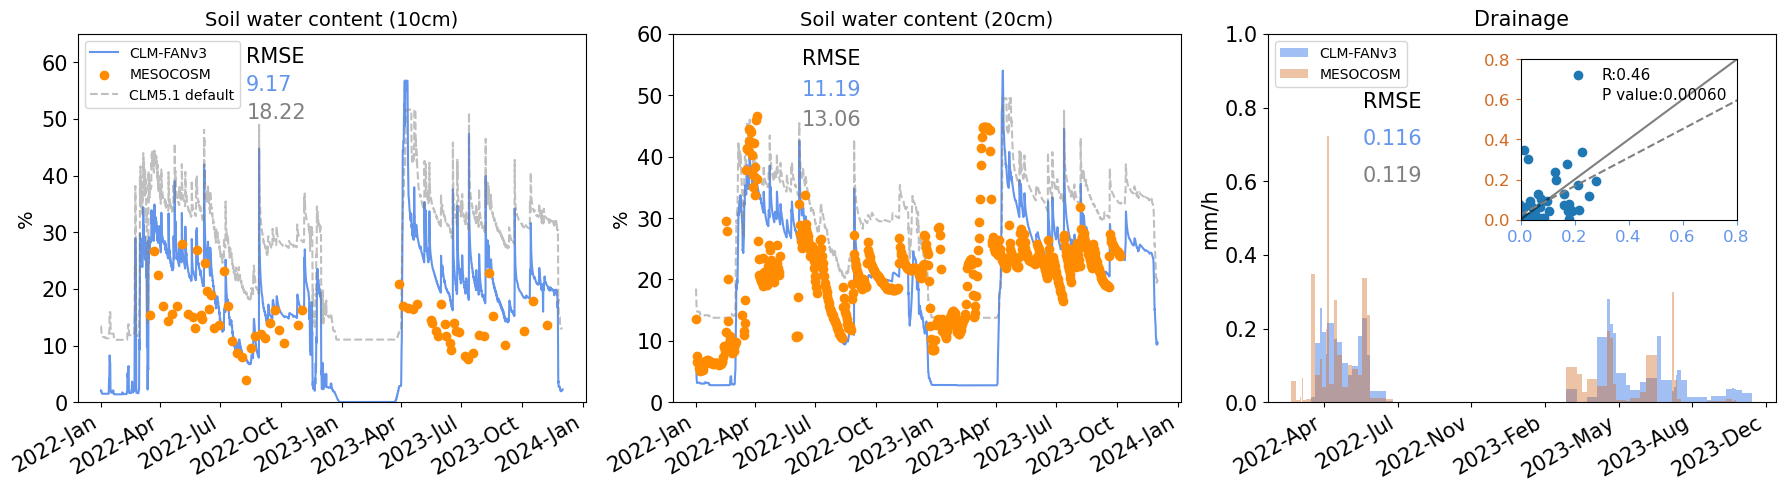

In [10]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(h2o_meso.index.values)]
rmse_h2o10cm = cal_rmse(h2o_sim.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso.values)
rmse_h2o10cm_default = cal_rmse(h2o_sim_default.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso.values)

a = h2o_meso_20cm.loc["2022-03-01":"2022-11-01"] + h2o_meso_20cm.loc["2023-03-01":"2023-11-01"]
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(a.index.values)]
rmse_h2o20cm = cal_rmse(h2o_sim_20cm.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_20cm.loc[a.index].values)
rmse_h2o20cm_default = cal_rmse(h2o_sim_20cm_default.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_20cm.loc[a.index].values)

sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(runoff_meso.index.values)]
rmse_drainage = cal_rmse(runoff_sim.sel(time=sample_time, method='nearest').values.flatten()*3600, runoff_meso.values*3600)
rmse_drainage_default = cal_rmse(runoff_sim_default.sel(time=sample_time, method='nearest').values.flatten()*3600, runoff_meso.values*3600)

# Graph
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(h2o_meso.index.values, h2o_meso.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0].plot(h2o_sim_default.time, h2o_sim_default.values, label='CLM5.1 default', ls='--', color='grey', alpha = 0.5, zorder=1)
ax[0].set_title("Soil water content (10cm)", size=14)
ax[0].set_ylabel("%", size=14)
ax[0].set_ylim(0, 65)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='upper left')
ax[0].text(h2o_meso.index.values[25], 60, "RMSE", size=15)
ax[0].text(h2o_meso.index.values[25], 55, round(rmse_h2o10cm, 2), color='cornflowerblue', size=15)
ax[0].text(h2o_meso.index.values[25], 50, round(rmse_h2o10cm_default, 2), color='grey', size=15)

ax[1].plot(h2o_sim_20cm.time, h2o_sim_20cm.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(h2o_meso_20cm.index.values, h2o_meso_20cm.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1].plot(h2o_sim_20cm_default.time, h2o_sim_20cm_default.values, label='CLM5.1 default', ls='--', color='grey', alpha = 0.5, zorder=1)
ax[1].set_title("Soil water content (20cm)", size=14)
ax[1].set_ylabel("%", size=14)
ax[1].set_ylim(0, 60)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].text(h2o_meso.index.values[15], 55, "RMSE", size=15)
ax[1].text(h2o_meso.index.values[15], 50, round(rmse_h2o20cm, 2), color='cornflowerblue', size=15)
ax[1].text(h2o_meso.index.values[15], 45, round(rmse_h2o20cm_default, 2), color='grey', size=15)

#ax[2].bar(runoff_sim.time, runoff_sim.values.ravel()*3600, color='cornflowerblue', label='CLM-FANv3', alpha=0.2)
ax[2].bar(mdates.date2num(runoff_meso.index.values)-plot_width/2, meso_modelmatched_cla*3600, width=plot_width, color='cornflowerblue', label='CLM-FANv3', alpha=0.6)
ax[2].bar(mdates.date2num(runoff_meso.index.values)-plot_width/2, runoff_meso.values.ravel()*3600, width=plot_width, color='chocolate', label='MESOCOSM', alpha=0.4)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[2].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[2].set_ylim(0, 1.0)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_ylabel("mm/h", size=15)
ax[2].legend(loc='upper left')
ax[2].set_title('Drainage', size=15)
ax[2].text(h2o_meso.index.values[15], 0.8, "RMSE", size=15)
ax[2].text(h2o_meso.index.values[15], 0.7, round(rmse_drainage, 3), color='cornflowerblue', size=15)
ax[2].text(h2o_meso.index.values[15], 0.6, round(rmse_drainage_default, 3), color='grey', size=15)

# Create the embedded axes inside the SECOND subplot
left1, bottom1, width1, height1 = [0.85, 0.55, 0.12, 0.32]
ax_embedded1 = fig.add_axes([left1, bottom1, width1, height1])
slope, intercept, r_value, p_value, std_err = stats.linregress(meso_modelmatched_cla[1:]*3600, runoff_meso.values.ravel()[1:]*3600)
ax_embedded1.scatter(meso_modelmatched_cla*3600, runoff_meso.values.ravel()*3600)
ax_embedded1.plot([0.0, 1.0], [0.0, 1.0], color='black', alpha=0.5)
ax_embedded1.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)*slope + intercept, ls='--', color='grey')
ax_embedded1.text(0.3, 0.7, f'R:{r_value:.2f}', size=11)
ax_embedded1.text(0.3, 0.6, f'P value:{p_value:.5f}', size=11)
ax_embedded1.set_xlim(0, 0.8)
ax_embedded1.tick_params(axis='x', colors='cornflowerblue', labelsize=12)
ax_embedded1.set_ylim(0, 0.8)
ax_embedded1.tick_params(axis='y', colors='chocolate', labelsize=12)

fig.tight_layout()
fig.savefig("finalgraphs/Hydrology.pdf", format='pdf')
plt.show()

In [11]:
#h2o_meso_20cm[75:100]
dsCLM_Clarion['SOILLIQ'].sel(levsoi=[0.16, 0.26]).mean(dim='levsoi').idxmax(dim='time').values

array([cftime.DatetimeNoLeap(2023, 4, 10, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_203897/1076796866.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


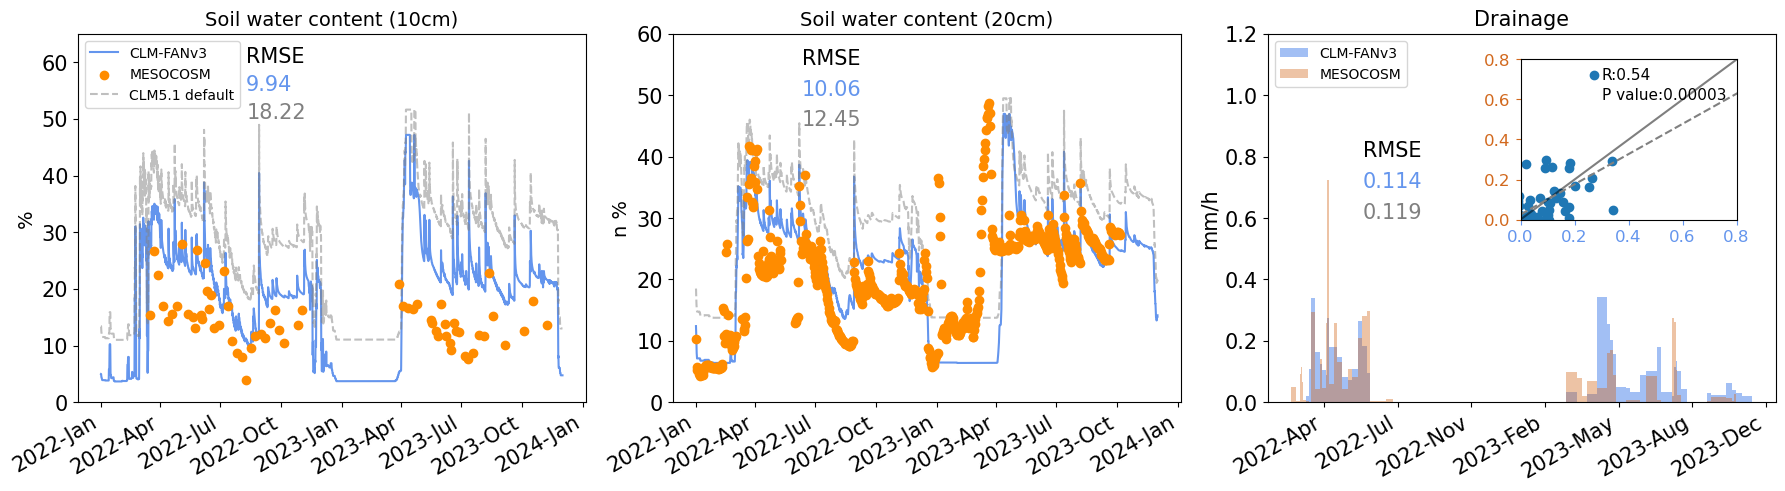

In [12]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(h2o_meso_web.index.values)]
rmse_h2o10cm = cal_rmse(h2o_sim_web.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_web.values)
rmse_h2o10cm_default = cal_rmse(h2o_sim_default.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_web.values)

a = h2o_meso_20cm_web.loc["2022-03-01":"2022-11-01"] + h2o_meso_20cm_web.loc["2023-03-01":"2023-11-01"]
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(a.index.values)]
rmse_h2o20cm = cal_rmse(h2o_sim_20cm_web.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_20cm_web.loc[a.index].values)
rmse_h2o20cm_default = cal_rmse(h2o_sim_20cm_default.sel(time=sample_time, method='nearest').values.flatten(), h2o_meso_20cm_web.loc[a.index].values)

sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(runoff_meso_web.index.values)]
rmse_drainage = cal_rmse(runoff_sim_web.sel(time=sample_time, method='nearest').values.flatten()*3600, runoff_meso_web.values*3600)
rmse_drainage_default = cal_rmse(runoff_sim_default.sel(time=sample_time, method='nearest').values.flatten()*3600, runoff_meso_web.values*3600)

# Graph
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(h2o_sim_web.time, h2o_sim_web.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(h2o_meso_web.index.values, h2o_meso_web.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[0].plot(h2o_sim_default.time, h2o_sim_default.values, label='CLM5.1 default', ls='--', color='grey', alpha = 0.5, zorder=1)
ax[0].set_title("Soil water content (10cm)", size=14)
ax[0].set_ylabel("%", size=14)
ax[0].set_ylim(0, 65)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='upper left')
ax[0].text(h2o_meso_web.index.values[25], 60, "RMSE", size=15)
ax[0].text(h2o_meso_web.index.values[25], 55, round(rmse_h2o10cm, 2), color='cornflowerblue', size=15)
ax[0].text(h2o_meso_web.index.values[25], 50, round(rmse_h2o10cm_default, 2), color='grey', size=15)

ax[1].plot(h2o_sim_20cm_web.time, h2o_sim_20cm_web.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(h2o_meso_20cm_web.index.values, h2o_meso_20cm_web.values, label='MESOCOSM', color='darkorange', zorder=2)
ax[1].plot(h2o_sim_20cm_default.time, h2o_sim_20cm_default.values, label='CLM5.1 default', ls='--', color='grey', alpha = 0.5, zorder=1)
ax[1].set_title("Soil water content (20cm)", size=14)
ax[1].set_ylabel("n %", size=14)
ax[1].set_ylim(0, 60)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].text(h2o_meso_web.index.values[15], 55, "RMSE", size=15)
ax[1].text(h2o_meso_web.index.values[15], 50, round(rmse_h2o20cm, 2), color='cornflowerblue', size=15)
ax[1].text(h2o_meso_web.index.values[15], 45, round(rmse_h2o20cm_default, 2), color='grey', size=15)

#ax[2].bar(runoff_sim_web.time, runoff_sim_web.values.ravel()*3600, color='cornflowerblue', label='CLM-FANv3', alpha=0.2)
ax[2].bar(mdates.date2num(runoff_meso_web.index.values)-plot_width/2, meso_modelmatched_web*3600, width=plot_width, color='cornflowerblue', label='CLM-FANv3', alpha=0.6)
ax[2].bar(mdates.date2num(runoff_meso_web.index.values)-plot_width/2, runoff_meso_web.values.ravel()*3600, width=plot_width, color='chocolate', label='MESOCOSM', alpha=0.4)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[2].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[2].set_ylim(0, 1.2)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_ylabel("mm/h", size=15)
ax[2].legend(loc='upper left')
ax[2].set_title('Drainage', size=15)
ax[2].text(h2o_meso.index.values[15], 0.8, "RMSE", size=15)
ax[2].text(h2o_meso.index.values[15], 0.7, round(rmse_drainage, 3), color='cornflowerblue', size=15)
ax[2].text(h2o_meso.index.values[15], 0.6, round(rmse_drainage_default, 3), color='grey', size=15)

# Create the embedded axes inside the SECOND subplot
left1, bottom1, width1, height1 = [0.85, 0.55, 0.12, 0.32]
ax_embedded1 = fig.add_axes([left1, bottom1, width1, height1])
slope, intercept, r_value, p_value, std_err = stats.linregress(meso_modelmatched_web[1:]*3600, runoff_meso_web.values.ravel()[1:]*3600)
ax_embedded1.scatter(meso_modelmatched_web*3600, runoff_meso_web.values.ravel()*3600)
ax_embedded1.plot([0.0, 1.0], [0.0, 1.0], color='black', alpha=0.5)
ax_embedded1.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)*slope + intercept, ls='--', color='grey')
ax_embedded1.text(0.3, 0.7, f'R:{r_value:.2f}', size=11)
ax_embedded1.text(0.3, 0.6, f'P value:{p_value:.5f}', size=11)
ax_embedded1.set_xlim(0, 0.8)
ax_embedded1.tick_params(axis='x', colors='cornflowerblue', labelsize=12)
ax_embedded1.set_ylim(0, 0.8)
ax_embedded1.tick_params(axis='y', colors='chocolate', labelsize=12)

fig.tight_layout()
fig.savefig("finalgraphs/HydrologyWebster.pdf", format='pdf')
plt.show()

6.923430782345904 6.860426439524909


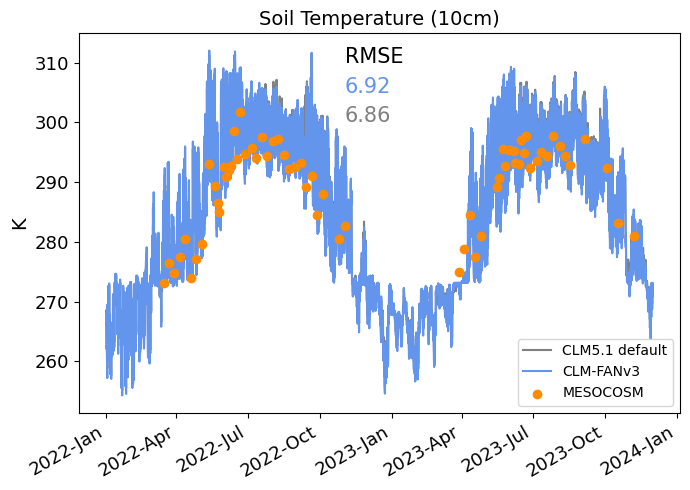

In [13]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(air_tem.index.values)]
rmse_tem = cal_rmse(tem_sim.sel(time=sample_time, method='nearest').values.flatten(), air_tem.values)
rmse_tem_default = cal_rmse(tem_sim_default.sel(time=sample_time, method='nearest').values.flatten(), air_tem.values)
print(rmse_tem, rmse_tem_default)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(tem_sim_default.time, tem_sim_default.values, label='CLM5.1 default', color='grey', zorder=1)
ax.plot(tem_sim.time, tem_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax.scatter(air_tem.index.values, air_tem, label='MESOCOSM', color='darkorange', zorder=2)
ax.set_title("Soil Temperature (10cm)", size=14)
ax.set_ylabel("K", size=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.text(air_tem.index.values[35], 310, "RMSE", size=15)
ax.text(air_tem.index.values[35], 305, round(rmse_tem, 2), color='cornflowerblue', size=15)
ax.text(air_tem.index.values[35], 300, round(rmse_tem_default, 2), color='grey', size=15)
ax.legend()
fig.tight_layout()
fig.savefig("finalgraphs/SoimTemperature.pdf", format='pdf')

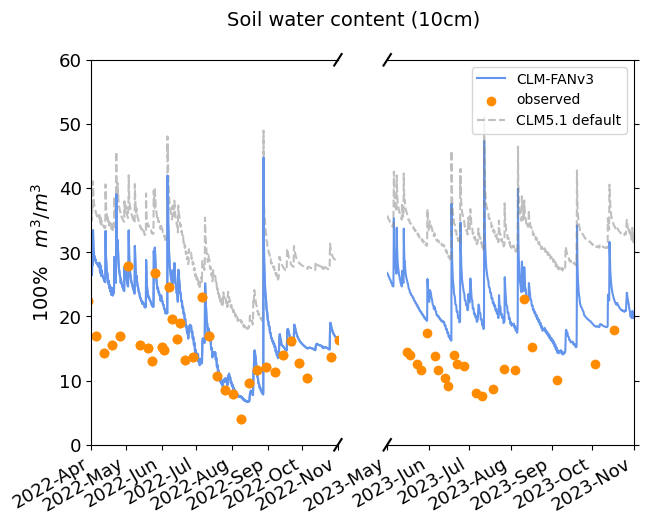

In [14]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 5))
ax[0].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(h2o_meso.index.values, h2o_meso.values, label='observed', color='darkorange', zorder=2)
ax[0].plot(h2o_sim_default.time, h2o_sim_default.values, label='CLM5.1 default', ls='--', color='grey', alpha = 0.5, zorder=1)
ax[1].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(h2o_meso.index.values, h2o_meso.values, label='observed', color='darkorange', zorder=2)
ax[1].plot(h2o_sim_default.time, h2o_sim_default.values, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[0].plot(h2o_sim.time, h2o_sim.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(h2o_meso.index.values, h2o_meso.values, label='observed', color='darkorange', zorder=2)
ax[0].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_ylabel("$100 \% \quad m^3/m^3$", size=14)
ax[0].set_ylim(0, 60)
ax[1].set_ylim(0, 60)
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 5, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("Soil water content (10cm)", size=14)
#fig.tight_layout()
fig.savefig("finalgraphs/SW10cm.pdf", format='pdf', bbox_inches='tight')
plt.show()

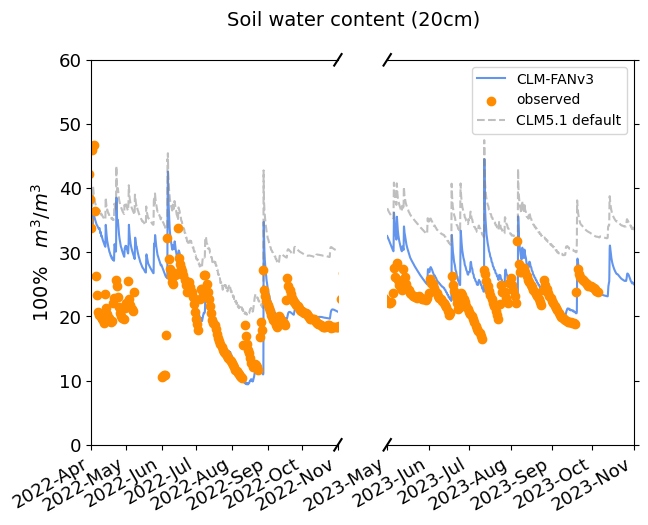

In [15]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 5))
ax[0].plot(h2o_sim_20cm.time, h2o_sim_20cm.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].scatter(h2o_meso_20cm.index.values, h2o_meso_20cm.values, label='observed', color='darkorange', zorder=2)
ax[0].plot(h2o_sim_20cm_default.time, h2o_sim_20cm_default.values, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[1].plot(h2o_sim_20cm.time, h2o_sim_20cm.values, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].scatter(h2o_meso_20cm.index.values, h2o_meso_20cm.values, label='observed', color='darkorange', zorder=2)
ax[1].plot(h2o_sim_20cm_default.time, h2o_sim_20cm_default.values, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[0].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_ylabel("$100 \% \quad m^3/m^3$", size=14)
ax[0].set_ylim(0, 60)
ax[1].set_ylim(0, 60)
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 5, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("Soil water content (20cm)", size=14)
#fig.tight_layout()
fig.savefig("finalgraphs/SW20cm.pdf", format='pdf', bbox_inches='tight')
plt.show()

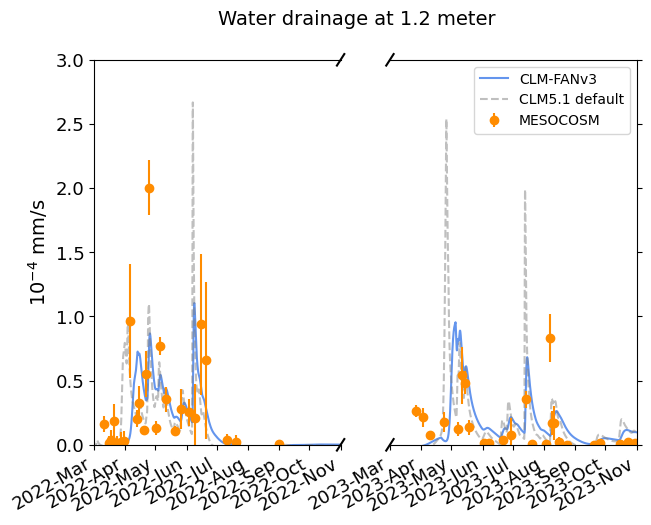

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 5))
ax[0].plot(runoff_sim.time, runoff_sim.values*10000, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[0].errorbar(runoff_meso.index.values, runoff_meso.values*10000, yerr=runoff_meso_std.values*10000, fmt="o", label='MESOCOSM', color='darkorange', zorder=2)
ax[0].plot(runoff_sim_default.time, runoff_sim_default.values*10000, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[1].plot(runoff_sim.time, runoff_sim.values*10000, label='CLM-FANv3', color='cornflowerblue', zorder=1)
ax[1].errorbar(runoff_meso.index.values, runoff_meso.values*10000, yerr=runoff_meso_std.values*10000, fmt="o", label='MESOCOSM', color='darkorange', zorder=2)
ax[1].plot(runoff_sim_default.time, runoff_sim_default.values*10000, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[0].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_ylabel("$10^{-4}$ mm/s", size=14)
ax[0].set_ylim(0, 3)
ax[1].set_ylim(0, 3)
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 3, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 3, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("Water drainage at 1.2 meter", size=14)
#fig.tight_layout()
fig.savefig("finalgraphs/Drainage.pdf", format='pdf', bbox_inches='tight')
plt.show()

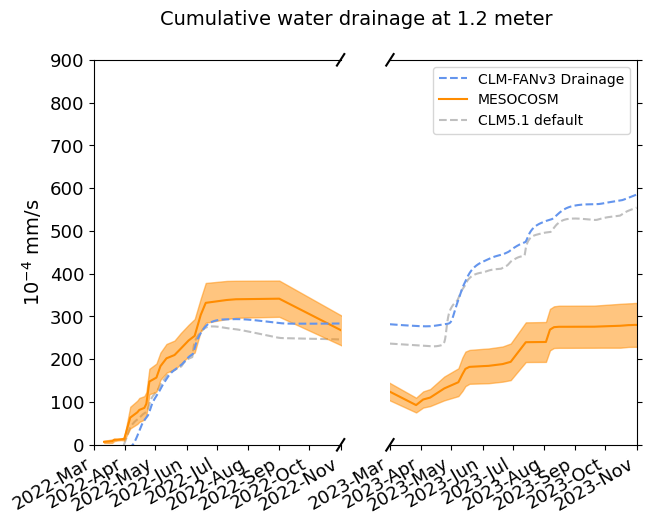

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 5))

ax[0].plot(runoff_sim_cum.time, runoff_sim_cum.values,label='CLM-FANv3 Drainage', ls='--', color='cornflowerblue', zorder=2)
ax[0].plot(runoff_meso_cum.index.values, runoff_meso_cum.values, label='MESOCOSM', color='darkorange', zorder=1)
ax[0].plot(runoff_sim_cum_default.time, runoff_sim_cum_default.values, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[0].fill_between(runoff_meso_cum.index.values, runoff_meso_cum.values + runoff_meso_cum_std.values, runoff_meso_cum.values - runoff_meso_cum_std.values, color='darkorange', alpha=0.5)
ax[1].plot(runoff_sim_cum.time, runoff_sim_cum.values,label='CLM-FANv3 Drainage', ls='--', color='cornflowerblue', zorder=2)
ax[1].plot(runoff_meso_cum.index.values, runoff_meso_cum.values, label='MESOCOSM', color='darkorange', zorder=1)
ax[1].plot(runoff_sim_cum_default.time, runoff_sim_cum_default.values, label='CLM5.1 default', ls='--', color='grey', alpha=0.5, zorder=1)
ax[1].fill_between(runoff_meso_cum.index.values, runoff_meso_cum.values + runoff_meso_cum_std.values, runoff_meso_cum.values - runoff_meso_cum_std.values, color='darkorange', alpha=0.5)
ax[0].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_ylabel("$10^{-4}$ mm/s", size=14)
ax[0].set_ylim(0, 900)
ax[1].set_ylim(0, 900)
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 3, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 3, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("Cumulative water drainage at 1.2 meter", size=14)
#fig.tight_layout()
fig.savefig("finalgraphs/CumulativeDrainage.pdf", format='pdf', bbox_inches='tight')
plt.show()

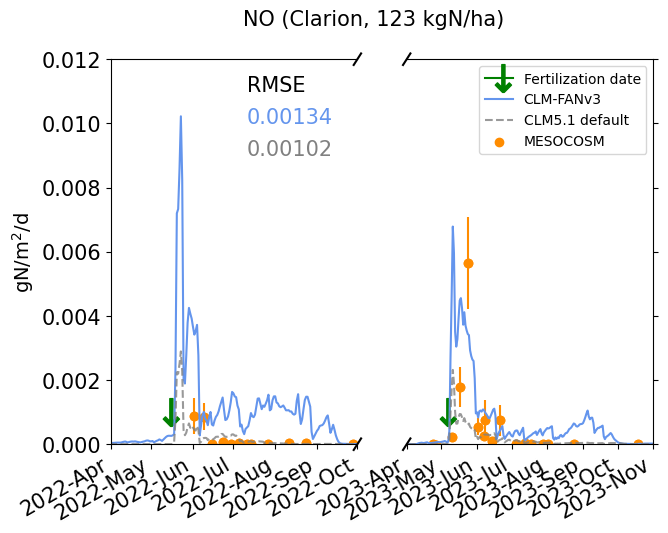

In [18]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022.flatten(), no_time_2023.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].text(no_time_2022[6], 0.011, 'RMSE', size=15)
ax[0].text(no_time_2022[6], 0.010, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022[6], 0.009, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

#ax[0].plot(no_time_2022, mean_dsNO_cla_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[0].fill_between(no_time_2022, min_dsNO_cla_2022.values, max_dsNO_cla_2022.values, alpha=0.3, color='orange')
#ax[0].plot(no_time_2023, mean_dsNO_cla_2023.values, color='darkorange', linewidth=1)
#ax[0].fill_between(no_time_2023, min_dsNO_cla_2023.values, max_dsNO_cla_2023.values, alpha=0.3, color='orange')
#ax[1].plot(no_time_2022, mean_dsNO_cla_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[1].fill_between(no_time_2022, min_dsNO_cla_2022.values, max_dsNO_cla_2022.values, alpha=0.3, color='orange')
#ax[1].plot(no_time_2023, mean_dsNO_cla_2023.values, color='darkorange', linewidth=1)
#ax[1].fill_between(no_time_2023, min_dsNO_cla_2023.values, max_dsNO_cla_2023.values, alpha=0.3, color='orange')

ax[0].scatter(no_time_2022, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(no_time_2022, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.012)
ax[1].set_ylim(0, 0.012)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)
fig.suptitle("NO (Clarion, 123 kgN/ha)",size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_123kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

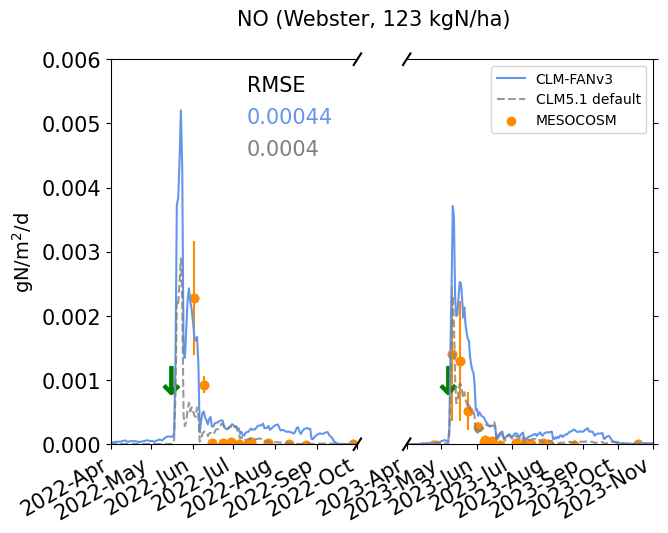

In [19]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022.flatten(), no_time_2023.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green')

ax[0].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].text(no_time_2022[6], 0.0055, 'RMSE', size=15)
ax[0].text(no_time_2022[6], 0.0050, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022[6], 0.0045, round(rmse_default, 5), size=15, color='grey',)

#ax[0].plot(no_time_2022, mean_dsNO_web_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[0].fill_between(no_time_2022, min_dsNO_web_2022.values, max_dsNO_web_2022.values, alpha=0.3, color='orange')
#ax[0].plot(no_time_2023, mean_dsNO_web_2023.values, color='darkorange', linewidth=1)
#ax[0].fill_between(no_time_2023, min_dsNO_web_2023.values, max_dsNO_web_2023.values, alpha=0.3, color='orange')
#ax[1].plot(no_time_2022, mean_dsNO_web_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[1].fill_between(no_time_2022, min_dsNO_web_2022.values, max_dsNO_web_2022.values, alpha=0.3, color='orange')
#ax[1].plot(no_time_2023, mean_dsNO_web_2023.values, color='darkorange', linewidth=1)
#ax[1].fill_between(no_time_2023, min_dsNO_web_2023.values, max_dsNO_web_2023.values, alpha=0.3, color='orange')

ax[0].scatter(no_time_2022, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(no_time_2022, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.006)
ax[1].set_ylim(0, 0.006)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("NO (Webster, 123 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_123kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

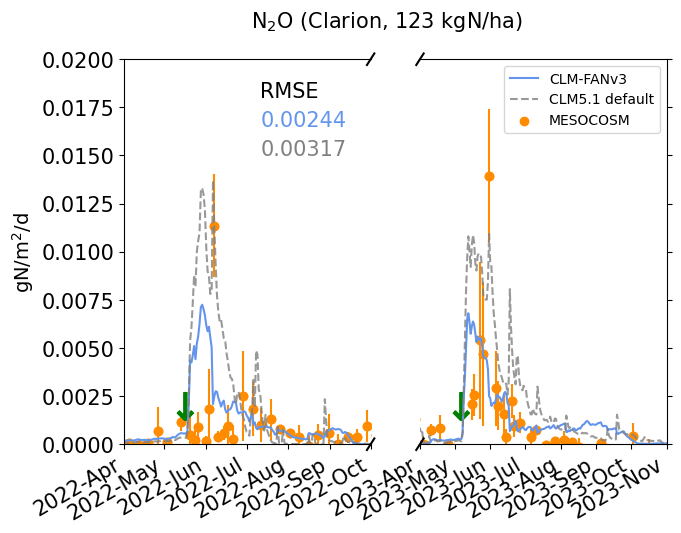

In [20]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022.flatten(), n2o_time_2023.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)

#Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green')

ax[0].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].text(no_time_2022[6], 0.0180, 'RMSE', size=15)
ax[0].text(no_time_2022[6], 0.0165, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022[6], 0.0150, round(rmse_default, 5), size=15, color='grey',)

#ax[0].plot(n2o_time_2022, mean_dsN2O_cla_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[0].fill_between(n2o_time_2022, min_dsN2O_cla_2022.values, max_dsN2O_cla_2022.values, alpha=0.3, color='orange')
#ax[0].plot(n2o_time_2023, mean_dsN2O_cla_2023.values, color='darkorange', linewidth=1)
#ax[0].fill_between(n2o_time_2023, min_dsN2O_cla_2023.values, max_dsN2O_cla_2023.values, alpha=0.3, color='orange')
#ax[1].plot(n2o_time_2022, mean_dsN2O_cla_2022.values, label='observed', color='darkorange', linewidth=1)
#ax[1].fill_between(n2o_time_2022, min_dsN2O_cla_2022.values, max_dsN2O_cla_2022.values, alpha=0.3, color='orange')
#ax[1].plot(n2o_time_2023, mean_dsN2O_cla_2023.values, color='darkorange', linewidth=1)
#ax[1].fill_between(n2o_time_2023, min_dsN2O_cla_2023.values, max_dsN2O_cla_2023.values, alpha=0.3, color='orange')

ax[0].scatter(n2o_time_2022, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(n2o_time_2022, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.020)
ax[1].set_ylim(0, 0.020)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = 0.015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Clarion, 123 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_123kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

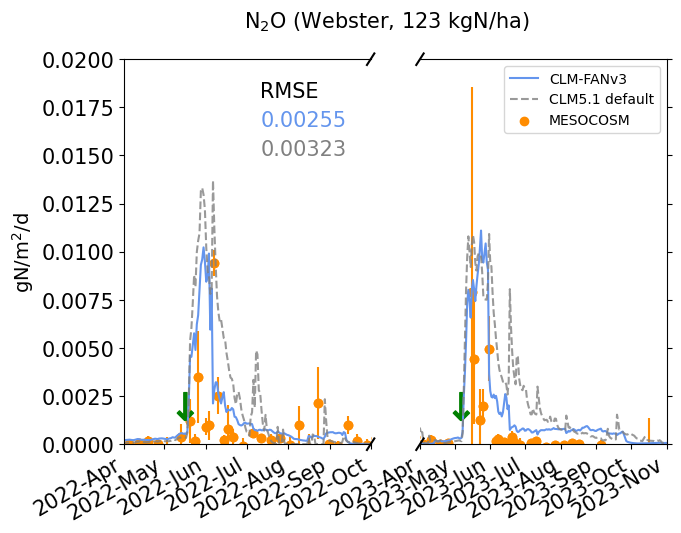

In [21]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022.flatten(), n2o_time_2023.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)

#Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green')

ax[0].text(no_time_2022[6], 0.0180, 'RMSE', size=15)
ax[0].text(no_time_2022[6], 0.0165, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022[6], 0.0150, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(n2o_time_2022, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(n2o_time_2022, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.020)
ax[1].set_ylim(0, 0.020)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = 0.015
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Webster, 123 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_123kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [22]:
h2o_sim_daily = dsCLM_Clarion['WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
h2o_sim_daily = h2o_sim_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
nh4_Clarion_daily = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion_daily = nh4_Clarion_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
no3_Clarion_daily = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion_daily = no3_Clarion_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit = dsCLM_Clarion['F_NIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit = f_nit.sel(levdcmp=[0.09]).mean(dim='levdcmp')
f_denit = dsCLM_Clarion['F_DENIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_denit = f_denit.sel(levdcmp=[0.09]).mean(dim='levdcmp')

h2o_sim_daily_default = dsCLM_Default['WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
h2o_sim_daily_default = h2o_sim_daily_default.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
nh4_Default_daily = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Default_daily = nh4_Default_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
no3_Default_daily = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Default_daily = no3_Default_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit_default = dsCLM_Default['F_NIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit_default = f_nit_default.sel(levdcmp=[0.09]).mean(dim='levdcmp')
f_denit_default = dsCLM_Default['F_DENIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_denit_default = f_denit_default.sel(levdcmp=[0.09]).mean(dim='levdcmp')

x_data = np.ravel(h2o_sim_daily.values)
y_nitdata = np.ravel(f_nit.values)
y_denitdata = np.ravel(f_denit.values)

x_data_default = np.ravel(h2o_sim_daily_default.values)
y_nitdata_default = np.ravel(f_nit_default.values)
y_denitdata_default = np.ravel(f_denit_default.values)

plot_x = np.linspace(0, 100, 100)

def gaussian(x, a, b, c):
    return a * np.exp(-((x - b)**2) / (2 * c**2))


#popt_nit, pcov_nit = curve_fit(gaussian, x_data, y_nitdata, p0=[1e-6, 40, 1])
#popt_denit, pcov_denit = curve_fit(gaussian, x_data, y_denitdata, p0=[1e-6, 40, 1])
#popt_nit_default, pcov_nit_default = curve_fit(gaussian, x_data_default, y_nitdata_default, p0=[1e-6, 80, 2])
#popt_denit_default, pcov_denit_default = curve_fit(gaussian, x_data_default, y_denitdata_default, p0=[1e-6, 80, 2])

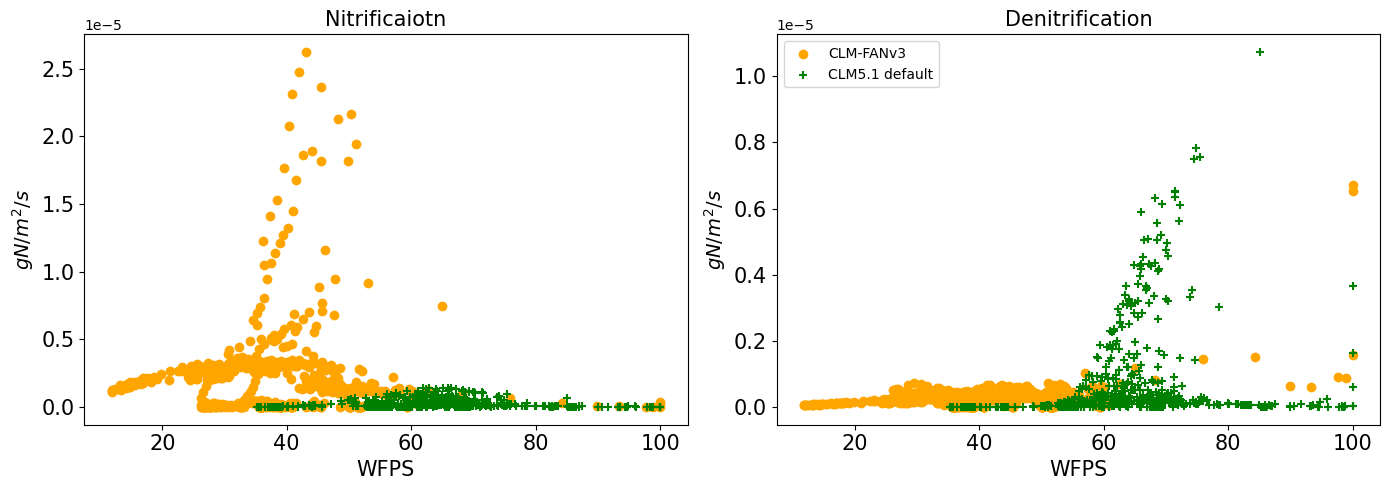

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(x_data, y_nitdata, color='orange', zorder=1)
ax[1].scatter(x_data, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)
#ax[0].plot(plot_x, gaussian(plot_x, *popt_nit), color='red', zorder=2)
#ax[1].plot(plot_x, gaussian(plot_x, *popt_denit), color='red', zorder=2)

ax[0].scatter(x_data_default, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(x_data_default, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)
#ax[0].plot(plot_x, gaussian(plot_x, *popt_nit_default), color='blue', zorder=2)
#ax[1].plot(plot_x, gaussian(plot_x, *popt_denit_default), color='blue', zorder=2)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("WFPS", size=15)
ax[1].set_xlabel("WFPS", size=15)
ax[0].set_ylabel("$gN/m^2/s$", size=14)
ax[1].set_ylabel("$gN/m^2/s$", size=14)
#ax[0].set_ylim(0, 2e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()

fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_WFPS.pdf", format='pdf')

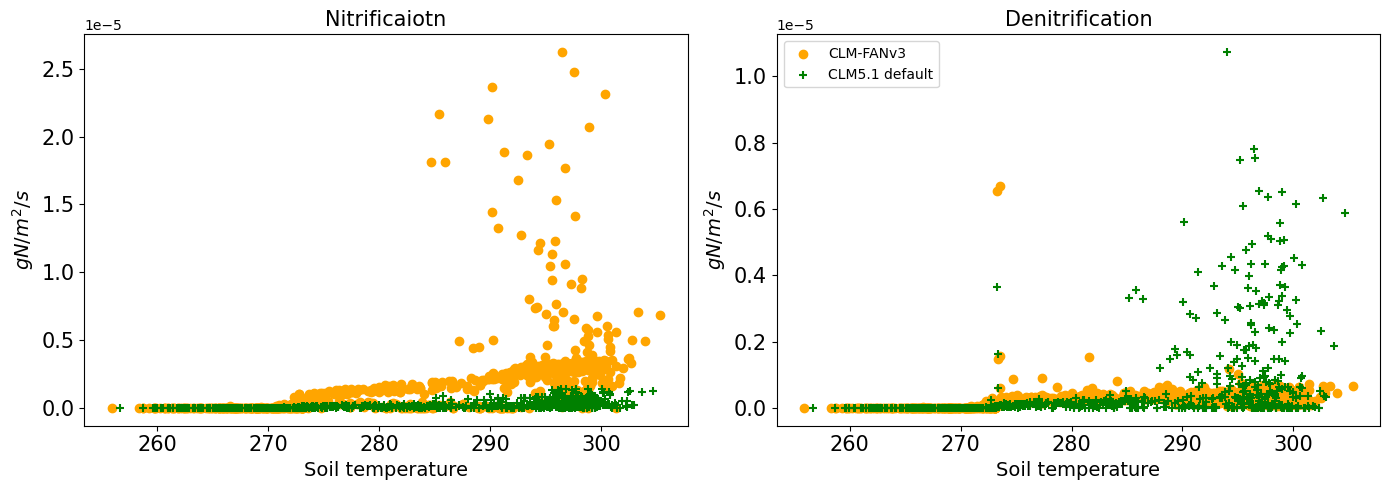

In [24]:
tem_sim = dsCLM_Clarion['TSOI_10CM']
tem_sim = tem_sim.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
tem_sim_default = dsCLM_Default['TSOI_10CM']
tem_sim_default = tem_sim_default.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(tem_sim.values, y_nitdata, color='orange', zorder=1)
ax[1].scatter(tem_sim.values, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)

ax[0].scatter(tem_sim_default.values, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(tem_sim_default.values, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("Soil temperature", size=14)
ax[1].set_xlabel("Soil temperature", size=14)
ax[0].set_ylabel("$gN/m^2/s$", size=14)
ax[1].set_ylabel("$gN/m^2/s$", size=14)
#ax[0].set_ylim(0, 2e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()
fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_Temperature.pdf", format='pdf')

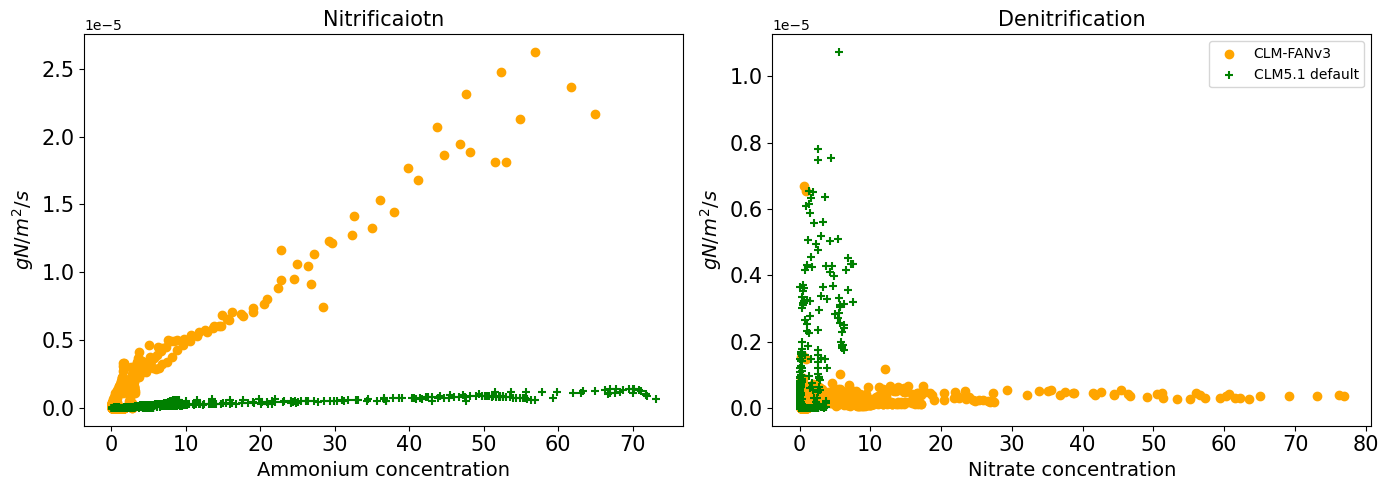

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nh4_Clarion_daily.values, y_nitdata, color='orange', zorder=1)
ax[1].scatter(no3_Clarion_daily.values, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)

ax[0].scatter(nh4_Default_daily.values, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(no3_Default_daily.values, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("Ammonium concentration", size=14)
ax[1].set_xlabel("Nitrate concentration", size=14)
ax[0].set_ylabel("$gN/m^2/s$", size=14)
ax[1].set_ylabel("$gN/m^2/s$", size=14)
#ax[0].set_ylim(0, 1e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()
fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_concentration.pdf", format='pdf')

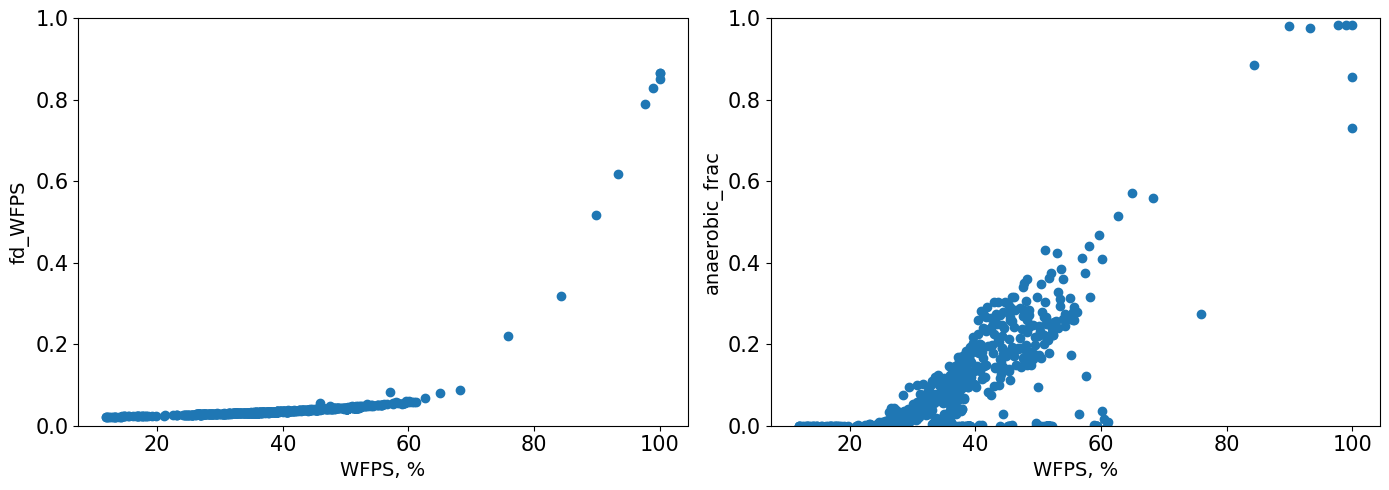

In [26]:
fdWFPS = dsCLM_Clarion['fd_WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
fdWFPS = fdWFPS .resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
anaerobic_frac = dsCLM_Clarion['anaerobic_frac'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
anaerobic_frac = anaerobic_frac .resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(x_data, fdWFPS.values)
ax[0].set_ylim(0, 1.0)
ax[0].set_xlabel("WFPS, %", size=14)
ax[0].set_ylabel("fd_WFPS", size=14)
ax[1].scatter(x_data, anaerobic_frac.values)
ax[1].set_ylim(0, 1.0)
ax[1].set_xlabel("WFPS, %", size=14)
ax[1].set_ylabel("anaerobic_frac", size=14)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

fig.tight_layout()
fig.savefig("finalgraphs/WaterLimitationFunctions.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_203897/1837450250.py:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()


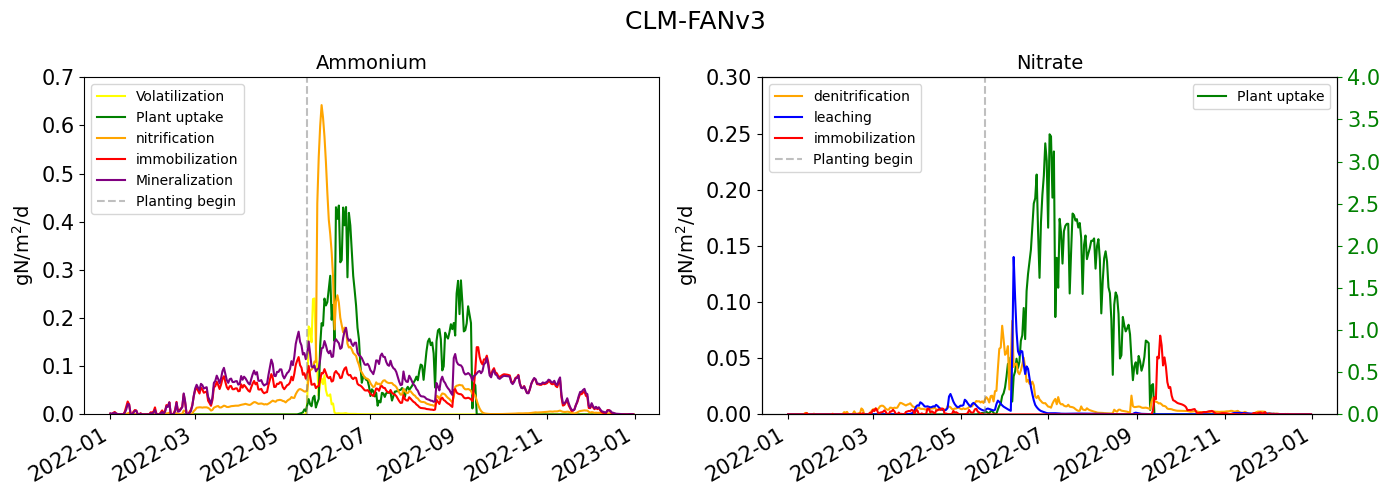

In [27]:
vola_nh4 = (dsCLM_Clarion['NH3_TOTAL'] + dsCLM_Webster['NH3_TOTAL'])/2
vola_nh4 = vola_nh4.sel(time='2022').resample(time='D').mean()
nh4_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'])/2
nh4_plant = nh4_plant.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
no3_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'])/2
no3_plant = no3_plant.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_nh4 = (dsCLM_Webster['ACTUAL_IMMOB_NH4'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2'])/2
immob_nh4 = immob_nh4.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_no3 = (dsCLM_Webster['ACTUAL_IMMOB_NO3'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2'])
immob_no3 = immob_no3.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
Total_N_runoff = (dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED'] 
            + dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED'])/2
Total_N_runoff = Total_N_runoff.sel(time='2022').resample(time='D').mean()
nit = (dsCLM_Webster['F_NIT'] + dsCLM_Clarion['F_NIT'])/2
nit = nit.sel(time='2022').resample(time='D').mean()
denit = (dsCLM_Webster['F_DENIT'] + dsCLM_Clarion['F_DENIT'])/2
denit = denit.sel(time='2022').resample(time='D').mean()
gross_nmin = (dsCLM_Webster['GROSS_NMIN'] + dsCLM_Clarion['GROSS_NMIN'])/2
gross_nmin = gross_nmin.sel(time='2022').resample(time='D').mean()
plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()

# unit gN/m2/s to gN/m2/day
to_perday = 24*3600

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='Volatilization', color='yellow')
ax[0].plot(plot_time, nh4_plant.values*to_perday, label='Plant uptake', color='green')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='orange')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='red')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='purple')
ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 0.7)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
    
ax1 = ax[1].twinx()
ax1.plot(plot_time, no3_plant.values*to_perday, label='Plant uptake', color='green')
ax1.set_ylim(0, 4)
ax1.tick_params(axis='y', colors='green', labelsize=15)
ax1.legend(loc='upper right')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='orange')
ax[1].plot(plot_time, Total_N_runoff.values*to_perday, label='leaching', color='blue')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='red')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/m$^2$/d', size=14)
ax[1].set_ylim(0, 0.3)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
fig.suptitle(' CLM-FANv3 ', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLMFANv3Nitrogenflows123KgN.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_203897/1213991423.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()


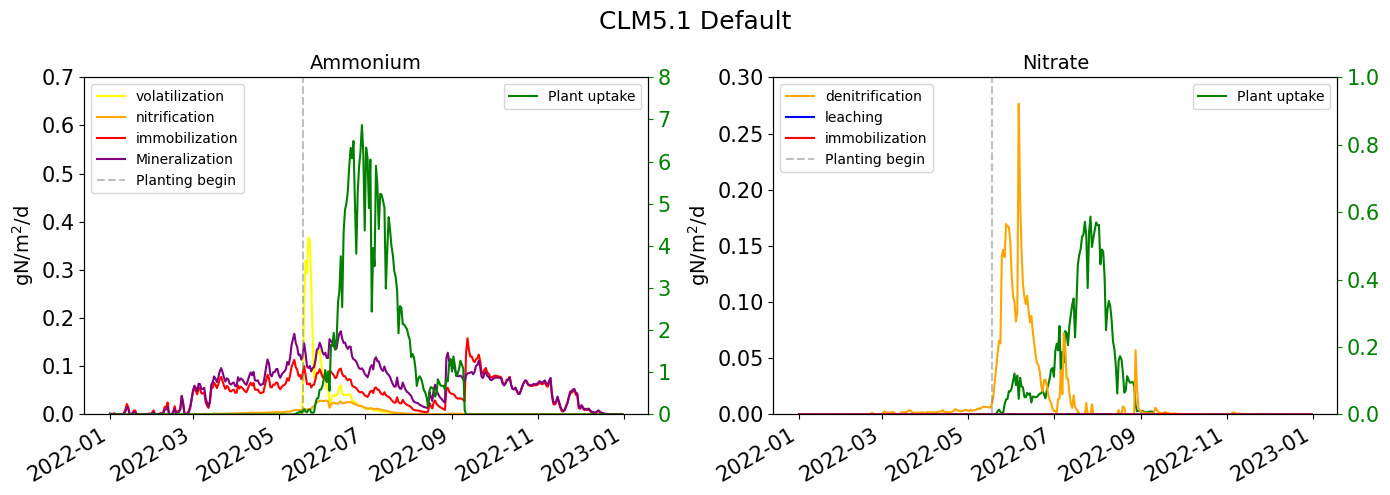

In [28]:
vola_nh4 = dsCLM_Default['NH3_TOTAL'].sel(time='2022').resample(time='D').mean()
nh4_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
no3_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_nh4 = (dsCLM_Default['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_no3 = (dsCLM_Default['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
Total_N_runoff_web = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']
Total_N_runoff_web = Total_N_runoff_web.sel(time='2022').resample(time='D').mean()
nit = dsCLM_Default['F_NIT'].sel(time='2022').resample(time='D').mean()
denit = dsCLM_Default['F_DENIT'].sel(time='2022').resample(time='D').mean()
gross_nmin = dsCLM_Default['GROSS_NMIN'].sel(time='2022').resample(time='D').mean()
plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='volatilization', color='yellow')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='orange')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='red')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='purple')
ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 0.7)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1 = ax[0].twinx()
ax1.plot(plot_time, nh4_plant_web.values*to_perday, label='Plant uptake', color='green')
ax1.set_ylim(0, 8)
ax1.tick_params(axis='y', colors='green', labelsize=15)
ax1.legend(loc='upper right')

ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='orange')
ax[1].plot(plot_time, Total_N_runoff_web.values*to_perday, label='leaching', color='blue')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='red')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='Planting begin')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/m$^2$/d', size=14)
ax[1].set_ylim(0, 0.3)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2 = ax[1].twinx()
ax2.plot(plot_time, no3_plant_web.values*to_perday, label='Plant uptake', color='green')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='y', colors='green', labelsize=15)
ax2.legend(loc='upper right')

fig.suptitle('CLM5.1 Default', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLM5.1DefaultNitrogenflows123KgN.pdf", format='pdf')
plt.show()

### 168 kgN fertilizer experiment

In [29]:
fert_amount = "168"
case_clarion = "clarion" + fert_amount + "kgN"
case_webster = "webster" + fert_amount + "kgN"
path_clarion = "/glade/derecho/scratch/jinmuluo/archive/clarion168kgN05gC/lnd/hist/" 
path_webster = "/glade/derecho/scratch/jinmuluo/archive/webster168kgN05gC/lnd/hist/" 
path_default = "/glade/derecho/scratch/jinmuluo/archive/DefaultCLMatMESOCOSM168kgN/lnd/hist/" 

start_date = date(2022, 1, 1)
end_date = date(2023, 12, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'TOTSOMC_1m', 'TOTSOMN_1m',
          'RAIN', 'QDRAI', 'QOVER', 'QOUT120cm', 'H2OSOI', 'SOILLIQ', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'SMINN_TO_PLANT_FUN', 
          'F_NIT', 'F_NIT_vr', 'F_DENIT', 'F_DENIT_vr', 'GROSS_NMIN', 'GROSS_NMIN_vr', 'ACTUAL_IMMOB_NH4', 'ACTUAL_IMMOB_NO3',
         'LEAFN', 'LIVESTEMN', 'FROOTN', 'LIVECROOTN', 'GRAINN', 'CROPPROD1N',
         'WFPS', 'n2_n2o_ratio_denit', 'ratio_nox_n2o', 'anaerobic_frac', 'fd_WFPS']

CLM_Clarion = []
CLM_Webster = []
CLM_Default = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Default.append(path_default + "DefaultCLMatMESOCOSM" + ".clm2." + "h1" + "." + currdate + "-00000.nc" )

In [30]:
def preprocess(ds, fields= NInput + GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)
dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)
dsCLM_Default = xr.open_mfdataset(CLM_Default, decode_times=True, preprocess=preprocess)

x = np.zeros(len(dsCLM_Clarion['levsoi']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levsoi'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levsoi'][i].values - dsCLM_Clarion['levsoi'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth=(dsCLM_Clarion['levsoi'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth=(dsCLM_Webster['levsoi'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth=(dsCLM_Default['levsoi'].coords, x))

x = np.zeros(len(dsCLM_Clarion['levdcmp']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levdcmp'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levdcmp'][i].values - dsCLM_Clarion['levdcmp'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth2=(dsCLM_Clarion['levdcmp'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth2=(dsCLM_Webster['levdcmp'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth2=(dsCLM_Default['levdcmp'].coords, x))

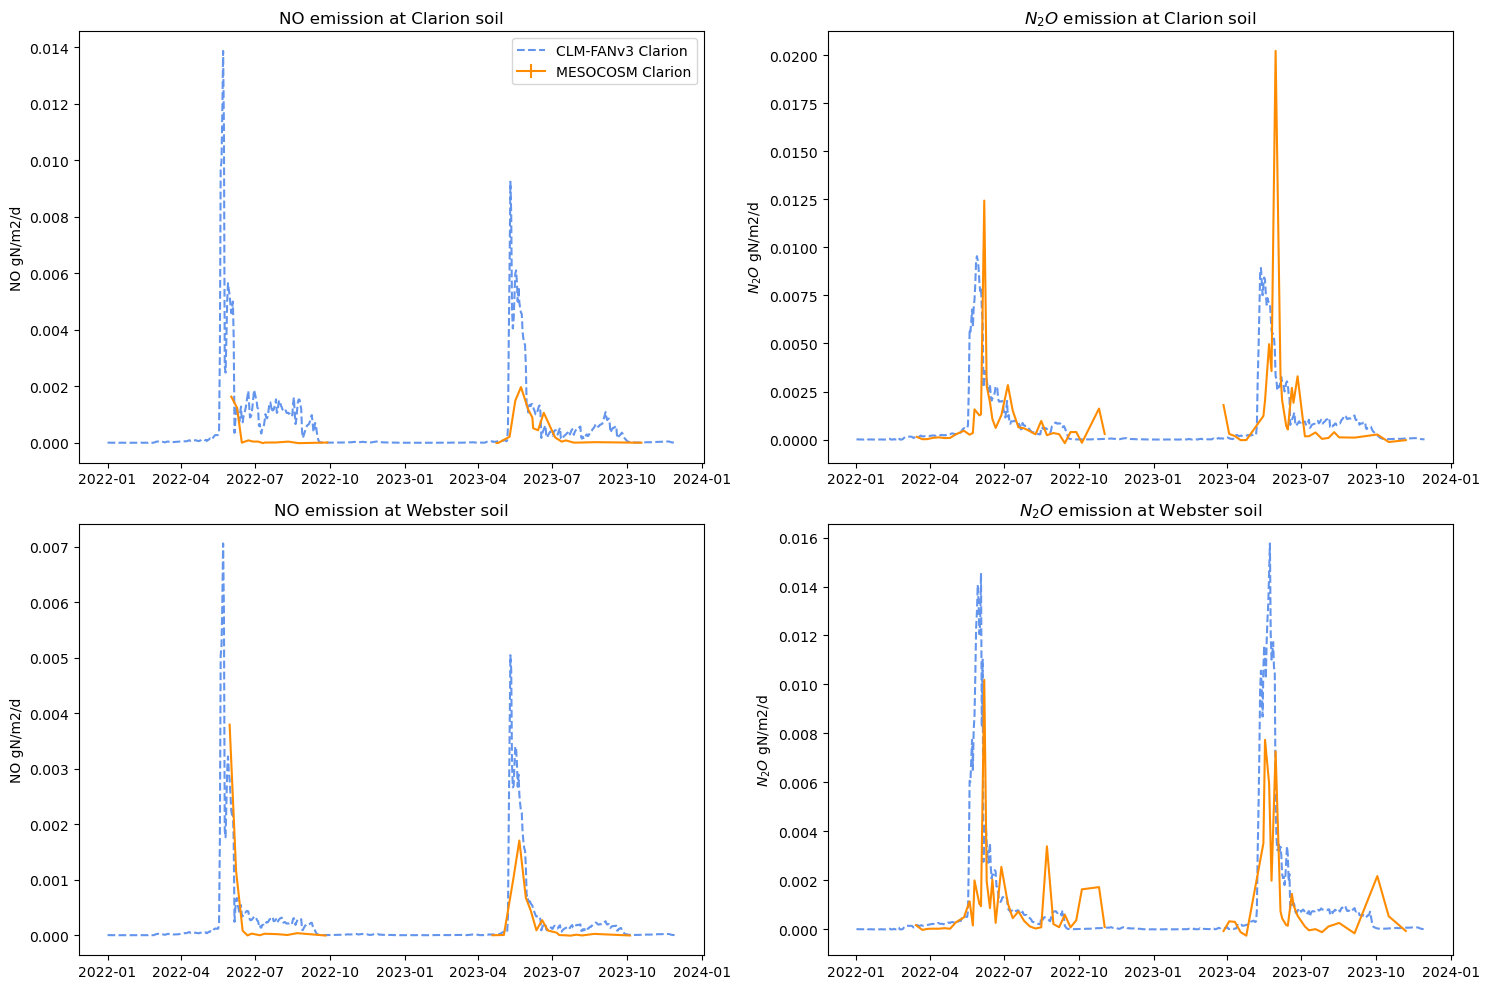

In [31]:
# Read the mesocsom measurements
p2 = "/glade/work/jinmuluo/MESONET/measurements/2023data/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022_2023.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'soil_gas_fluxes_combined_2022_2023_control.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

mean_dsNO_cla = dsNO.loc[('Clarion', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_cla_2023 = mean_dsNO_cla.loc[mean_dsNO_cla.index > "2023-01-01"]
mean_dsNO_cla_2022 = mean_dsNO_cla.loc[mean_dsNO_cla.index < "2023-01-01"]
std_dsNO_cla = dsNO.loc[('Clarion', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_cla_2023 = std_dsNO_cla.loc[std_dsNO_cla.index > "2023-01-01"]
std_dsNO_cla_2022 = std_dsNO_cla.loc[std_dsNO_cla.index < "2023-01-01"]
min_dsNO_cla = dsNO.loc[('Clarion', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_cla_2023 = min_dsNO_cla.loc[min_dsNO_cla.index > "2023-01-01"]
min_dsNO_cla_2022 = min_dsNO_cla.loc[min_dsNO_cla.index < "2023-01-01"]
max_dsNO_cla = dsNO.loc[('Clarion', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_cla_2023 = max_dsNO_cla.loc[max_dsNO_cla.index > "2023-01-01"]
max_dsNO_cla_2022 = max_dsNO_cla.loc[max_dsNO_cla.index < "2023-01-01"]
mean_dsNO_web = dsNO.loc[('Webster', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_web_2023 = mean_dsNO_web.loc[mean_dsNO_web.index > "2023-01-01"]
mean_dsNO_web_2022 = mean_dsNO_web.loc[mean_dsNO_web.index < "2023-01-01"]
std_dsNO_web = dsNO.loc[('Webster', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_web_2023 = std_dsNO_web.loc[std_dsNO_web.index > "2023-01-01"]
std_dsNO_web_2022 = std_dsNO_web.loc[std_dsNO_web.index < "2023-01-01"]
min_dsNO_web = dsNO.loc[('Webster', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_web_2023 = min_dsNO_web.loc[min_dsNO_web.index > "2023-01-01"]
min_dsNO_web_2022 = min_dsNO_web.loc[min_dsNO_web.index < "2023-01-01"]
max_dsNO_web = dsNO.loc[('Webster', 168), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_web_2023 = max_dsNO_web.loc[max_dsNO_web.index > "2023-01-01"]
max_dsNO_web_2022 = max_dsNO_web.loc[max_dsNO_web.index < "2023-01-01"]
mean_dsN2O_cla = dsN2O.loc[('Clarion', 168), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_cla_2023 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index > "2023-01-01"]
mean_dsN2O_cla_2022 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index < "2023-01-01"]
std_dsN2O_cla = dsN2O.loc[('Clarion', 168), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_cla_2023 = std_dsN2O_cla.loc[std_dsN2O_cla.index > "2023-01-01"]
std_dsN2O_cla_2022 = std_dsN2O_cla.loc[std_dsN2O_cla.index < "2023-01-01"]
min_dsN2O_cla = dsN2O.loc[('Clarion', 168), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_cla_2023 = min_dsN2O_cla.loc[min_dsN2O_cla.index > "2023-01-01"]
min_dsN2O_cla_2022 = min_dsN2O_cla.loc[min_dsN2O_cla.index < "2023-01-01"]
max_dsN2O_cla = dsN2O.loc[('Clarion', 168), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_cla_2023 = max_dsN2O_cla.loc[max_dsN2O_cla.index > "2023-01-01"]
max_dsN2O_cla_2022 = max_dsN2O_cla.loc[max_dsN2O_cla.index < "2023-01-01"]
mean_dsN2O_web = dsN2O.loc[('Webster', 168), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_web_2023 = mean_dsN2O_web.loc[mean_dsN2O_web.index > "2023-01-01"]
mean_dsN2O_web_2022 = mean_dsN2O_web.loc[mean_dsN2O_web.index < "2023-01-01"]
std_dsN2O_web = dsN2O.loc[('Webster', 168), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_web_2023 = std_dsN2O_web.loc[std_dsN2O_web.index > "2023-01-01"]
std_dsN2O_web_2022 = std_dsN2O_web.loc[std_dsN2O_web.index < "2023-01-01"]
min_dsN2O_web = dsN2O.loc[('Webster', 168), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_web_2023 = min_dsN2O_web.loc[min_dsN2O_web.index > "2023-01-01"]
min_dsN2O_web_2022 = min_dsN2O_web.loc[min_dsN2O_web.index < "2023-01-01"]
max_dsN2O_web = dsN2O.loc[('Webster', 168), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_web_2023 = max_dsN2O_web.loc[max_dsN2O_web.index > "2023-01-01"]
max_dsN2O_web_2022 = max_dsN2O_web.loc[max_dsN2O_web.index < "2023-01-01"]
no_time_2023_cla = mean_dsNO_cla_2023.index.values
n2o_time_2023_cla = mean_dsN2O_cla_2023.index.values
no_time_2023_web = mean_dsNO_web_2023.index.values
n2o_time_2023_web = mean_dsN2O_web_2023.index.values
no_time_2022_cla = mean_dsNO_cla_2022.index.values
n2o_time_2022_cla = mean_dsN2O_cla_2022.index.values
no_time_2022_web = mean_dsNO_web_2022.index.values
n2o_time_2022_web = mean_dsN2O_web_2022.index.values


# Read the CLM model simulations
NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Webster.time]
NO_Default = (dsCLM_Default.NOx_NITRIFY_TOTAL + dsCLM_Default.NOx_DENITRIFY_TOTAL + dsCLM_Default.F_NOx_NIT + dsCLM_Default.F_NOx_DENIT)
NO_Default = NO_Default.resample(time='D').mean()*24*3600
NO_Default.attrs['units'] = "gN/m2/d"
NO_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Default.time]

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Webster.time]
N2O_Default = (dsCLM_Default.N2O_NITRIFY_TOTAL + dsCLM_Default.F_N2O_NIT + dsCLM_Default.N2O_DENITRIFY_TOTAL+ dsCLM_Default.F_N2O_DENIT)
N2O_Default = N2O_Default.resample(time='D').mean()*24*3600
N2O_Default.attrs['units'] = "gN/m2/d"
N2O_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Default.time]

NH3_Clarion = dsCLM_Clarion.NH3_TOTAL
NH3_Clarion = NH3_Clarion.resample(time='D').mean()*24*3600
NH3_Clarion.attrs['units'] = "gN/m2/d"
NH3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Clarion.time]
NH3_Webster = dsCLM_Webster.NH3_TOTAL
NH3_Webster = NH3_Webster.resample(time='D').mean()*24*3600
NH3_Webster.attrs['units'] = "gN/m2/d"
NH3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Webster.time]
NH3_Default = dsCLM_Default.NH3_TOTAL
NH3_Default = NH3_Default.resample(time='D').mean()*24*3600
NH3_Default.attrs['units'] = "gN/m2/d"
NH3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Default.time]

# Plot the graph
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(NO_Clarion.time, NO_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion', color='cornflowerblue')
ax[1, 0].plot(NO_Webster.time, NO_Webster.values, linestyle='--', label='CLM-FANv3 Webster', color='cornflowerblue')

#ax[0, 0].errorbar(no_time_2022, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 0].errorbar(no_time_2022, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, label='MESOCOSM Webster', color='darkorange')
#ax[0, 0].errorbar(no_time_2023, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 0].errorbar(no_time_2023, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, label='MESOCOSM Webster', color='darkorange')

ax[0, 0].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=0, label='MESOCOSM Clarion', color='darkorange')
ax[1, 0].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=0, label='MESOCOSM Webster', color='darkorange')
ax[0, 0].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=0, color='darkorange')
ax[1, 0].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=0, color='darkorange')

ax[0, 0].legend()
ax[0, 0].set_title("NO emission at Clarion soil")
ax[0, 1].set_title("$N_2O$ emission at Clarion soil")
ax[0, 0].set_ylabel("NO gN/m2/d")
ax[0, 1].set_ylabel("$N_2O$ gN/m2/d")

ax[0, 1].plot(N2O_Clarion.time, N2O_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion', color='cornflowerblue')
ax[1, 1].plot(N2O_Webster.time, N2O_Webster.values, linestyle='--', label='CLM-FANv3 Webster', color='cornflowerblue')

#ax[0, 1].errorbar(n2o_time_2022, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 1].errorbar(n2o_time_2022, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, label='MESOCOSM Webster', color='darkorange')
#ax[0, 1].errorbar(n2o_time_2023, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 1].errorbar(n2o_time_2023, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, label='MESOCOSM Webster', color='darkorange')

ax[0, 1].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=0, label='MESOCOSM Clarion', color='darkorange')
ax[1, 1].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=0, label='MESOCOSM Webster', color='darkorange')
ax[0, 1].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=0, color='darkorange')
ax[1, 1].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=0, color='darkorange')

ax[1, 0].set_title("NO emission at Webster soil")
ax[1, 1].set_title("$N_2O$ emission at Webster soil")
ax[1, 0].set_ylabel("NO gN/m2/d")
ax[1, 1].set_ylabel("$N_2O$ gN/m2/d")
fig.tight_layout()
fig.savefig("graphs/Ngas_168kgN_combined.jpg", dpi=300)
plt.show()

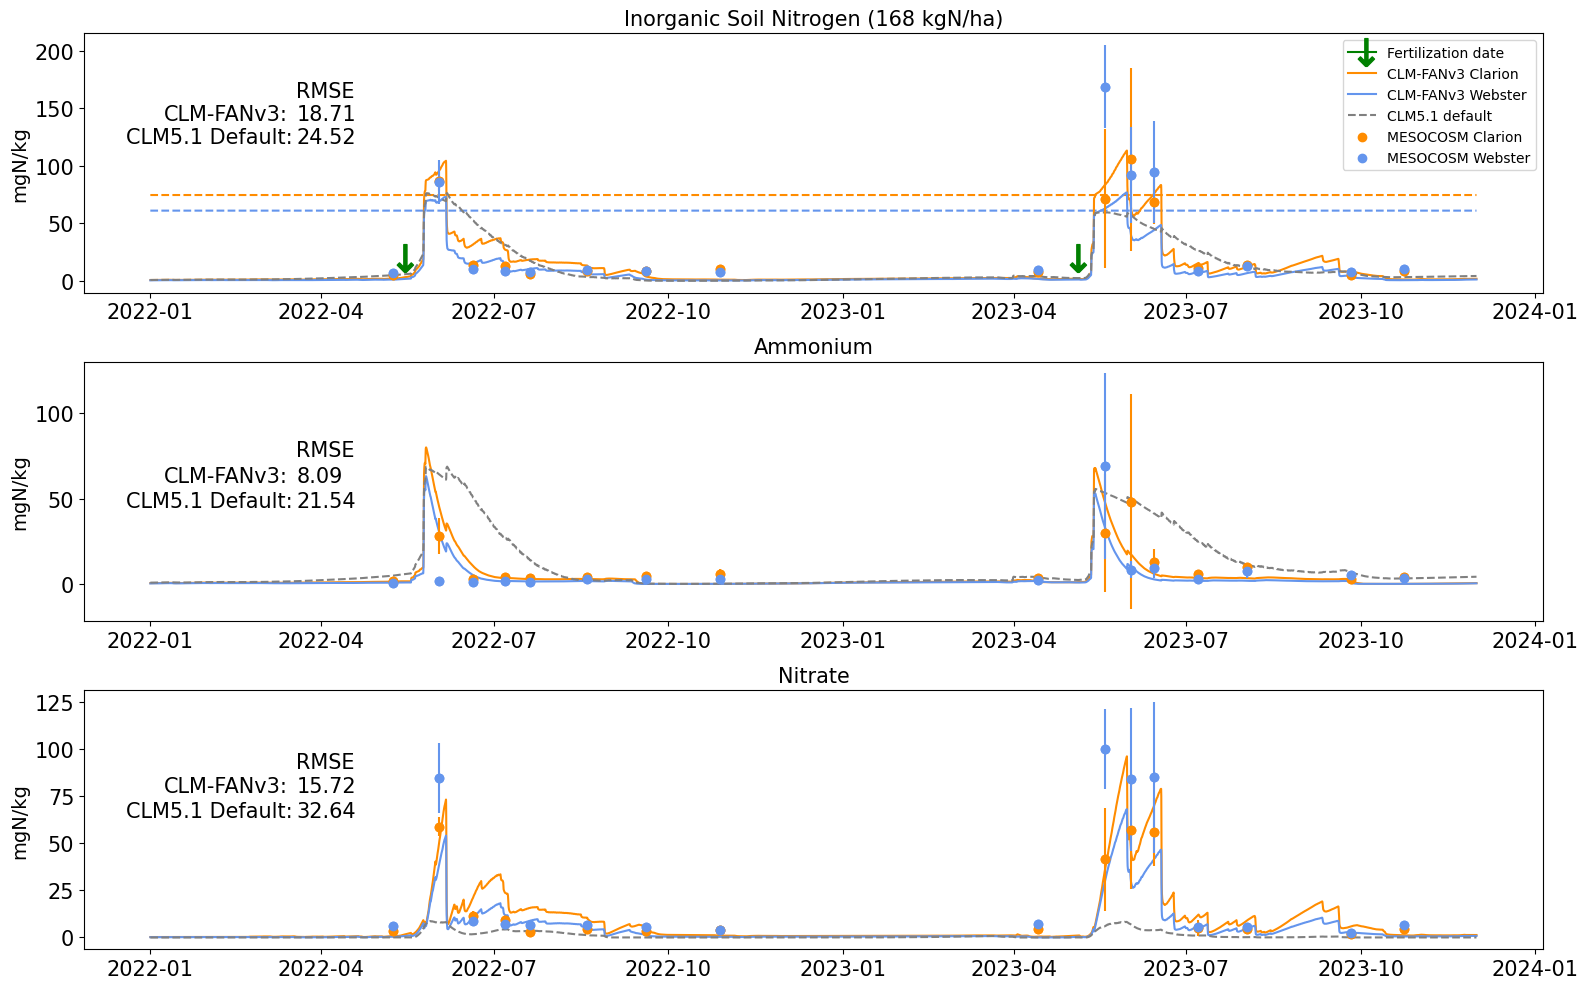

In [32]:
# Read the mesocosm measurement
fert_date = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")
dsMESOCOSM = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2023data/soil_inorganic_N_combined_2022_2023_control.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

sminn_cla = dsMESOCOSM.loc[('Clarion', 168), 'soil_sminn'].groupby(level='date').mean()
sminn_cla = sminn_cla.loc[sminn_cla.index > "2022-01-01"]
sminn_cla_std = dsMESOCOSM.loc[('Clarion', 168), 'soil_sminn'].groupby(level='date').std()
sminn_cla_std = sminn_cla_std.loc[sminn_cla_std.index > "2022-01-01"]
sminn_web = dsMESOCOSM.loc[('Webster', 168), 'soil_sminn'].groupby(level='date').mean()
sminn_web = sminn_web.loc[sminn_web.index > "2022-01-01"]
sminn_web_std = dsMESOCOSM.loc[('Webster', 168), 'soil_sminn'].groupby(level='date').std()
sminn_web_std = sminn_web_std.loc[sminn_web_std.index > "2022-01-01"]
nh4_cla = dsMESOCOSM.loc[('Clarion', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_cla = nh4_cla.loc[nh4_cla.index > "2022-01-01"]
nh4_cla_std = dsMESOCOSM.loc[('Clarion', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_cla_std = nh4_cla_std.loc[nh4_cla_std.index > "2022-01-01"]
nh4_web = dsMESOCOSM.loc[('Webster', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_web = nh4_web.loc[nh4_web.index > "2022-01-01"]
nh4_web_std = dsMESOCOSM.loc[('Webster', 168), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_web_std = nh4_web_std.loc[nh4_web_std.index > "2022-01-01"]
no3_cla = dsMESOCOSM.loc[('Clarion', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_cla = no3_cla.loc[no3_cla.index > "2022-01-01"]
no3_cla_std = dsMESOCOSM.loc[('Clarion', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_cla_std = no3_cla_std.loc[no3_cla_std.index > "2022-01-01"]
no3_web = dsMESOCOSM.loc[('Webster', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_web = no3_web.loc[no3_web.index > "2022-01-01"]
no3_web_std = dsMESOCOSM.loc[('Webster', 168), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_web_std = no3_web_std.loc[no3_web_std.index > "2022-01-01"]
plot_time = no3_web.index.values

# Read the CLM simulation results
sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Default = dsCLM_Default['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

## gN/m3 to mgN/kg at the top 9 cm soil, soil bulk density from Steven Hall, CLM uses soil density 2650
sminn_Clarion = sminn_Clarion*1000/1125
sminn_Webster = sminn_Webster*1000/1375
sminn_Default = sminn_Default*1000/1375

sminn_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Clarion.time]
sminn_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Webster.time]
sminn_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Default.time]
## gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc_cla = 16.8*1000/0.2/1125
fert_conc_web = 16.8*1000/0.2/1375

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Default["FAN_TOTN"].values - dsCLM_Default["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Default = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion = nh4_Clarion*1000/1125
nh4_Webster = nh4_Webster*1000/1375
nh4_Default = nh4_Default*1000/1375
nh4_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Clarion.time]
nh4_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Webster.time]
nh4_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Default.time]

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Default["NITRATE_TOTN"].values
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Default = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/1125
no3_Webster = no3_Webster*1000/1375
no3_Default = no3_Default*1000/1375
no3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Clarion.time]
no3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Webster.time]
no3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Default.time]

# RMSE Calculations for concentrations.
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(plot_time)]
rmse_n_model = cal_rmse((sminn_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                         + sminn_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                        (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_model = cal_rmse((nh4_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + nh4_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (nh4_cla.values + nh4_web.values)/2)
rmse_no3_model = cal_rmse((no3_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + no3_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (no3_cla.values + no3_web.values)/2)

rmse_n_default = cal_rmse(sminn_Default.sel(time=sample_time, method='nearest').values.flatten(), (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_default = cal_rmse(nh4_Default.sel(time=sample_time, method='nearest').values.flatten(), (nh4_cla.values + nh4_web.values)/2)
rmse_no3_default = cal_rmse(no3_Default.sel(time=sample_time, method='nearest').values.flatten(), (no3_cla.values + no3_web.values)/2)

# graph
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
# theoretical values
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_cla, color='darkorange', linestyle='--')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_web, color='cornflowerblue', linestyle='--')

# fertilisation date
ax[0].plot(fert_date_2022 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green')
ax[0].plot(fert_date_2023 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].plot(sminn_Clarion.time, sminn_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[0].plot(sminn_Webster.time, sminn_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[0].plot(sminn_Default.time, sminn_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[0].scatter(plot_time, sminn_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[0].scatter(plot_time, sminn_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[0].errorbar(plot_time, sminn_cla.values, yerr=sminn_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[0].errorbar(plot_time, sminn_web.values, yerr=sminn_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title("Inorganic Soil Nitrogen (168 kgN/ha)", size=15)
ax[0].set_ylabel("mgN/kg", size=14)
ax[0].text(fert_date_2022 - 60, 160, "RMSE", size=15)
ax[0].text(fert_date_2022 - 130, 140, "CLM-FANv3:", size=15)
ax[0].text(fert_date_2022 - 150, 120, "CLM5.1 Default:", size=15)
ax[0].text(fert_date_2022 - 60, 140, round(rmse_n_model, 2), size=15)
ax[0].text(fert_date_2022 - 60, 120, round(rmse_n_default, 2), size=15)
ax[0].legend(loc="upper right")

ax[1].plot(sminn_Clarion.time, nh4_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[1].plot(sminn_Webster.time, nh4_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].plot(sminn_Default.time, nh4_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[1].scatter(plot_time, nh4_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[1].scatter(plot_time, nh4_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[1].errorbar(plot_time, nh4_cla.values, yerr=nh4_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[1].errorbar(plot_time, nh4_web.values, yerr=nh4_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title("Ammonium", size=15)
ax[1].set_ylabel("mgN/kg", size=14)
ax[1].text(fert_date_2022 - 60, 75, "RMSE", size=15)
ax[1].text(fert_date_2022 - 130, 60, "CLM-FANv3:", size=15)
ax[1].text(fert_date_2022 - 150, 45, "CLM5.1 Default:", size=15)
ax[1].text(fert_date_2022 - 60, 60, round(rmse_nh4_model, 2), size=15)
ax[1].text(fert_date_2022 - 60, 45, round(rmse_nh4_default, 2), size=15)

ax[2].plot(sminn_Clarion.time, no3_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[2].plot(sminn_Webster.time, no3_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].plot(sminn_Default.time, no3_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[2].scatter(plot_time, no3_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[2].scatter(plot_time, no3_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[2].errorbar(plot_time, no3_cla.values, yerr=no3_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[2].errorbar(plot_time, no3_web.values, yerr=no3_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_title("Nitrate", size=15)
ax[2].set_ylabel("mgN/kg", size=14)
ax[2].text(fert_date_2022 - 60, 90, "RMSE", size=15)
ax[2].text(fert_date_2022 - 130, 77, "CLM-FANv3:", size=15)
ax[2].text(fert_date_2022 - 150, 64, "CLM5.1 Default:", size=15)
ax[2].text(fert_date_2022 - 60, 77, round(rmse_no3_model, 2), size=15)
ax[2].text(fert_date_2022 - 60, 64, round(rmse_no3_default, 2), size=15)

fig.tight_layout()
fig.savefig("finalgraphs/Concentration168kgN.pdf", format='pdf')
plt.show()

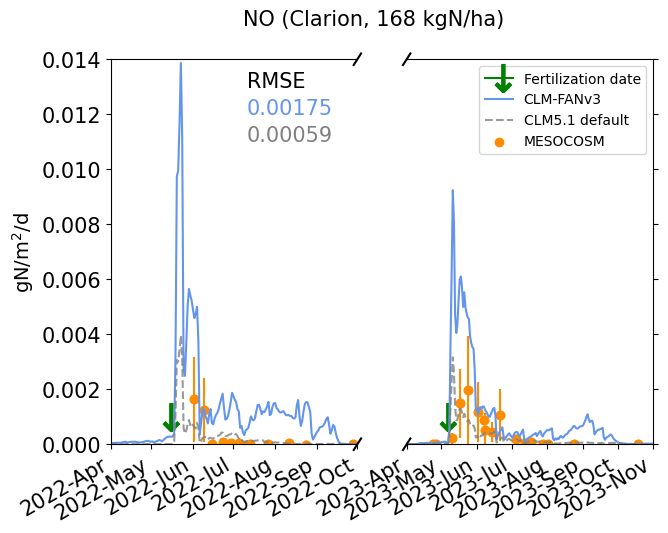

In [63]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022_cla.flatten(), no_time_2023_cla.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.0130, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.012, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.011, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(no_time_2022_cla, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023_cla, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2022_cla, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023_cla, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)
    
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.014)
ax[1].set_ylim(0, 0.014)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("NO (Clarion, 168 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_168kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

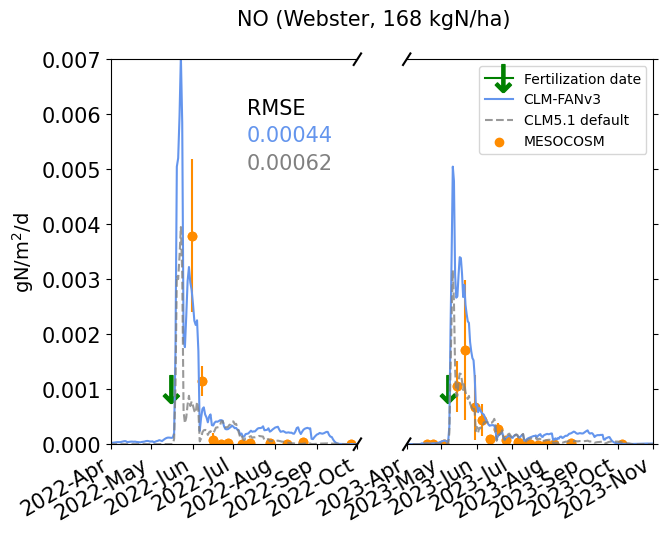

In [61]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022_web.flatten(), no_time_2023_web.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.006, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.0055, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.005, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(no_time_2022_web, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023_web, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2022_web, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023_web, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.007)
ax[1].set_ylim(0, 0.007)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("NO (Webster, 168 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_168kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

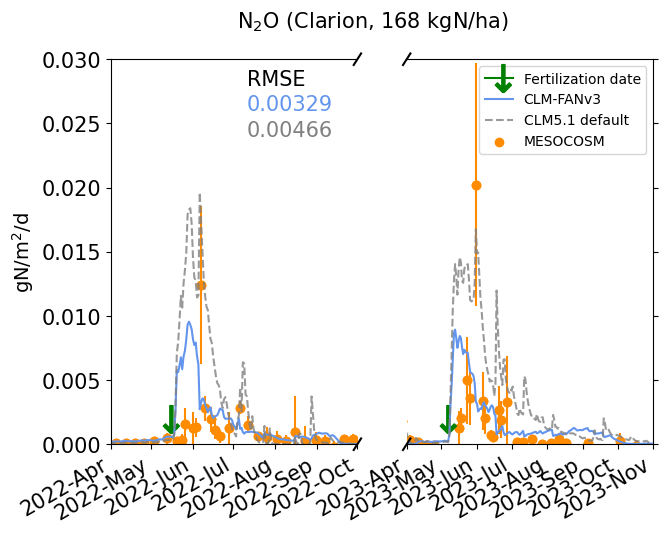

In [60]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022_cla.flatten(), n2o_time_2023_cla.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.028, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.026, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.024, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.030)
ax[1].set_ylim(0, 0.030)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Clarion, 168 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_168kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

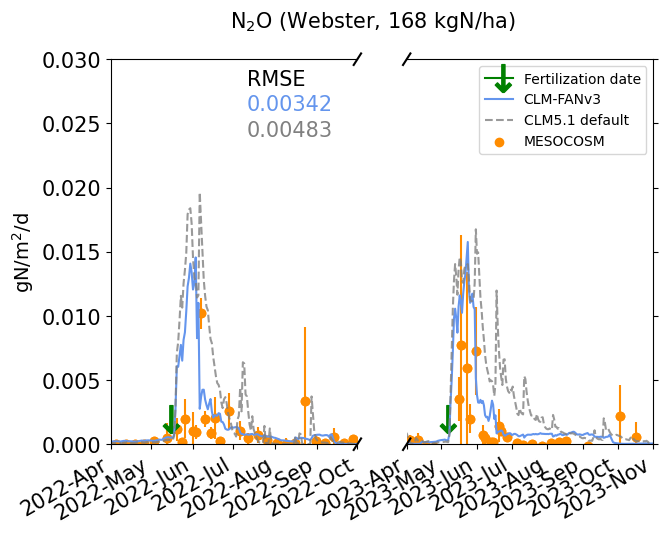

In [59]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022_web.flatten(), n2o_time_2023_web.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.028, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.026, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.024, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(n2o_time_2022_web, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023_web, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2022_web, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023_web, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.03)
ax[1].set_ylim(0, 0.03)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Webster, 168 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_168kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

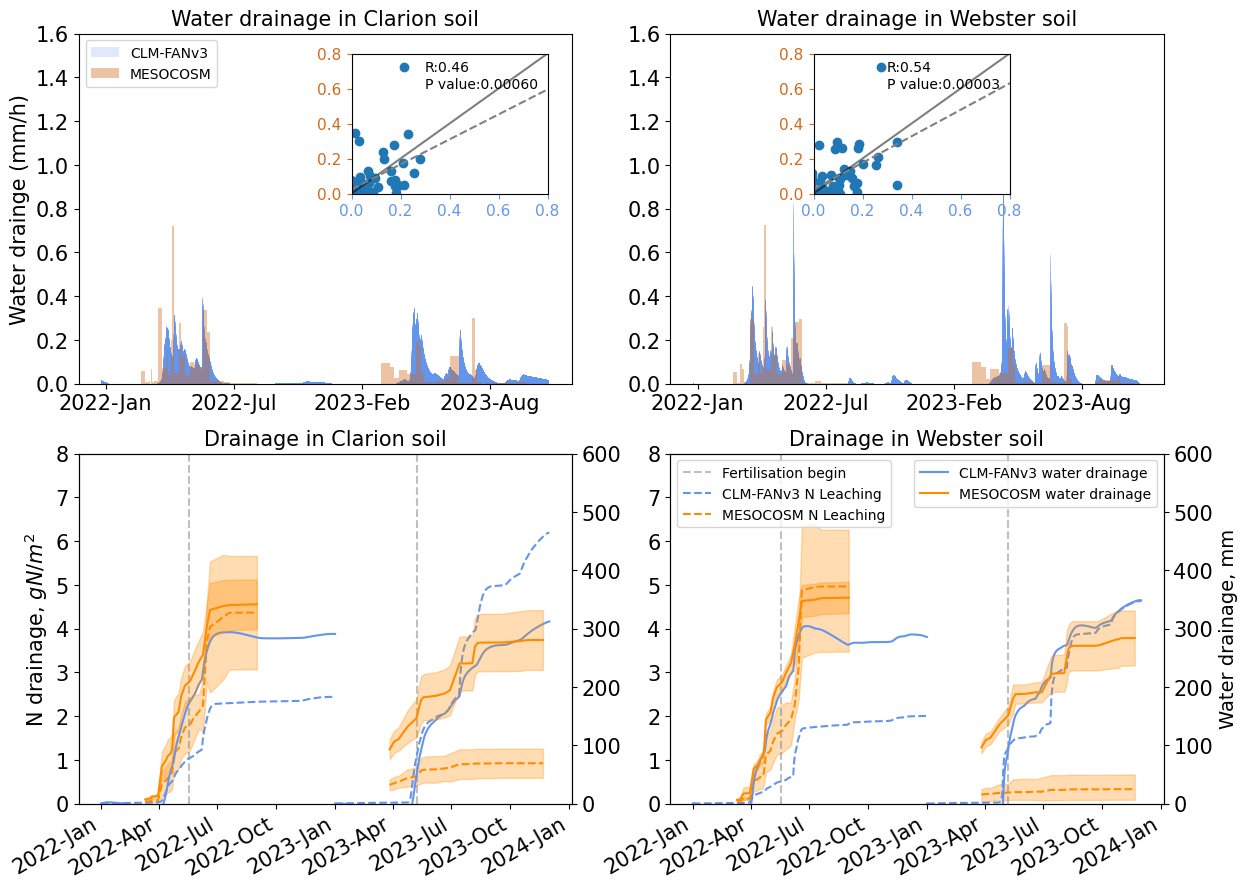

In [58]:
# Read the measuremnts
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['NO3N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['NH4N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']
dsWater['cumulative_nitrogen_gN_m2'] = dsWater['cumulative_annual_inorganicN_kg_ha']/10

runoff_meso_cum.loc[runoff_meso_cum.index > "2022-01-01"]

ndra_meso_cla_mean = dsWater.loc[('Clarion', '168'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_cla_std = dsWater.loc[('Clarion', '168'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()
ndra_meso_web_mean = dsWater.loc[('Webster', '168'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_web_std = dsWater.loc[('Webster', '168'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()

ndra_meso_cla_cum_mean = dsWater.loc[('Clarion', '168'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_cla_cum_std = dsWater.loc[('Clarion', '168'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_cla_cum_mean_2022 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index < "2023-01-01"]
ndra_meso_cla_cum_std_2022 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index < "2023-01-01"]
ndra_meso_cla_cum_mean_2023 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index > "2023-01-01"]
ndra_meso_cla_cum_std_2023 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index > "2023-01-01"]
ndra_meso_web_cum_mean = dsWater.loc[('Webster', '168'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_web_cum_std = dsWater.loc[('Webster', '168'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_web_cum_mean_2022 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index < "2023-01-01"]
ndra_meso_web_cum_std_2022 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index < "2023-01-01"]
ndra_meso_web_cum_mean_2023 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index > "2023-01-01"]
ndra_meso_web_cum_std_2023 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index > "2023-01-01"]

plottime_2022 = ndra_meso_cla_cum_mean_2022.index.values
plottime_2023 = ndra_meso_cla_cum_mean_2023.index.values

# CLM simulations
Total_N_runoff_cla = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
Total_N_runoff_web = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']
Total_N_runoff_default = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']

## hourly resolution!!
Total_N_cum_runoff_cla_2022 = (Total_N_runoff_cla.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_cla_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2022.time]
Total_N_cum_runoff_web_2022 = (Total_N_runoff_web.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_web_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2022.time]
Total_N_cum_runoff_default_2022 = (Total_N_runoff_default.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_default_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2022.time]
Total_N_cum_runoff_cla_2023 = (Total_N_runoff_cla.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_cla_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2023.time]
Total_N_cum_runoff_web_2023 = (Total_N_runoff_web.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_web_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2023.time]
Total_N_cum_runoff_default_2023 = (Total_N_runoff_default.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_default_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2023.time]


# Graph
fig, ax = plt.subplots(2, 2, figsize=(14,10))

# Create the embedded axes inside the SECOND subplot
left1, bottom1, width1, height1 = [0.32, 0.72, 0.14, 0.14]
ax_embedded1 = fig.add_axes([left1, bottom1, width1, height1])
slope, intercept, r_value, p_value, std_err = stats.linregress(meso_modelmatched_cla[1:]*3600, runoff_meso.values.ravel()[1:]*3600)
ax_embedded1.scatter(meso_modelmatched_cla*3600, runoff_meso.values.ravel()*3600)
ax_embedded1.plot([0.0, 1.0], [0.0, 1.0], color='black', alpha=0.5)
ax_embedded1.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)*slope + intercept, ls='--', color='grey')
ax_embedded1.text(0.3, 0.7, f'R:{r_value:.2f}', size=10)
ax_embedded1.text(0.3, 0.6, f'P value:{p_value:.5f}', size=10)
ax_embedded1.set_xlim(0, 0.8)
ax_embedded1.tick_params(axis='x', colors='cornflowerblue', labelsize=11)
ax_embedded1.set_ylim(0, 0.8)
ax_embedded1.tick_params(axis='y', colors='chocolate', labelsize=11)

left2, bottom2, width2, height2 = [0.65, 0.72, 0.14, 0.14]
ax_embedded2 = fig.add_axes([left2, bottom2, width2, height2])
slope, intercept, r_value, p_value, std_err = stats.linregress(meso_modelmatched_web[1:]*3600, runoff_meso_web.values.ravel()[1:]*3600)
ax_embedded2.scatter(meso_modelmatched_web*3600, runoff_meso_web.values.ravel()*3600, zorder=1)
ax_embedded2.plot([0.0, 1.0], [0.0, 1.0], color='black', alpha=0.5, zorder=1)
ax_embedded2.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)*slope + intercept, ls='--', color='grey', zorder=1)
ax_embedded2.text(0.3, 0.7, f'R:{r_value:.2f}', size=10, zorder=1)
ax_embedded2.text(0.3, 0.6, f'P value:{p_value:.5f}', size=10, zorder=1)
ax_embedded2.set_xlim(0, 0.8)
ax_embedded2.tick_params(axis='x', colors='cornflowerblue', labelsize=11)
ax_embedded2.set_ylim(0, 0.8)
ax_embedded2.tick_params(axis='y', colors='chocolate', labelsize=11)

ax[0, 0].bar(runoff_sim.time, runoff_sim.values.ravel()*3600, color='cornflowerblue', label='CLM-FANv3', alpha=0.2)
ax[0, 0].bar(mdates.date2num(runoff_meso.index.values)-plot_width/2, runoff_meso.values.ravel()*3600, width=plot_width, color='chocolate', label='MESOCOSM', alpha=0.4)
ax[0, 1].bar(runoff_sim_web.time, runoff_sim_web.values.ravel()*3600, color='cornflowerblue', alpha=0.2, zorder=2)
ax[0, 1].bar(mdates.date2num(runoff_meso_web.index.values)-plot_width/2, runoff_meso_web.values.ravel()*3600, width=plot_width, color='chocolate', alpha=0.4, zorder=2)
#ax[0, 0].scatter(runoff_meso.index.values, meso_modelmatched_cla*3600, marker='_', linewidths=1.0, color='green')
#ax[0, 1].scatter(runoff_meso_web.index.values, meso_modelmatched_web*3600, marker='_', linewidths=1.0, color='green')

ax[1, 0].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[1, 0].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[1, 1].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[1, 1].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')

#ax[1, 0].plot(Total_N_cum_runoff_default_2022.time, Total_N_cum_runoff_default_2022.values, label='CLM5.1 default', color='grey')
#ax[1, 1].plot(Total_N_cum_runoff_default_2022.time, Total_N_cum_runoff_default_2022.values, color='grey')
#ax[1, 0].plot(Total_N_cum_runoff_default_2023.time, Total_N_cum_runoff_default_2023.values, color='grey')
#ax[1, 1].plot(Total_N_cum_runoff_default_2023.time, Total_N_cum_runoff_default_2023.values, label='CLM5.1 default', color='grey')

ax[1, 0].plot(Total_N_cum_runoff_cla_2022.time, Total_N_cum_runoff_cla_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[1, 1].plot(Total_N_cum_runoff_web_2022.time, Total_N_cum_runoff_web_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[1, 0].plot(Total_N_cum_runoff_cla_2023.time, Total_N_cum_runoff_cla_2023.values, color='cornflowerblue', linestyle='--')
ax[1, 1].plot(Total_N_cum_runoff_web_2023.time, Total_N_cum_runoff_web_2023.values, color='cornflowerblue', linestyle='--')

ax[1, 0].plot(plottime_2022, ndra_meso_cla_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[1, 1].plot(plottime_2022, ndra_meso_web_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[1, 0].fill_between(plottime_2022, ndra_meso_cla_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_cla_cum_mean_2022.values-ndra_meso_cla_cum_std_2022.values, alpha=0.3, color='darkorange')
ax[1, 1].fill_between(plottime_2022, ndra_meso_web_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_web_cum_mean_2022.values-ndra_meso_web_cum_std_2022.values, alpha=0.3, color='darkorange')
ax[1, 0].plot(plottime_2023, ndra_meso_cla_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[1, 1].plot(plottime_2023, ndra_meso_web_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[1, 0].fill_between(plottime_2023, ndra_meso_cla_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_cla_cum_mean_2023.values-ndra_meso_cla_cum_std_2023.values, alpha=0.3, color='darkorange')
ax[1, 1].fill_between(plottime_2023, ndra_meso_web_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_web_cum_mean_2023.values-ndra_meso_web_cum_std_2023.values, alpha=0.3, color='darkorange')

# add the total water drainge in here.
ax1 = ax[1, 0].twinx()
ax1.plot(runoff_sim_2022_cum.time, runoff_sim_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax1.plot(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax1.fill_between(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values+runoff_meso_2022_cum_std.values, runoff_meso_2022_cum.values - runoff_meso_2022_cum_std.values, color='darkorange', alpha=0.3)
ax1.plot(runoff_sim_2023_cum.time, runoff_sim_2023_cum.values, color='cornflowerblue', zorder=1)
ax1.plot(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values, color='darkorange', zorder=1)
ax1.fill_between(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values+runoff_meso_2023_cum_std.values, runoff_meso_2023_cum.values - runoff_meso_2023_cum_std.values, color='darkorange', alpha=0.3)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0, 600)
ax2 = ax[1, 1].twinx()
ax2.plot(runoff_sim_web_2022_cum.time, runoff_sim_web_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax2.plot(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax2.fill_between(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values+runoff_meso_web_2022_cum_std.values, runoff_meso_web_2022_cum.values - runoff_meso_web_2022_cum_std.values, color='darkorange', alpha=0.3)
ax2.plot(runoff_sim_web_2023_cum.time, runoff_sim_web_2023_cum.values, color='cornflowerblue', zorder=1)
ax2.plot(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values, color='darkorange', zorder=1)
ax2.fill_between(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values+runoff_meso_web_2023_cum_std.values, runoff_meso_web_2023_cum.values - runoff_meso_web_2023_cum_std.values, color='darkorange', alpha=0.3)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right')
ax2.set_ylabel('Water drainage, mm', size=14)
ax2.set_ylim(0, 600)

ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1, 0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1, 1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[1, 0].set_ylim(0, 8)
ax[0, 0].set_ylim(0, 1.6)
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)
ax[0, 1].tick_params(axis='x', labelsize=15)
ax[0, 1].tick_params(axis='y', labelsize=15)
ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)
ax[1, 1].tick_params(axis='x', labelsize=15)
ax[1, 1].tick_params(axis='y', labelsize=15)
ax[0, 0].set_ylabel("Water drainge (mm/h)", size=15)
ax[0, 0].legend(loc='upper left')

ax[0, 1].set_ylim(0, 1.6)
ax[0, 1].tick_params(axis='x', labelsize=15)
ax[1, 1].tick_params(axis='y', labelsize=15)
ax[0, 1].tick_params(axis='y', labelsize=15)
ax[1, 1].set_ylim(0, 8)
ax[1, 0].set_ylabel('N drainage, $gN/m^2$', size=15)
ax[0, 0].set_title('Water drainage in Clarion soil', size=15)
ax[0, 1].set_title('Water drainage in Webster soil', size=15)
ax[1, 0].set_title('Drainage in Clarion soil', size=15)
ax[1, 1].set_title('Drainage in Webster soil', size=15)
ax[1, 1].legend(loc='upper left')

fig.savefig("finalgraphs/DrainageAndLeaching168kg.pdf", format='pdf')
plt.show()

### 213 kgN fertilizer experiment

In [33]:
fert_amount = "213"
case_clarion = "clarion" + fert_amount + "kgN"
case_webster = "webster" + fert_amount + "kgN"
path_clarion = "/glade/derecho/scratch/jinmuluo/archive/clarion213kgN05gC/lnd/hist/" 
path_webster = "/glade/derecho/scratch/jinmuluo/archive/webster213kgN05gC/lnd/hist/" 
path_default = "/glade/derecho/scratch/jinmuluo/archive/DefaultCLMatMESOCOSM213kgN/lnd/hist/" 

start_date = date(2022, 1, 1)
end_date = date(2023, 12, 1)
NO_LEAP = True
delta_days = (end_date - start_date).days

NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 
          'FFIX_TO_SMINN', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
          'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", 
         "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]
Others = ["FAN_TOTN", "NITRATE_TOTN",'SMINN', 'SMINN_vr', 'SMIN_NH4_vr', 'SMIN_NO3_vr', 'TOTSOMC_1m', 'TOTSOMN_1m',
          'RAIN', 'QDRAI', 'QOVER', 'QOUT120cm', 'H2OSOI', 'SOILLIQ', 'TSOI_10CM',
         'SMINN_TO_PLANT_FUN_NO3', 'SMINN_TO_PLANT_FUN_NH4', 'SMINN_TO_PLANT_FUN', 
          'F_NIT', 'F_NIT_vr', 'F_DENIT', 'F_DENIT_vr', 'GROSS_NMIN', 'GROSS_NMIN_vr', 'ACTUAL_IMMOB_NH4', 'ACTUAL_IMMOB_NO3',
         'LEAFN', 'LIVESTEMN', 'FROOTN', 'LIVECROOTN', 'GRAINN', 'CROPPROD1N',
         'WFPS', 'n2_n2o_ratio_denit', 'ratio_nox_n2o', 'anaerobic_frac', 'fd_WFPS']

CLM_Clarion = []
CLM_Webster = []
CLM_Default = []

for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
    CLM_Clarion.append(path_clarion + case_clarion + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Webster.append(path_webster + case_webster + ".clm2." + "h1" + "." + currdate + "-00000.nc")
    CLM_Default.append(path_default + "DefaultCLMatMESOCOSM" + ".clm2." + "h1" + "." + currdate + "-00000.nc" )

In [34]:
def preprocess(ds, fields= NInput + GAS + Others + RUNOFF):
    return(ds[fields])

dsCLM_Clarion = xr.open_mfdataset(CLM_Clarion, decode_times=True, preprocess=preprocess)
dsCLM_Webster = xr.open_mfdataset(CLM_Webster, decode_times=True, preprocess=preprocess)
dsCLM_Default = xr.open_mfdataset(CLM_Default, decode_times=True, preprocess=preprocess)

x = np.zeros(len(dsCLM_Clarion['levsoi']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levsoi'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levsoi'][i].values - dsCLM_Clarion['levsoi'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth=(dsCLM_Clarion['levsoi'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth=(dsCLM_Webster['levsoi'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth=(dsCLM_Default['levsoi'].coords, x))

x = np.zeros(len(dsCLM_Clarion['levdcmp']))
for i in range(len(x)):
    if i == 0 :
        x[i] = dsCLM_Clarion['levdcmp'][i].values * 2
    else:
        x[i] = (dsCLM_Clarion['levdcmp'][i].values - dsCLM_Clarion['levdcmp'][i-1].values - x[i-1]/2)*2

dsCLM_Clarion = dsCLM_Clarion.assign(depth2=(dsCLM_Clarion['levdcmp'].coords, x))
dsCLM_Webster = dsCLM_Webster.assign(depth2=(dsCLM_Webster['levdcmp'].coords, x))
dsCLM_Default = dsCLM_Default.assign(depth2=(dsCLM_Default['levdcmp'].coords, x))

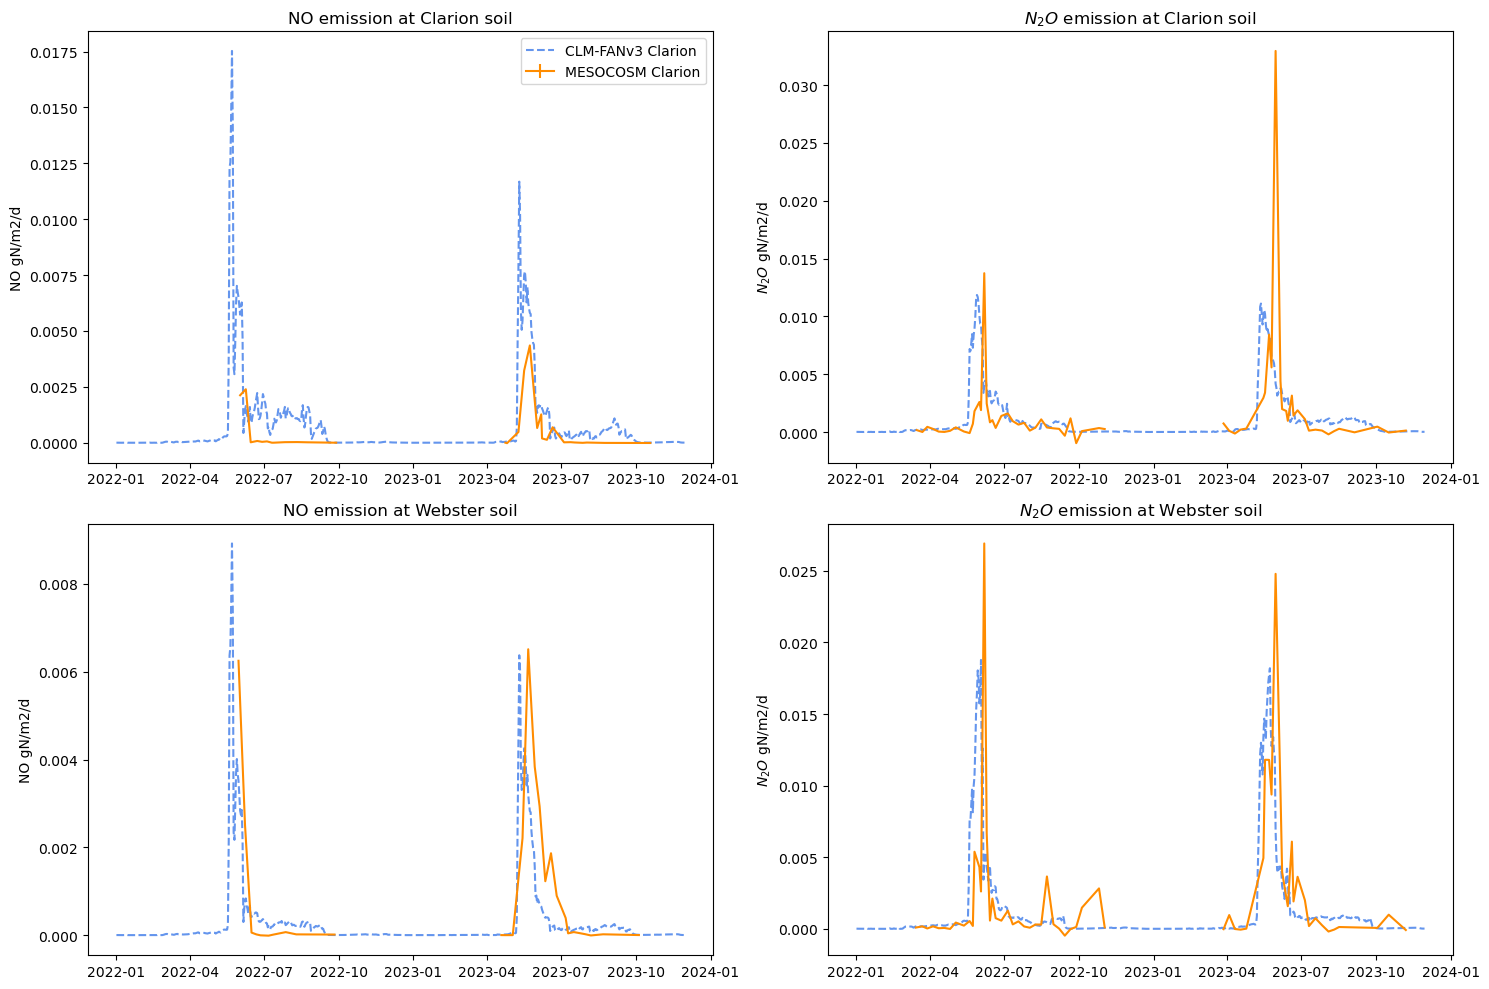

In [35]:
# Read the mesocsom measurements
p2 = "/glade/work/jinmuluo/MESONET/measurements/2023data/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022_2023.csv')
dsNO['date'] = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsNO.set_index(['soil', 'N_rate_kg_ha', 'Block', 'date'], inplace=True)
dsNO = dsNO.sort_index()
dsNO['Mean_NO_flux_gN/m2/d'] = dsNO['Mean_NO_flux_nmol_m2_s']*1e-9*30*24*3600/14
dsN2O = pd.read_csv(p2+'soil_gas_fluxes_combined_2022_2023_control.csv')
dsN2O['date'] = pd.to_datetime(dsN2O['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsN2O.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsN2O = dsN2O.sort_index()

mean_dsNO_cla = dsNO.loc[('Clarion', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_cla_2023 = mean_dsNO_cla.loc[mean_dsNO_cla.index > "2023-01-01"]
mean_dsNO_cla_2022 = mean_dsNO_cla.loc[mean_dsNO_cla.index < "2023-01-01"]
std_dsNO_cla = dsNO.loc[('Clarion', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_cla_2023 = std_dsNO_cla.loc[std_dsNO_cla.index > "2023-01-01"]
std_dsNO_cla_2022 = std_dsNO_cla.loc[std_dsNO_cla.index < "2023-01-01"]
min_dsNO_cla = dsNO.loc[('Clarion', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_cla_2023 = min_dsNO_cla.loc[min_dsNO_cla.index > "2023-01-01"]
min_dsNO_cla_2022 = min_dsNO_cla.loc[min_dsNO_cla.index < "2023-01-01"]
max_dsNO_cla = dsNO.loc[('Clarion', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_cla_2023 = max_dsNO_cla.loc[max_dsNO_cla.index > "2023-01-01"]
max_dsNO_cla_2022 = max_dsNO_cla.loc[max_dsNO_cla.index < "2023-01-01"]
mean_dsNO_web = dsNO.loc[('Webster', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').mean()
mean_dsNO_web_2023 = mean_dsNO_web.loc[mean_dsNO_web.index > "2023-01-01"]
mean_dsNO_web_2022 = mean_dsNO_web.loc[mean_dsNO_web.index < "2023-01-01"]
std_dsNO_web = dsNO.loc[('Webster', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').std()
std_dsNO_web_2023 = std_dsNO_web.loc[std_dsNO_web.index > "2023-01-01"]
std_dsNO_web_2022 = std_dsNO_web.loc[std_dsNO_web.index < "2023-01-01"]
min_dsNO_web = dsNO.loc[('Webster', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').min()
min_dsNO_web_2023 = min_dsNO_web.loc[min_dsNO_web.index > "2023-01-01"]
min_dsNO_web_2022 = min_dsNO_web.loc[min_dsNO_web.index < "2023-01-01"]
max_dsNO_web = dsNO.loc[('Webster', 213), 'Mean_NO_flux_gN/m2/d'].groupby(level='date').max()
max_dsNO_web_2023 = max_dsNO_web.loc[max_dsNO_web.index > "2023-01-01"]
max_dsNO_web_2022 = max_dsNO_web.loc[max_dsNO_web.index < "2023-01-01"]
mean_dsN2O_cla = dsN2O.loc[('Clarion', 213), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_cla_2023 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index > "2023-01-01"]
mean_dsN2O_cla_2022 = mean_dsN2O_cla.loc[mean_dsN2O_cla.index < "2023-01-01"]
std_dsN2O_cla = dsN2O.loc[('Clarion', 213), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_cla_2023 = std_dsN2O_cla.loc[std_dsN2O_cla.index > "2023-01-01"]
std_dsN2O_cla_2022 = std_dsN2O_cla.loc[std_dsN2O_cla.index < "2023-01-01"]
min_dsN2O_cla = dsN2O.loc[('Clarion', 213), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_cla_2023 = min_dsN2O_cla.loc[min_dsN2O_cla.index > "2023-01-01"]
min_dsN2O_cla_2022 = min_dsN2O_cla.loc[min_dsN2O_cla.index < "2023-01-01"]
max_dsN2O_cla = dsN2O.loc[('Clarion', 213), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_cla_2023 = max_dsN2O_cla.loc[max_dsN2O_cla.index > "2023-01-01"]
max_dsN2O_cla_2022 = max_dsN2O_cla.loc[max_dsN2O_cla.index < "2023-01-01"]
mean_dsN2O_web = dsN2O.loc[('Webster', 213), 'N2ON_g_m2_d'].groupby(level='date').mean()
mean_dsN2O_web_2023 = mean_dsN2O_web.loc[mean_dsN2O_web.index > "2023-01-01"]
mean_dsN2O_web_2022 = mean_dsN2O_web.loc[mean_dsN2O_web.index < "2023-01-01"]
std_dsN2O_web = dsN2O.loc[('Webster', 213), 'N2ON_g_m2_d'].groupby(level='date').std()
std_dsN2O_web_2023 = std_dsN2O_web.loc[std_dsN2O_web.index > "2023-01-01"]
std_dsN2O_web_2022 = std_dsN2O_web.loc[std_dsN2O_web.index < "2023-01-01"]
min_dsN2O_web = dsN2O.loc[('Webster', 213), 'N2ON_g_m2_d'].groupby(level='date').min()
min_dsN2O_web_2023 = min_dsN2O_web.loc[min_dsN2O_web.index > "2023-01-01"]
min_dsN2O_web_2022 = min_dsN2O_web.loc[min_dsN2O_web.index < "2023-01-01"]
max_dsN2O_web = dsN2O.loc[('Webster', 213), 'N2ON_g_m2_d'].groupby(level='date').max()
max_dsN2O_web_2023 = max_dsN2O_web.loc[max_dsN2O_web.index > "2023-01-01"]
max_dsN2O_web_2022 = max_dsN2O_web.loc[max_dsN2O_web.index < "2023-01-01"]
no_time_2023_cla = mean_dsNO_cla_2023.index.values
n2o_time_2023_cla = mean_dsN2O_cla_2023.index.values
no_time_2023_web = mean_dsNO_web_2023.index.values
n2o_time_2023_web = mean_dsN2O_web_2023.index.values
no_time_2022_cla = mean_dsNO_cla_2022.index.values
n2o_time_2022_cla = mean_dsN2O_cla_2022.index.values
no_time_2022_web = mean_dsNO_web_2022.index.values
n2o_time_2022_web = mean_dsN2O_web_2022.index.values


# Read the CLM model simulations
NO_Clarion = (dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
NO_Clarion = NO_Clarion.resample(time='D').mean()*24*3600
NO_Clarion.attrs['units'] = "gN/m2/d"
NO_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Clarion.time]
NO_Webster = (dsCLM_Webster.NOx_NITRIFY_TOTAL + dsCLM_Webster.NOx_DENITRIFY_TOTAL + dsCLM_Webster.F_NOx_NIT + dsCLM_Webster.F_NOx_DENIT)
NO_Webster = NO_Webster.resample(time='D').mean()*24*3600
NO_Webster.attrs['units'] = "gN/m2/d"
NO_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Webster.time]
NO_Default = (dsCLM_Default.NOx_NITRIFY_TOTAL + dsCLM_Default.NOx_DENITRIFY_TOTAL + dsCLM_Default.F_NOx_NIT + dsCLM_Default.F_NOx_DENIT)
NO_Default = NO_Default.resample(time='D').mean()*24*3600
NO_Default.attrs['units'] = "gN/m2/d"
NO_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NO_Default.time]

N2O_Clarion = (dsCLM_Clarion.N2O_NITRIFY_TOTAL + dsCLM_Clarion.F_N2O_NIT + dsCLM_Clarion.N2O_DENITRIFY_TOTAL+ dsCLM_Clarion.F_N2O_DENIT)
N2O_Clarion = N2O_Clarion.resample(time='D').mean()*24*3600
N2O_Clarion.attrs['units'] = "gN/m2/d"
N2O_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Clarion.time]
N2O_Webster = (dsCLM_Webster.N2O_NITRIFY_TOTAL + dsCLM_Webster.F_N2O_NIT + dsCLM_Webster.N2O_DENITRIFY_TOTAL+ dsCLM_Webster.F_N2O_DENIT)
N2O_Webster = N2O_Webster.resample(time='D').mean()*24*3600
N2O_Webster.attrs['units'] = "gN/m2/d"
N2O_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Webster.time]
N2O_Default = (dsCLM_Default.N2O_NITRIFY_TOTAL + dsCLM_Default.F_N2O_NIT + dsCLM_Default.N2O_DENITRIFY_TOTAL+ dsCLM_Default.F_N2O_DENIT)
N2O_Default = N2O_Default.resample(time='D').mean()*24*3600
N2O_Default.attrs['units'] = "gN/m2/d"
N2O_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in N2O_Default.time]

NH3_Clarion = dsCLM_Clarion.NH3_TOTAL
NH3_Clarion = NH3_Clarion.resample(time='D').mean()*24*3600
NH3_Clarion.attrs['units'] = "gN/m2/d"
NH3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Clarion.time]
NH3_Webster = dsCLM_Webster.NH3_TOTAL
NH3_Webster = NH3_Webster.resample(time='D').mean()*24*3600
NH3_Webster.attrs['units'] = "gN/m2/d"
NH3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Webster.time]
NH3_Default = dsCLM_Default.NH3_TOTAL
NH3_Default = NH3_Default.resample(time='D').mean()*24*3600
NH3_Default.attrs['units'] = "gN/m2/d"
NH3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in NH3_Default.time]
# Plot the graph
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(NO_Clarion.time, NO_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion', color='cornflowerblue')
ax[1, 0].plot(NO_Webster.time, NO_Webster.values, linestyle='--', label='CLM-FANv3 Webster', color='cornflowerblue')

#ax[0, 0].errorbar(no_time_2022, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 0].errorbar(no_time_2022, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, label='MESOCOSM Webster', color='darkorange')
#ax[0, 0].errorbar(no_time_2023, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 0].errorbar(no_time_2023, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, label='MESOCOSM Webster', color='darkorange')

ax[0, 0].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=0, label='MESOCOSM Clarion', color='darkorange')
ax[1, 0].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=0, label='MESOCOSM Webster', color='darkorange')
ax[0, 0].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=0, color='darkorange')
ax[1, 0].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=0, color='darkorange')

ax[0, 0].legend()
ax[0, 0].set_title("NO emission at Clarion soil")
ax[0, 1].set_title("$N_2O$ emission at Clarion soil")
ax[0, 0].set_ylabel("NO gN/m2/d")
ax[0, 1].set_ylabel("$N_2O$ gN/m2/d")

ax[0, 1].plot(N2O_Clarion.time, N2O_Clarion.values, linestyle='--', label='CLM-FANv3 Clarion', color='cornflowerblue')
ax[1, 1].plot(N2O_Webster.time, N2O_Webster.values, linestyle='--', label='CLM-FANv3 Webster', color='cornflowerblue')

#ax[0, 1].errorbar(n2o_time_2022, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 1].errorbar(n2o_time_2022, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, label='MESOCOSM Webster', color='darkorange')
#ax[0, 1].errorbar(n2o_time_2023, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, label='MESOCOSM Clarion', color='darkorange')
#ax[1, 1].errorbar(n2o_time_2023, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, label='MESOCOSM Webster', color='darkorange')

ax[0, 1].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=0, label='MESOCOSM Clarion', color='darkorange')
ax[1, 1].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=0, label='MESOCOSM Webster', color='darkorange')
ax[0, 1].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=0, color='darkorange')
ax[1, 1].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=0, color='darkorange')

ax[1, 0].set_title("NO emission at Webster soil")
ax[1, 1].set_title("$N_2O$ emission at Webster soil")
ax[1, 0].set_ylabel("NO gN/m2/d")
ax[1, 1].set_ylabel("$N_2O$ gN/m2/d")
fig.tight_layout()
fig.savefig("graphs/Ngas_213kgN_combined.jpg", dpi=300)
plt.show()

In [36]:
test=(dsCLM_Clarion.NOx_NITRIFY_TOTAL + dsCLM_Clarion.NOx_DENITRIFY_TOTAL + dsCLM_Clarion.F_NOx_NIT + dsCLM_Clarion.F_NOx_DENIT)
test = test.idxmax(dim='time')
test.values

array([cftime.DatetimeNoLeap(2022, 5, 23, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)

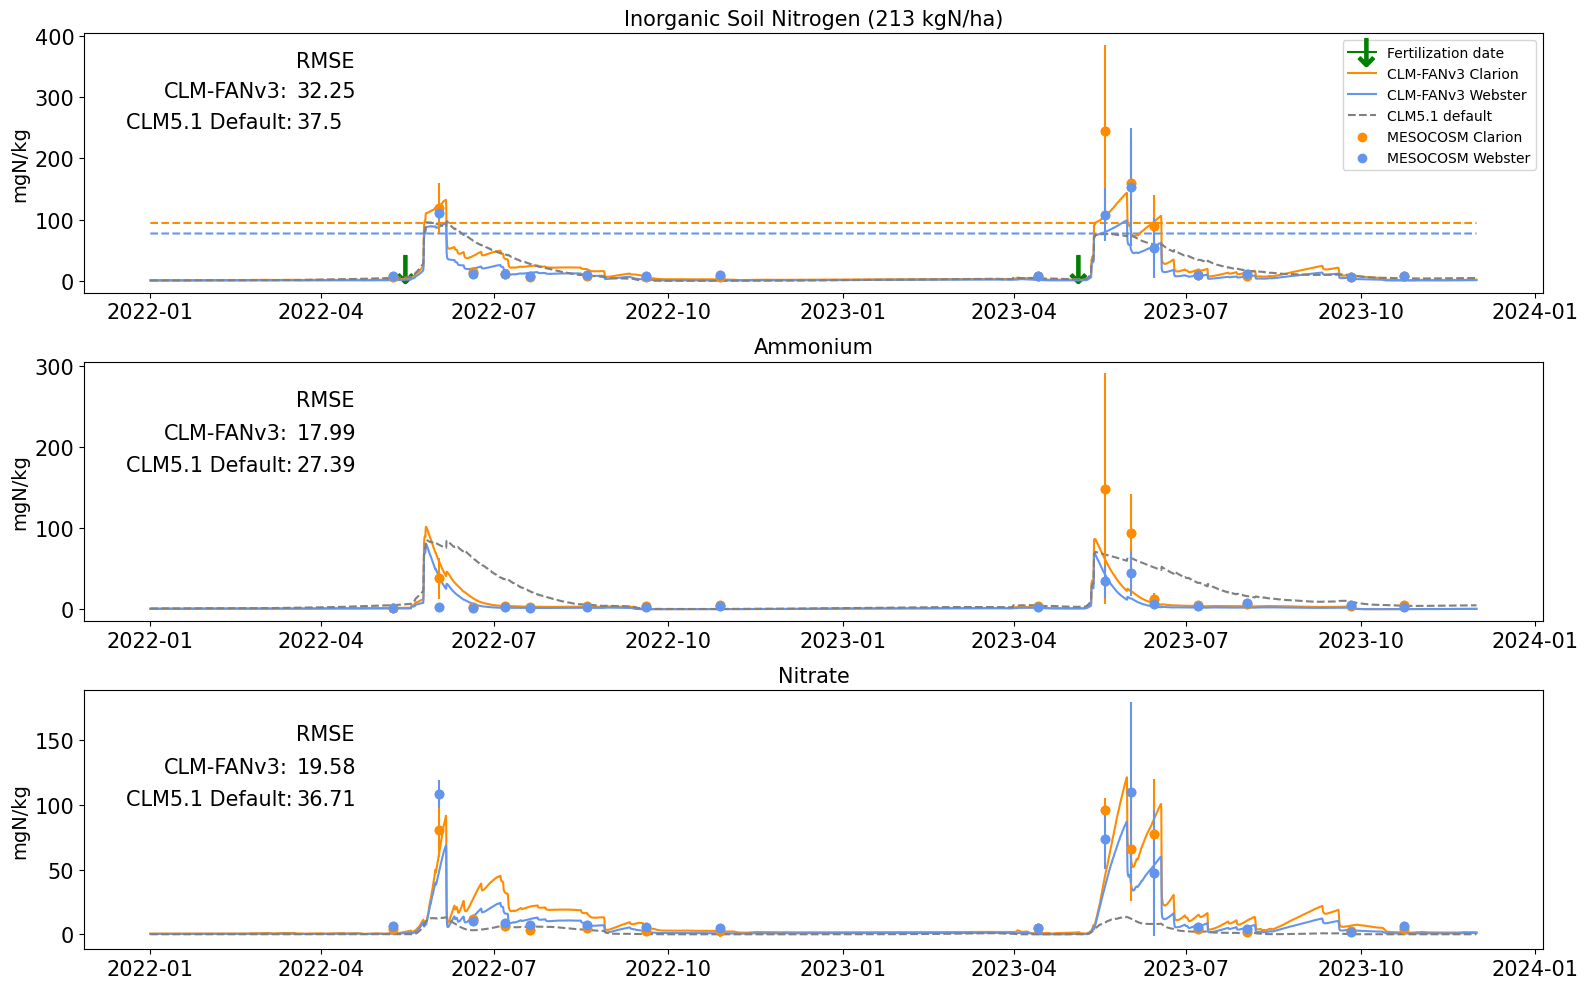

In [37]:
# Read the mesocosm measurement
fert_date = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")
dsMESOCOSM = pd.read_csv("/glade/work/jinmuluo/MESONET/measurements/2023data/soil_inorganic_N_combined_2022_2023_control.csv")
dsMESOCOSM['date'] = ['20' + str(t) for t in dsMESOCOSM['date'].values]
dsMESOCOSM['date'] = pd.to_datetime(dsMESOCOSM['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
dsMESOCOSM['soil_sminn'] = dsMESOCOSM['soil_nitrate_mgN_kg'] + dsMESOCOSM['soil_ammonium_mgN_kg']
dsMESOCOSM.set_index(['soil', 'N_rate_kg_ha', 'block', 'date'], inplace=True)
dsMESOCOSM = dsMESOCOSM.sort_index()

sminn_cla = dsMESOCOSM.loc[('Clarion', 212), 'soil_sminn'].groupby(level='date').mean()
sminn_cla = sminn_cla.loc[sminn_cla.index > "2022-01-01"]
sminn_cla_std = dsMESOCOSM.loc[('Clarion', 212), 'soil_sminn'].groupby(level='date').std()
sminn_cla_std = sminn_cla_std.loc[sminn_cla_std.index > "2022-01-01"]
sminn_web = dsMESOCOSM.loc[('Webster', 212), 'soil_sminn'].groupby(level='date').mean()
sminn_web = sminn_web.loc[sminn_web.index > "2022-01-01"]
sminn_web_std = dsMESOCOSM.loc[('Webster', 212), 'soil_sminn'].groupby(level='date').std()
sminn_web_std = sminn_web_std.loc[sminn_web_std.index > "2022-01-01"]
nh4_cla = dsMESOCOSM.loc[('Clarion', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_cla = nh4_cla.loc[nh4_cla.index > "2022-01-01"]
nh4_cla_std = dsMESOCOSM.loc[('Clarion', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_cla_std = nh4_cla_std.loc[nh4_cla_std.index > "2022-01-01"]
nh4_web = dsMESOCOSM.loc[('Webster', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').mean()
nh4_web = nh4_web.loc[nh4_web.index > "2022-01-01"]
nh4_web_std = dsMESOCOSM.loc[('Webster', 212), 'soil_ammonium_mgN_kg'].groupby(level='date').std()
nh4_web_std = nh4_web_std.loc[nh4_web_std.index > "2022-01-01"]
no3_cla = dsMESOCOSM.loc[('Clarion', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_cla = no3_cla.loc[no3_cla.index > "2022-01-01"]
no3_cla_std = dsMESOCOSM.loc[('Clarion', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_cla_std = no3_cla_std.loc[no3_cla_std.index > "2022-01-01"]
no3_web = dsMESOCOSM.loc[('Webster', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').mean()
no3_web = no3_web.loc[no3_web.index > "2022-01-01"]
no3_web_std = dsMESOCOSM.loc[('Webster', 212), 'soil_nitrate_mgN_kg'].groupby(level='date').std()
no3_web_std = no3_web_std.loc[no3_web_std.index > "2022-01-01"]
plot_time = no3_web.index.values
fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

# Read the CLM simulation results
sminn_Clarion = dsCLM_Clarion['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Webster = dsCLM_Webster['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
sminn_Default = dsCLM_Default['SMINN_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')

## gN/m3 to mgN/kg at the top 9 cm soil, soil bulk density from Steven Hall, CLM uses soil density 2650
sminn_Clarion = sminn_Clarion*1000/1125
sminn_Webster = sminn_Webster*1000/1375
sminn_Default = sminn_Default*1000/1375
sminn_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Clarion.time]
sminn_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Webster.time]
sminn_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in sminn_Default.time]
## gN/m2 to mgN/kg, fertilization depth is around top 20cm
fert_conc_cla = 21.3*1000/0.2/1125
fert_conc_web = 21.3*1000/0.2/1375

dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["FAN_TOTN"].values - dsCLM_Clarion["NITRATE_TOTN"].values
dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Webster["FAN_TOTN"].values - dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=0.01).values + dsCLM_Default["FAN_TOTN"].values - dsCLM_Default["NITRATE_TOTN"].values
nh4_Clarion = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Webster = dsCLM_Webster['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Default = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion = nh4_Clarion*1000/1125
nh4_Webster = nh4_Webster*1000/1375
nh4_Default = nh4_Default*1000/1375
nh4_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Clarion.time]
nh4_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Webster.time]
nh4_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in nh4_Default.time]

dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Clarion["NITRATE_TOTN"].values   
dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Webster["NITRATE_TOTN"].values
dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=0.01).values + dsCLM_Default["NITRATE_TOTN"].values
no3_Clarion = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Webster = dsCLM_Webster['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Default = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion = no3_Clarion*1000/1125
no3_Webster = no3_Webster*1000/1375
no3_Default = no3_Default*1000/1375
no3_Clarion['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Clarion.time]
no3_Webster['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Webster.time]
no3_Default['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in no3_Default.time]

# RMSE Calculations for concentrations.
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(plot_time)]
rmse_n_model = cal_rmse((sminn_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                         + sminn_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                        (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_model = cal_rmse((nh4_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + nh4_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (nh4_cla.values + nh4_web.values)/2)
rmse_no3_model = cal_rmse((no3_Clarion.sel(time=sample_time, method='nearest').values.flatten() 
                           + no3_Webster.sel(time=sample_time, method='nearest').values.flatten())/2, 
                          (no3_cla.values + no3_web.values)/2)

rmse_n_default = cal_rmse(sminn_Default.sel(time=sample_time, method='nearest').values.flatten(), (sminn_cla.values + sminn_web.values)/2)
rmse_nh4_default = cal_rmse(nh4_Default.sel(time=sample_time, method='nearest').values.flatten(), (nh4_cla.values + nh4_web.values)/2)
rmse_no3_default = cal_rmse(no3_Default.sel(time=sample_time, method='nearest').values.flatten(), (no3_cla.values + no3_web.values)/2)

# graph
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
# theoretical values
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_cla, color='darkorange', linestyle='--')
ax[0].plot(sminn_Clarion['time'], np.ones(len(sminn_Clarion['time']))*fert_conc_web, color='cornflowerblue', linestyle='--')

# fertilisation date
ax[0].plot(fert_date_2022 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green')
ax[0].plot(fert_date_2023 - 5, 20, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].plot(sminn_Clarion.time, sminn_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[0].plot(sminn_Webster.time, sminn_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[0].plot(sminn_Default.time, sminn_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[0].scatter(plot_time, sminn_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[0].scatter(plot_time, sminn_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[0].errorbar(plot_time, sminn_cla.values, yerr=sminn_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[0].errorbar(plot_time, sminn_web.values, yerr=sminn_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title("Inorganic Soil Nitrogen (213 kgN/ha)", size=15)
ax[0].set_ylabel("mgN/kg", size=14)
ax[0].text(fert_date_2022 - 60, 350, "RMSE", size=15)
ax[0].text(fert_date_2022 - 130, 300, "CLM-FANv3:", size=15)
ax[0].text(fert_date_2022 - 150, 250, "CLM5.1 Default:", size=15)
ax[0].text(fert_date_2022 - 60, 300, round(rmse_n_model, 2), size=15)
ax[0].text(fert_date_2022 - 60, 250, round(rmse_n_default, 2), size=15)
ax[0].legend(loc="upper right")

ax[1].plot(sminn_Clarion.time, nh4_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[1].plot(sminn_Webster.time, nh4_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[1].plot(sminn_Default.time, nh4_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[1].scatter(plot_time, nh4_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[1].scatter(plot_time, nh4_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[1].errorbar(plot_time, nh4_cla.values, yerr=nh4_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[1].errorbar(plot_time, nh4_web.values, yerr=nh4_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title("Ammonium", size=15)
ax[1].set_ylabel("mgN/kg", size=14)
ax[1].text(fert_date_2022 - 60, 250, "RMSE", size=15)
ax[1].text(fert_date_2022 - 130, 210, "CLM-FANv3:", size=15)
ax[1].text(fert_date_2022 - 150, 170, "CLM5.1 Default:", size=15)
ax[1].text(fert_date_2022 - 60, 210, round(rmse_nh4_model, 2), size=15)
ax[1].text(fert_date_2022 - 60, 170, round(rmse_nh4_default, 2), size=15)

ax[2].plot(sminn_Clarion.time, no3_Clarion.values, label='CLM-FANv3 Clarion', color='darkorange')
ax[2].plot(sminn_Webster.time, no3_Webster.values, label='CLM-FANv3 Webster', color='cornflowerblue')
ax[2].plot(sminn_Default.time, no3_Default.values, label='CLM5.1 default', ls='--', color='grey')
ax[2].scatter(plot_time, no3_cla.values, label='MESOCOSM Clarion', color='darkorange', zorder=2)
ax[2].scatter(plot_time, no3_web.values, label='MESOCOSM Webster', color='cornflowerblue', zorder=2)
ax[2].errorbar(plot_time, no3_cla.values, yerr=no3_cla_std.values, fmt="o", color='darkorange', zorder=2)
ax[2].errorbar(plot_time, no3_web.values, yerr=no3_web_std.values, fmt="o", color='cornflowerblue', zorder=2)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_title("Nitrate", size=15)
ax[2].set_ylabel("mgN/kg", size=14)
ax[2].text(fert_date_2022 - 60, 150, "RMSE", size=15)
ax[2].text(fert_date_2022 - 130, 125, "CLM-FANv3:", size=15)
ax[2].text(fert_date_2022 - 150, 100, "CLM5.1 Default:", size=15)
ax[2].text(fert_date_2022 - 60, 125, round(rmse_no3_model, 2), size=15)
ax[2].text(fert_date_2022 - 60, 100, round(rmse_no3_default, 2), size=15)

fig.tight_layout()
fig.savefig("finalgraphs/Concentration213kgN.pdf", format='pdf')
plt.show()

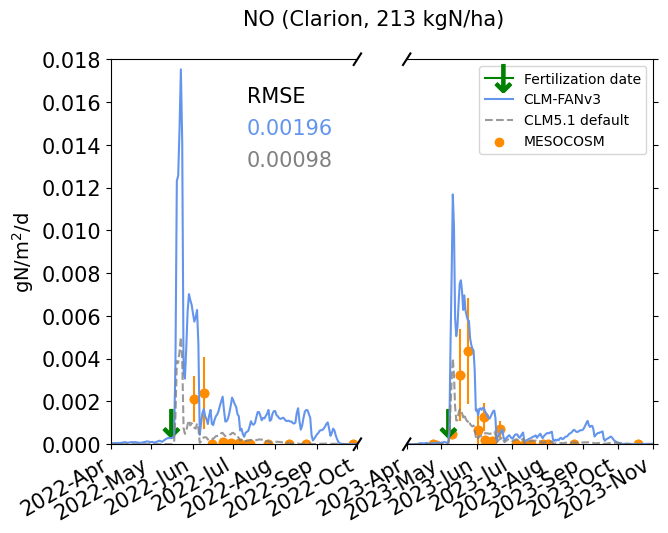

In [89]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022_cla.flatten(), no_time_2023_cla.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_cla.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.0160, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.0145, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.0130, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Clarion.time, NO_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(no_time_2022_cla, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023_cla, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2022_cla, mean_dsNO_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022_cla, mean_dsNO_cla_2022.values, yerr=std_dsNO_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023_cla, mean_dsNO_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023_cla, mean_dsNO_cla_2023.values, yerr=std_dsNO_cla_2023.values, fmt="o", color='darkorange', zorder=1)
    
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.018)
ax[1].set_ylim(0, 0.018)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("NO (Clarion, 213 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_213kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

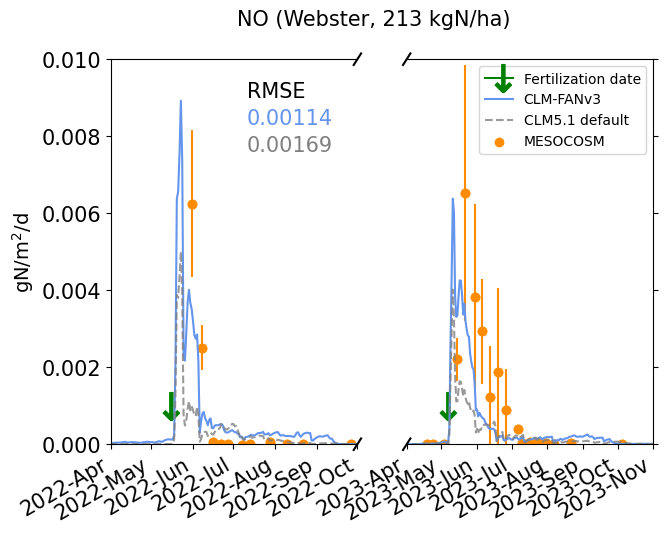

In [90]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((no_time_2022_web.flatten(), no_time_2023_web.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(NO_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)
rmse_default = cal_rmse(NO_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsNO_web.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green')
ax[1].plot(fert_date_2023- 5, 0.001, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.009, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.0083, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.0076, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(NO_Webster.time, NO_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(NO_Default.time, NO_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(no_time_2022_web, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(no_time_2023_web, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(no_time_2022_web, mean_dsNO_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(no_time_2022_web, mean_dsNO_web_2022.values, yerr=std_dsNO_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(no_time_2023_web, mean_dsNO_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(no_time_2023_web, mean_dsNO_web_2023.values, yerr=std_dsNO_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.01)
ax[1].set_ylim(0, 0.01)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("NO (Webster, 213 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/NO_213kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

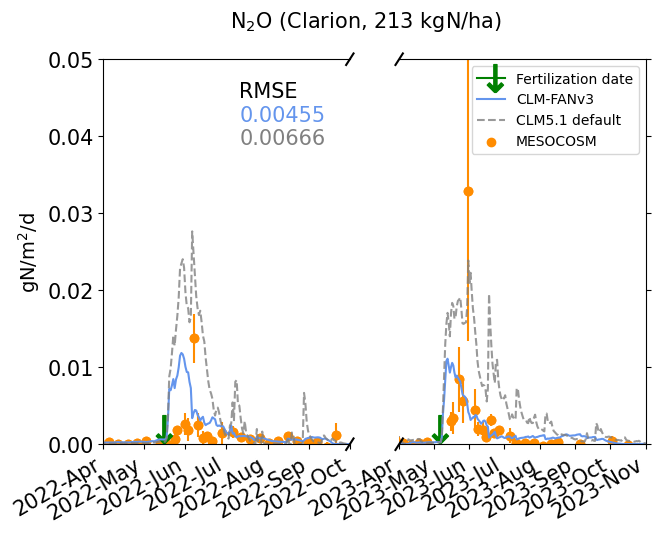

In [91]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022_cla.flatten(), n2o_time_2023_cla.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Clarion.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_cla.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.045, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.042, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.039, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Clarion.time, N2O_Clarion.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022_cla, mean_dsN2O_cla_2022.values, yerr=std_dsN2O_cla_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023_cla, mean_dsN2O_cla_2023.values, yerr=std_dsN2O_cla_2023.values, fmt="o", color='darkorange', zorder=1)
    
ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.050)
ax[1].set_ylim(0, 0.050)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Clarion, 213 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_213kgN_clarion.pdf", format='pdf', bbox_inches='tight')
plt.show()

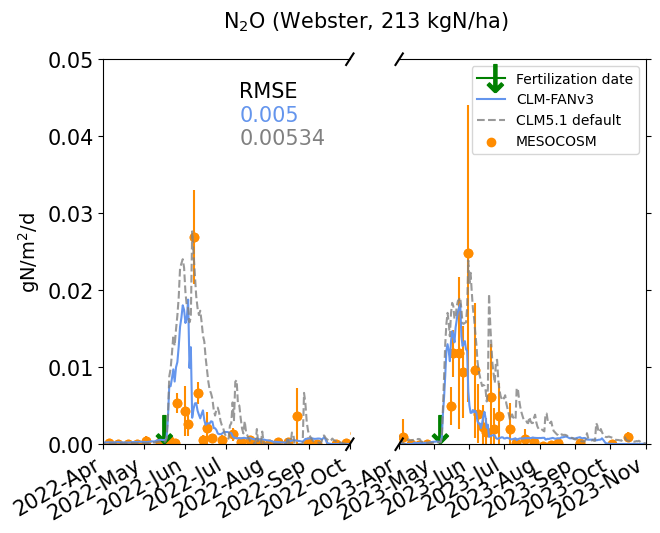

In [92]:
# RMSE Calculations for concentrations
sample_time = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in pd.DatetimeIndex(np.concatenate((n2o_time_2022_web.flatten(), n2o_time_2023_web.flatten()), axis=0))]
rmse_clmfanv3 = cal_rmse(N2O_Webster.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)
rmse_default = cal_rmse(N2O_Default.sel(time=sample_time, method='nearest').values.flatten(), mean_dsN2O_web.values)

# Graph
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7,5))

fert_date_2022 = cftime.date2num(cftime.DatetimeGregorian(2022, 5, 18, 0, 0, 0), "days since 1970-01-01")
fert_date_2023 = cftime.date2num(cftime.DatetimeGregorian(2023, 5, 8, 0, 0, 0), "days since 1970-01-01")

ax[0].plot(fert_date_2022-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green')
ax[1].plot(fert_date_2023-5, 0.002, marker=r'$\downarrow$', markersize=20, color='green', label='Fertilization date')

ax[0].text(no_time_2022_cla[6], 0.045, 'RMSE', size=15)
ax[0].text(no_time_2022_cla[6], 0.042, round(rmse_clmfanv3, 5), size=15, color='cornflowerblue')
ax[0].text(no_time_2022_cla[6], 0.039, round(rmse_default, 5), size=15, color='grey',)

ax[0].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[1].plot(N2O_Webster.time, N2O_Webster.values, label='CLM-FANv3', color='cornflowerblue', zorder=2)
ax[0].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)
ax[1].plot(N2O_Default.time, N2O_Default.values, linestyle='--', label='CLM5.1 default', color='grey', alpha=0.8, zorder=2)

ax[0].scatter(n2o_time_2022_web, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[0].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[0].scatter(n2o_time_2023_web, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[0].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[1].scatter(n2o_time_2022_web, mean_dsN2O_web_2022.values, color='darkorange', label='MESOCOSM', zorder=1)
ax[1].errorbar(n2o_time_2022_web, mean_dsN2O_web_2022.values, yerr=std_dsN2O_web_2022.values, fmt="o", color='darkorange', zorder=1)
ax[1].scatter(n2o_time_2023_web, mean_dsN2O_web_2023.values, color='darkorange', zorder=1)
ax[1].errorbar(n2o_time_2023_web, mean_dsN2O_web_2023.values, yerr=std_dsN2O_web_2023.values, fmt="o", color='darkorange', zorder=1)

ax[0].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2022, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2022, 10, 1, 0, 0, 0), "days since 1970-01-01"))
ax[1].set_xlim(cftime.date2num(cftime.DatetimeGregorian(2023, 4, 1, 0, 0, 0), "days since 1970-01-01"), 
               cftime.date2num(cftime.DatetimeGregorian(2023, 11, 1, 0, 0, 0), "days since 1970-01-01"))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 0.05)
ax[1].set_ylim(0, 0.05)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylabel("gN/m$^2$/d", size=14)
ax[1].tick_params(axis='x', labelsize=15)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].yaxis.tick_left()
#ax[0].tick_params(labelright='off')
ax[1].yaxis.tick_right()
ax[1].legend()

d = .015
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((-d, +d), (1-d, 1+d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

fig.suptitle("N$_2$O (Webster, 213 kgN/ha)", size=15)
#fig.tight_layout()
fig.savefig("finalgraphs/N2O_213kgN_webster.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [93]:
h2o_sim_daily = dsCLM_Clarion['WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
h2o_sim_daily = h2o_sim_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
nh4_Clarion_daily = dsCLM_Clarion['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Clarion_daily = nh4_Clarion_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
no3_Clarion_daily = dsCLM_Clarion['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Clarion_daily = no3_Clarion_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit = dsCLM_Clarion['F_NIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit = f_nit.sel(levdcmp=[0.09]).mean(dim='levdcmp')
f_denit = dsCLM_Clarion['F_DENIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_denit = f_denit.sel(levdcmp=[0.09]).mean(dim='levdcmp')

h2o_sim_daily_default = dsCLM_Default['WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
h2o_sim_daily_default = h2o_sim_daily_default.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
nh4_Default_daily = dsCLM_Default['SMIN_NH4_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
nh4_Default_daily = nh4_Default_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
no3_Default_daily = dsCLM_Default['SMIN_NO3_vr'].sel(levsoi=[0.01, 0.04, 0.09]).mean(dim='levsoi')
no3_Default_daily = no3_Default_daily.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit_default = dsCLM_Default['F_NIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_nit_default = f_nit_default.sel(levdcmp=[0.09]).mean(dim='levdcmp')
f_denit_default = dsCLM_Default['F_DENIT_vr'].resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
f_denit_default = f_denit_default.sel(levdcmp=[0.09]).mean(dim='levdcmp')

x_data = np.ravel(h2o_sim_daily.values)
y_nitdata = np.ravel(f_nit.values)
y_denitdata = np.ravel(f_denit.values)

x_data_default = np.ravel(h2o_sim_daily_default.values)
y_nitdata_default = np.ravel(f_nit_default.values)
y_denitdata_default = np.ravel(f_denit_default.values)

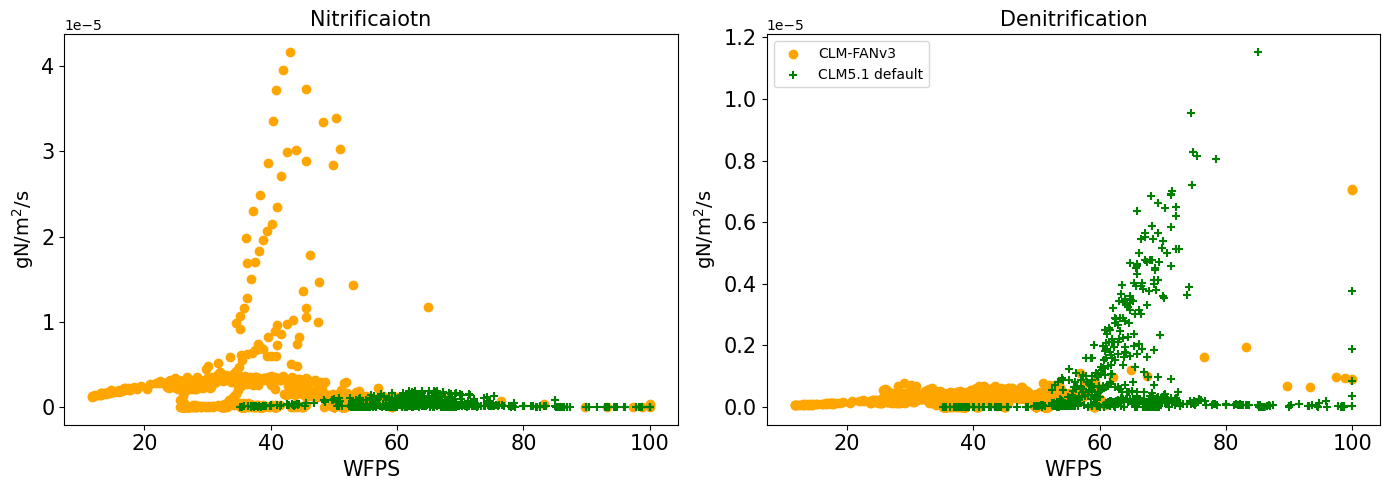

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(x_data, y_nitdata, color='orange', zorder=1)
ax[1].scatter(x_data, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)
#ax[0].plot(plot_x, gaussian(plot_x, *popt_nit), color='red', zorder=2)
#ax[1].plot(plot_x, gaussian(plot_x, *popt_denit), color='red', zorder=2)

ax[0].scatter(x_data_default, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(x_data_default, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)
#ax[0].plot(plot_x, gaussian(plot_x, *popt_nit_default), color='blue', zorder=2)
#ax[1].plot(plot_x, gaussian(plot_x, *popt_denit_default), color='blue', zorder=2)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("WFPS", size=15)
ax[1].set_xlabel("WFPS", size=15)
ax[0].set_ylabel("gN/m$^2$/s", size=14)
ax[1].set_ylabel("gN/m$^2$/s", size=14)
#ax[0].set_ylim(0, 2e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()

fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_WFPS.pdf", format='pdf')

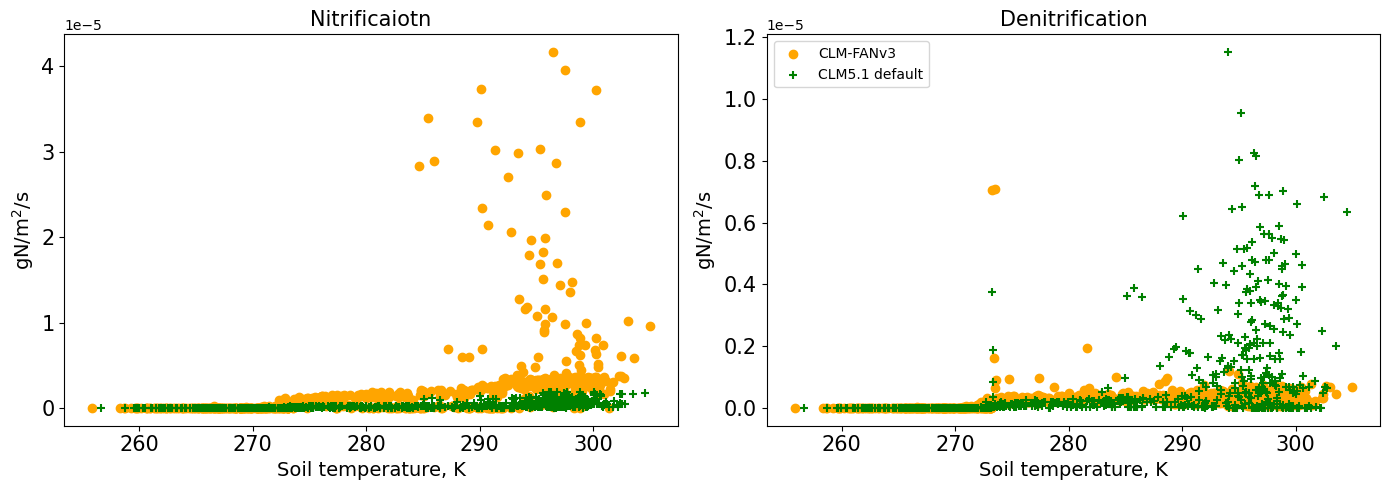

In [95]:
tem_sim = dsCLM_Clarion['TSOI_10CM']
tem_sim = tem_sim.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
tem_sim_default = dsCLM_Default['TSOI_10CM']
tem_sim_default = tem_sim_default.resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(tem_sim.values, y_nitdata, color='orange', zorder=1)
ax[1].scatter(tem_sim.values, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)

ax[0].scatter(tem_sim_default.values, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(tem_sim_default.values, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("Soil temperature, K", size=14)
ax[1].set_xlabel("Soil temperature, K", size=14)
ax[0].set_ylabel("gN/m$^2$/s", size=14)
ax[1].set_ylabel("gN/m$^2$/s", size=14)
#ax[0].set_ylim(0, 2e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()
fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_Temperature.pdf", format='pdf')

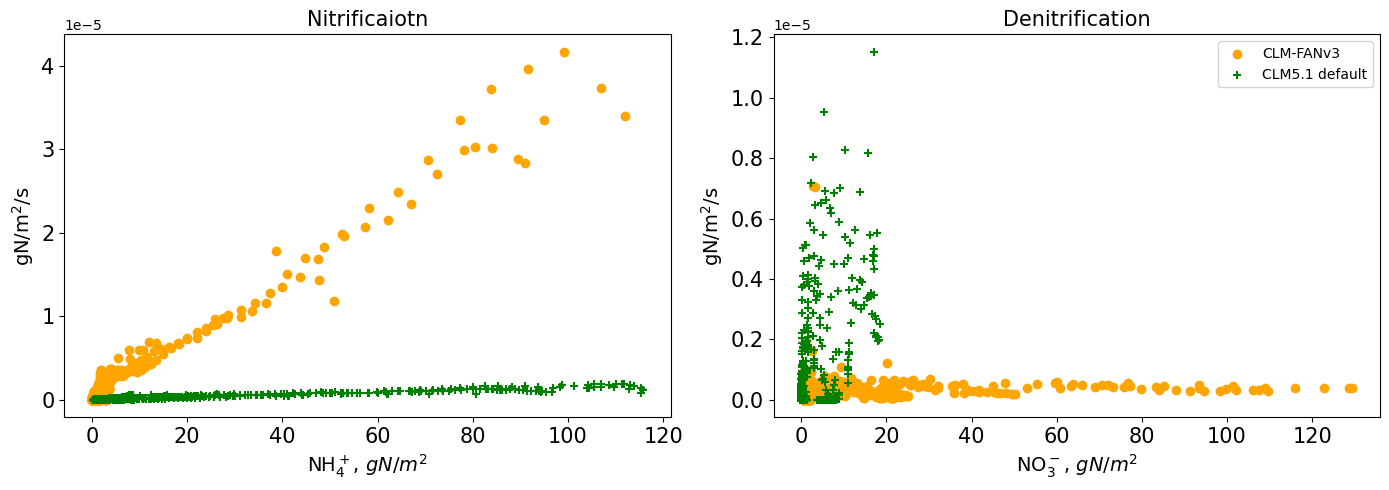

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(nh4_Clarion_daily.values, y_nitdata, color='orange', zorder=1)
ax[1].scatter(no3_Clarion_daily.values, y_denitdata, label='CLM-FANv3', color='orange', zorder=1)

ax[0].scatter(nh4_Default_daily.values, y_nitdata_default, marker = '+',  color='green', zorder=1)
ax[1].scatter(no3_Default_daily.values, y_denitdata_default, label='CLM5.1 default',  marker = '+',  color='green', zorder=1)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Nitrificaiotn', size=15)
ax[1].set_title('Denitrification', size=15)
ax[0].set_xlabel("NH$^+_4$, $gN/m^2$", size=14)
ax[1].set_xlabel("NO$^-_3$, $gN/m^2$", size=14)
ax[0].set_ylabel("gN/m$^2$/s", size=14)
ax[1].set_ylabel("gN/m$^2$/s", size=14)
#ax[0].set_ylim(0, 1e-6)
#ax[1].set_ylim(0, 2e-6)
ax[1].legend()
fig.tight_layout()
plt.show()
fig.savefig("finalgraphs/Soilprocess_concentration.pdf", format='pdf')

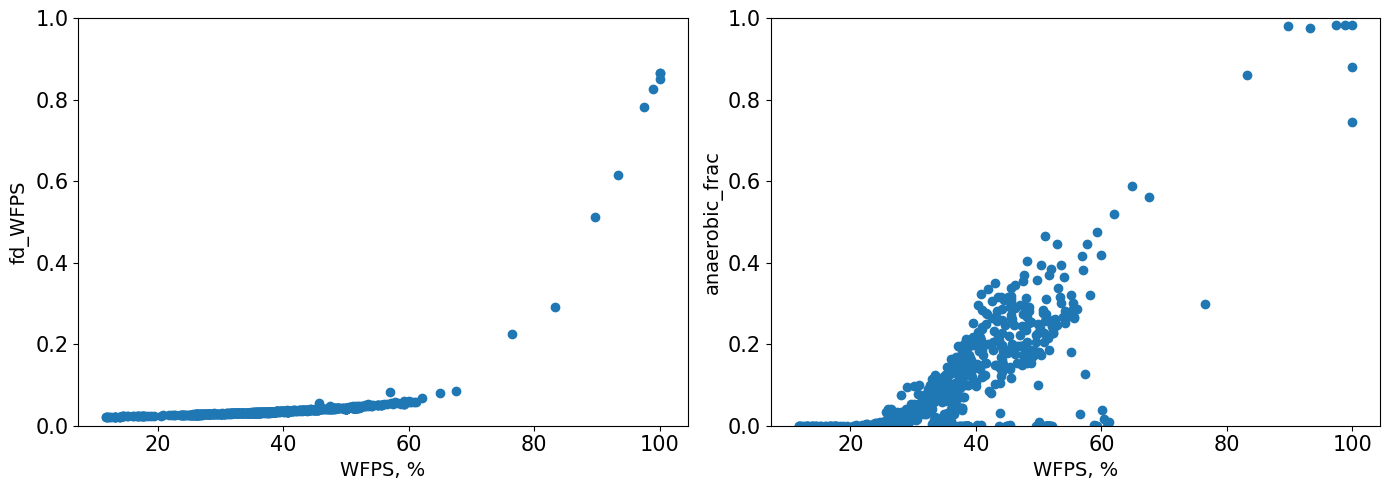

In [97]:
fdWFPS = dsCLM_Clarion['fd_WFPS'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
fdWFPS = fdWFPS .resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))
anaerobic_frac = dsCLM_Clarion['anaerobic_frac'].sel(levdcmp=[0.09]).mean(dim='levdcmp')
anaerobic_frac = anaerobic_frac .resample(time='D').mean().sel(time=slice('2022-01-01', '2024-01-01'))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(x_data, fdWFPS.values)
ax[0].set_ylim(0, 1.0)
ax[0].set_xlabel("WFPS, %", size=14)
ax[0].set_ylabel("fd_WFPS", size=14)
ax[1].scatter(x_data, anaerobic_frac.values)
ax[1].set_ylim(0, 1.0)
ax[1].set_xlabel("WFPS, %", size=14)
ax[1].set_ylabel("anaerobic_frac", size=14)

ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

fig.tight_layout()
fig.savefig("finalgraphs/WaterLimitationFunctions.pdf", format='pdf')
plt.show()

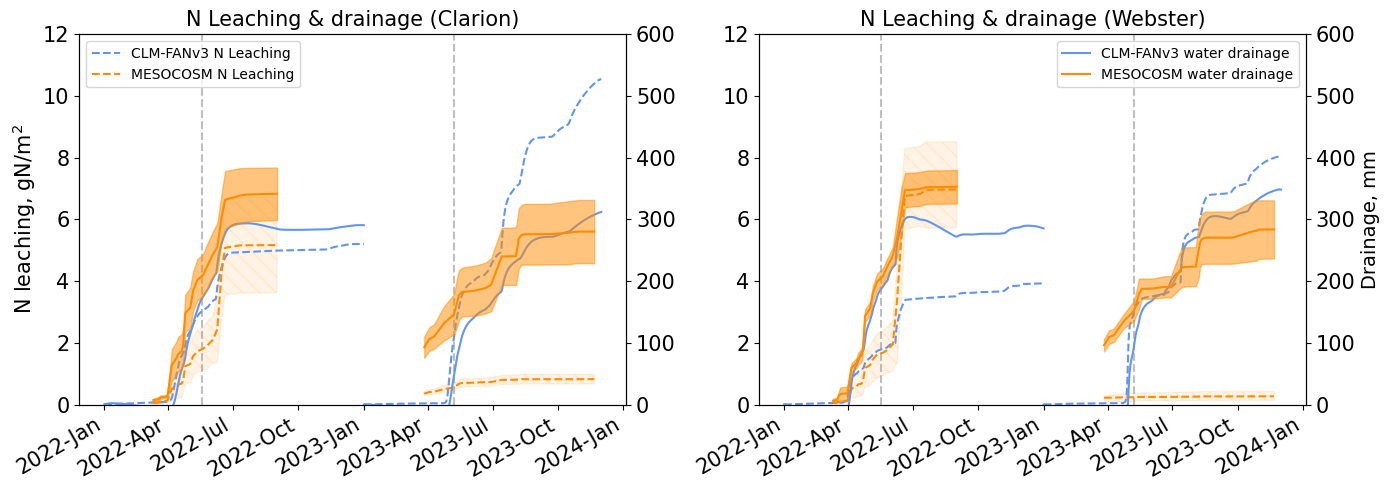

In [98]:
# Read the measuremnts
dsWater['instantaneous_drainage_nitrate_gN_m2_s'] = dsWater['NO3N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_ammonium_gN_m2_s'] = dsWater['NH4N_mg_L']/1000*dsWater['instantaneous_drainage_mm_s']
dsWater['instantaneous_drainage_nitrogen_gN_m2_s'] = dsWater['instantaneous_drainage_nitrate_gN_m2_s'] + dsWater['instantaneous_drainage_ammonium_gN_m2_s']
dsWater['cumulative_nitrogen_gN_m2'] = dsWater['cumulative_annual_inorganicN_kg_ha']/10

runoff_meso_cum.loc[runoff_meso_cum.index > "2022-01-01"]

ndra_meso_cla_mean = dsWater.loc[('Clarion', '213'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_cla_std = dsWater.loc[('Clarion', '213'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()
ndra_meso_web_mean = dsWater.loc[('Webster', '213'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').mean()
ndra_meso_web_std = dsWater.loc[('Webster', '213'), 'instantaneous_drainage_nitrogen_gN_m2_s'].groupby('date').std()

ndra_meso_cla_cum_mean = dsWater.loc[('Clarion', '213'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_cla_cum_std = dsWater.loc[('Clarion', '213'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_cla_cum_mean_2022 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index < "2023-01-01"]
ndra_meso_cla_cum_std_2022 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index < "2023-01-01"]
ndra_meso_cla_cum_mean_2023 = ndra_meso_cla_cum_mean.loc[ndra_meso_cla_cum_mean.index > "2023-01-01"]
ndra_meso_cla_cum_std_2023 = ndra_meso_cla_cum_std.loc[ndra_meso_cla_cum_std.index > "2023-01-01"]
ndra_meso_web_cum_mean = dsWater.loc[('Webster', '213'), 'cumulative_nitrogen_gN_m2'].groupby('date').mean()
ndra_meso_web_cum_std = dsWater.loc[('Webster', '213'), 'cumulative_nitrogen_gN_m2'].groupby('date').std()
ndra_meso_web_cum_mean_2022 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index < "2023-01-01"]
ndra_meso_web_cum_std_2022 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index < "2023-01-01"]
ndra_meso_web_cum_mean_2023 = ndra_meso_web_cum_mean.loc[ndra_meso_web_cum_mean.index > "2023-01-01"]
ndra_meso_web_cum_std_2023 = ndra_meso_web_cum_std.loc[ndra_meso_web_cum_std.index > "2023-01-01"]

plottime_2022 = ndra_meso_cla_cum_mean_2022.index.values
plottime_2023 = ndra_meso_cla_cum_mean_2023.index.values

# CLM simulations
Total_N_runoff_cla = dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED']
Total_N_runoff_web = dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED']
Total_N_runoff_default = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']

## hourly resolution!!
Total_N_cum_runoff_cla_2022 = (Total_N_runoff_cla.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_cla_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2022.time]
Total_N_cum_runoff_web_2022 = (Total_N_runoff_web.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_web_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2022.time]
Total_N_cum_runoff_default_2022 = (Total_N_runoff_default.sel(time="2022") * 3600).cumsum()
Total_N_cum_runoff_default_2022['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2022.time]
Total_N_cum_runoff_cla_2023 = (Total_N_runoff_cla.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_cla_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_cla_2023.time]
Total_N_cum_runoff_web_2023 = (Total_N_runoff_web.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_web_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_web_2023.time]
Total_N_cum_runoff_default_2023 = (Total_N_runoff_default.sel(time="2023") * 3600).cumsum()
Total_N_cum_runoff_default_2023['time'] = [cftime.date2num(x, units="days since 1970-01-01", calendar='gregorian') for x in Total_N_cum_runoff_default_2023.time]

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[0].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='Fertilisation begin')
ax[1].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey')

ax[0].plot(Total_N_cum_runoff_cla_2022.time, Total_N_cum_runoff_cla_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[1].plot(Total_N_cum_runoff_web_2022.time, Total_N_cum_runoff_web_2022.values, label='CLM-FANv3 N Leaching', linestyle='--', color='cornflowerblue')
ax[0].plot(Total_N_cum_runoff_cla_2023.time, Total_N_cum_runoff_cla_2023.values, color='cornflowerblue', linestyle='--')
ax[1].plot(Total_N_cum_runoff_web_2023.time, Total_N_cum_runoff_web_2023.values, color='cornflowerblue', linestyle='--')

ax[0].plot(plottime_2022, ndra_meso_cla_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[1].plot(plottime_2022, ndra_meso_web_cum_mean_2022.values, label='MESOCOSM N Leaching', linestyle='--', color='darkorange')
ax[0].fill_between(plottime_2022, ndra_meso_cla_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_cla_cum_mean_2022.values-ndra_meso_cla_cum_std_2022.values, hatch='\\\\', alpha=0.1, color='darkorange')
ax[1].fill_between(plottime_2022, ndra_meso_web_cum_mean_2022.values+ndra_meso_cla_cum_std_2022.values, ndra_meso_web_cum_mean_2022.values-ndra_meso_web_cum_std_2022.values, hatch='\\\\', alpha=0.1, color='darkorange')
ax[0].plot(plottime_2023, ndra_meso_cla_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[1].plot(plottime_2023, ndra_meso_web_cum_mean_2023.values, linestyle='--', color='darkorange')
ax[0].fill_between(plottime_2023, ndra_meso_cla_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_cla_cum_mean_2023.values-ndra_meso_cla_cum_std_2023.values, hatch='\\\\', alpha=0.1, color='darkorange')
ax[1].fill_between(plottime_2023, ndra_meso_web_cum_mean_2023.values+ndra_meso_cla_cum_std_2023.values, ndra_meso_web_cum_mean_2023.values-ndra_meso_web_cum_std_2023.values, hatch='\\\\', alpha=0.1, color='darkorange')

# add the total water drainge in here.
ax1 = ax[0].twinx()
ax1.plot(runoff_sim_2022_cum.time, runoff_sim_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax1.plot(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax1.fill_between(runoff_meso_2022_cum.index.values, runoff_meso_2022_cum.values+runoff_meso_2022_cum_std.values, runoff_meso_2022_cum.values - runoff_meso_2022_cum_std.values, color='darkorange', alpha=0.5)
ax1.plot(runoff_sim_2023_cum.time, runoff_sim_2023_cum.values, color='cornflowerblue', zorder=1)
ax1.plot(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values, color='darkorange', zorder=1)
ax1.fill_between(runoff_meso_2023_cum.index.values, runoff_meso_2023_cum.values+runoff_meso_2023_cum_std.values, runoff_meso_2023_cum.values - runoff_meso_2023_cum_std.values, color='darkorange', alpha=0.5)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0, 600)
ax2 = ax[1].twinx()
ax2.plot(runoff_sim_web_2022_cum.time, runoff_sim_web_2022_cum.values, color='cornflowerblue', label='CLM-FANv3 water drainage', zorder=1)
ax2.plot(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values, color='darkorange', label='MESOCOSM water drainage', zorder=1)
ax2.fill_between(runoff_meso_web_2022_cum.index.values, runoff_meso_web_2022_cum.values+runoff_meso_web_2022_cum_std.values, runoff_meso_web_2022_cum.values - runoff_meso_web_2022_cum_std.values, color='darkorange', alpha=0.5)
ax2.plot(runoff_sim_web_2023_cum.time, runoff_sim_web_2023_cum.values, color='cornflowerblue', zorder=1)
ax2.plot(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values, color='darkorange', zorder=1)
ax2.fill_between(runoff_meso_web_2023_cum.index.values, runoff_meso_web_2023_cum.values+runoff_meso_web_2023_cum_std.values, runoff_meso_web_2023_cum.values - runoff_meso_web_2023_cum_std.values, color='darkorange', alpha=0.5)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(loc='upper right')
ax2.set_ylabel('Drainage, mm', size=14)
ax2.set_ylim(0, 600)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax[0].set_ylim(0, 12)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='upper left')

ax[1].set_ylim(0, 1.6)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim(0, 12)
ax[0].set_ylabel('N leaching, gN/m$^2$', size=15)
ax[0].set_title('N Leaching & drainage (Clarion)', size=15)
ax[1].set_title('N Leaching & drainage (Webster)', size=15)
ax[0].legend(loc='upper left')
fig.tight_layout()
fig.savefig("finalgraphs/DrainageAndLeaching213kg.pdf", format='pdf')
plt.show()

In [99]:
a = (Total_N_cum_runoff_cla_2022.values[-1] + Total_N_cum_runoff_web_2022.values[-1])/(runoff_sim_2022_cum.values[-1] + runoff_sim_web_2022_cum.values[-1])
b = (Total_N_cum_runoff_cla_2023.values[-1] + Total_N_cum_runoff_web_2023.values[-1])/(runoff_sim_2023_cum.values[-1] + runoff_sim_web_2023_cum.values[-1])

c = (ndra_meso_cla_cum_mean_2022.values[-1] + ndra_meso_web_cum_mean_2022.values[-1])/(runoff_meso_2022_cum.values[-1] + runoff_meso_web_2022_cum.values[-1])
d = (ndra_meso_cla_cum_mean_2023.values[-1] + ndra_meso_web_cum_mean_2023.values[-1])/(runoff_meso_2023_cum.values[-1] + runoff_meso_web_2023_cum.values[-1])

print(a, b, c, d)
print(a/c, b/d)

[0.01586076] [0.0281345] 0.017478352009150683 0.001926449348802395
[0.9074518] [14.604331]


/glade/derecho/scratch/jinmuluo/tmp/ipykernel_228656/3385827425.py:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()


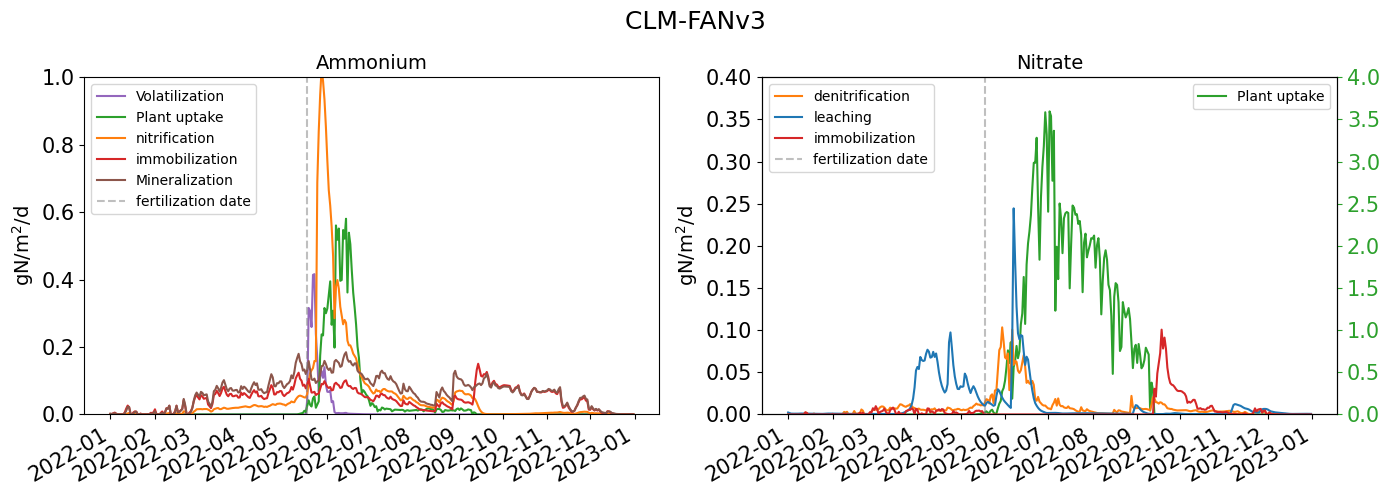

In [100]:
vola_nh4 = (dsCLM_Clarion['NH3_TOTAL'] + dsCLM_Webster['NH3_TOTAL'])/2
vola_nh4 = vola_nh4.sel(time='2022').resample(time='D').mean()
nh4_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'])/2
nh4_plant = nh4_plant.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
no3_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'])/2
no3_plant = no3_plant.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_nh4 = (dsCLM_Webster['ACTUAL_IMMOB_NH4'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2'])/2
immob_nh4 = immob_nh4.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_no3 = (dsCLM_Webster['ACTUAL_IMMOB_NO3'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2'])
immob_no3 = immob_no3.sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
Total_N_runoff = (dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED'] 
            + dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED'])/2
Total_N_runoff = Total_N_runoff.sel(time='2022').resample(time='D').mean()
nit = (dsCLM_Webster['F_NIT'] + dsCLM_Clarion['F_NIT'])/2
nit = nit.sel(time='2022').resample(time='D').mean()
denit = (dsCLM_Webster['F_DENIT'] + dsCLM_Clarion['F_DENIT'])/2
denit = denit.sel(time='2022').resample(time='D').mean()
gross_nmin = (dsCLM_Webster['GROSS_NMIN'] + dsCLM_Clarion['GROSS_NMIN'])/2
gross_nmin = gross_nmin.sel(time='2022').resample(time='D').mean()
plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()

# unit gN/m2/s to gN/m2/day
to_perday = 24*3600

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='Volatilization', color='#9467bd')
ax[0].plot(plot_time, nh4_plant.values*to_perday, label='Plant uptake', color='#2ca02c')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='#ff7f0e')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='#d62728')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='#8c564b')
ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 1.0)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[0].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

ax1 = ax[1].twinx()
ax1.plot(plot_time, no3_plant.values*to_perday, label='Plant uptake', color='#2ca02c')
ax1.set_ylim(0, 4)
ax1.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax1.legend(loc='upper right')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='#ff7f0e')
ax[1].plot(plot_time, Total_N_runoff.values*to_perday, label='leaching', color='#1f77b4')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='#d62728')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/m$^2$/d', size=14)
ax[1].set_ylim(0, 0.4)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[1].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')
fig.suptitle(' CLM-FANv3 ', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLMFANv3Nitrogenflows213KgN2022.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_228656/3919592496.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()


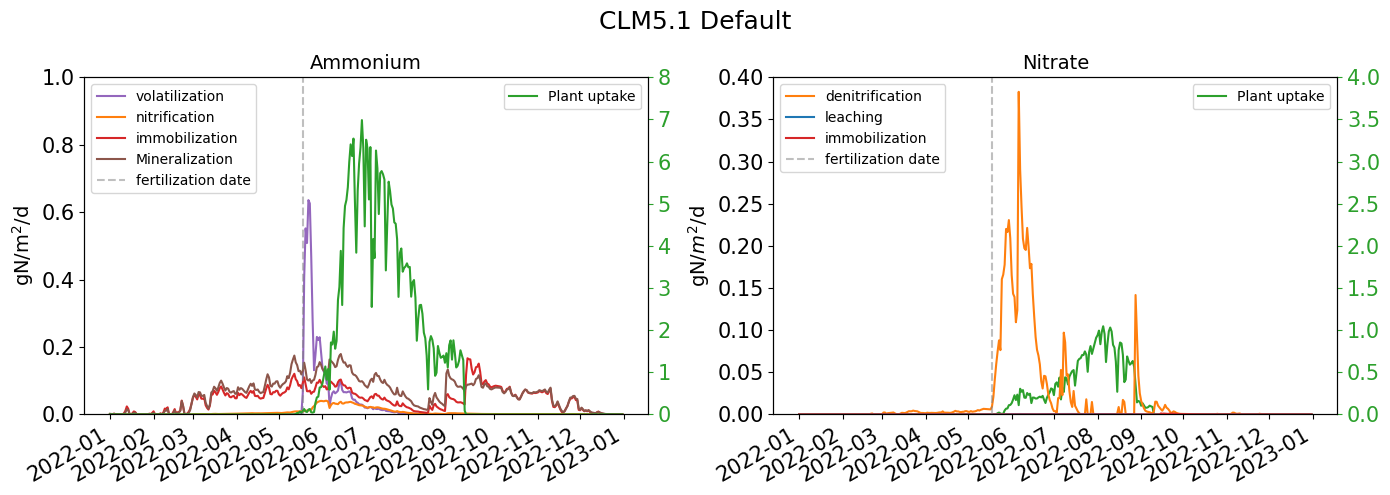

In [101]:
vola_nh4 = dsCLM_Default['NH3_TOTAL'].sel(time='2022').resample(time='D').mean()
nh4_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
no3_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_nh4 = (dsCLM_Default['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
immob_no3 = (dsCLM_Default['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2022').resample(time='D').mean()
Total_N_runoff_web = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']
Total_N_runoff_web = Total_N_runoff_web.sel(time='2022').resample(time='D').mean()
nit = dsCLM_Default['F_NIT'].sel(time='2022').resample(time='D').mean()
denit = dsCLM_Default['F_DENIT'].sel(time='2022').resample(time='D').mean()
gross_nmin = dsCLM_Default['GROSS_NMIN'].sel(time='2022').resample(time='D').mean()
plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax1 = ax[0].twinx()
ax1.plot(plot_time, nh4_plant_web.values*to_perday, label='Plant uptake', color='#2ca02c')
ax1.set_ylim(0, 8)
ax1.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax1.legend(loc='upper right')
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='volatilization', color='#9467bd')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='#ff7f0e')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='#d62728')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='#8c564b')
ax[0].axvline(x=fert_date_2022, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 1.0)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[0].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

ax2 = ax[1].twinx()
ax2.plot(plot_time, no3_plant_web.values*to_perday, label='Plant uptake', color='#2ca02c')
ax2.set_ylim(0, 4)
ax2.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax2.legend(loc='upper right')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='#ff7f0e')
ax[1].plot(plot_time, Total_N_runoff_web.values*to_perday, label='leaching', color='#1f77b4')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='#d62728')
ax[1].axvline(x=fert_date_2022, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/$m^2$/d', size=14)
ax[1].set_ylim(0, 0.4)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[1].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

fig.suptitle('CLM5.1 Default', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLM5.1DefaultNitrogenflows213KgN2022.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_228656/2182021558.py:20: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()


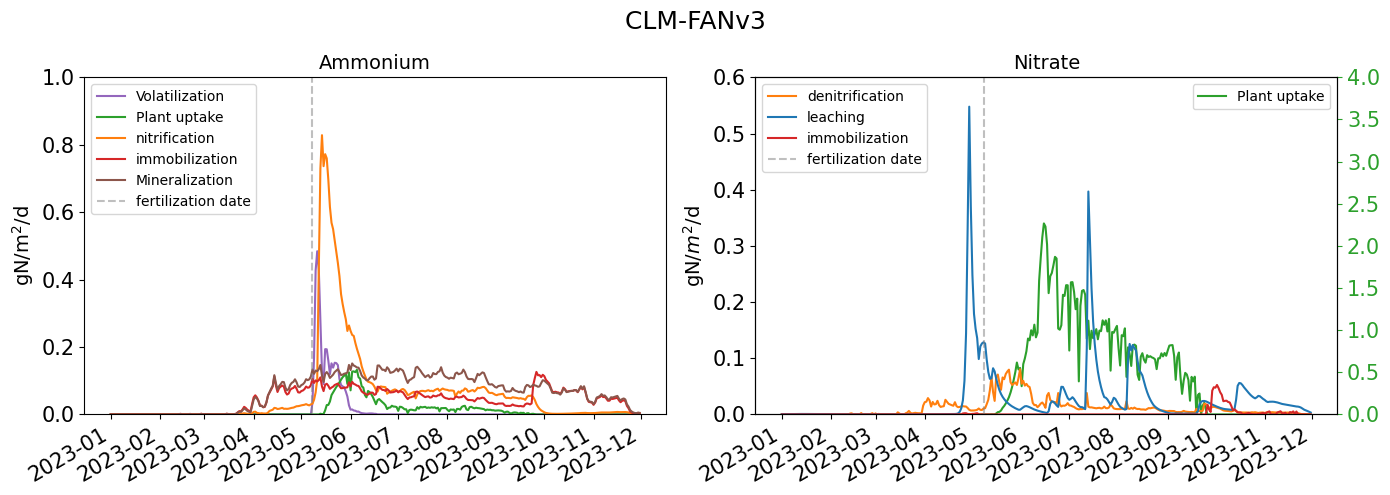

In [102]:
vola_nh4 = (dsCLM_Clarion['NH3_TOTAL'] + dsCLM_Webster['NH3_TOTAL'])/2
vola_nh4 = vola_nh4.sel(time='2023').resample(time='D').mean()
nh4_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NH4'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NH4'])/2
nh4_plant = nh4_plant.sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
no3_plant = (dsCLM_Webster['SMINN_TO_PLANT_FUN_NO3'] + dsCLM_Clarion['SMINN_TO_PLANT_FUN_NO3'])/2
no3_plant = no3_plant.sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
immob_nh4 = (dsCLM_Webster['ACTUAL_IMMOB_NH4'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2'])/2
immob_nh4 = immob_nh4.sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
immob_no3 = (dsCLM_Webster['ACTUAL_IMMOB_NO3'] * dsCLM_Webster['depth2'] + dsCLM_Clarion['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2'])
immob_no3 = immob_no3.sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
Total_N_runoff = (dsCLM_Webster["MANURE_NITRATE_RUNOFF"] + dsCLM_Webster['FERT_NITRATE_RUNOFF'] + dsCLM_Webster['SMIN_NO3_RUNOFF'] + dsCLM_Webster['SMIN_NO3_LEACHED'] 
            + dsCLM_Clarion["MANURE_NITRATE_RUNOFF"] + dsCLM_Clarion['FERT_NITRATE_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_RUNOFF'] + dsCLM_Clarion['SMIN_NO3_LEACHED'])/2
Total_N_runoff = Total_N_runoff.sel(time='2023').resample(time='D').mean()
nit = (dsCLM_Webster['F_NIT'] + dsCLM_Clarion['F_NIT'])/2
nit = nit.sel(time='2023').resample(time='D').mean()
denit = (dsCLM_Webster['F_DENIT'] + dsCLM_Clarion['F_DENIT'])/2
denit = denit.sel(time='2023').resample(time='D').mean()
gross_nmin = (dsCLM_Webster['GROSS_NMIN'] + dsCLM_Clarion['GROSS_NMIN'])/2
gross_nmin = gross_nmin.sel(time='2023').resample(time='D').mean()
plot_time = Total_N_runoff.indexes['time'].to_datetimeindex()

# unit gN/m2/s to gN/m2/day
to_perday = 24*3600

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='Volatilization', color='#9467bd')
ax[0].plot(plot_time, nh4_plant.values*to_perday, label='Plant uptake', color='#2ca02c')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='#ff7f0e')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='#d62728')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='#8c564b')
ax[0].axvline(x=fert_date_2023, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 1.0)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[0].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

ax1 = ax[1].twinx()
ax1.plot(plot_time, no3_plant.values*to_perday, label='Plant uptake', color='#2ca02c')
ax1.set_ylim(0, 4)
ax1.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax1.legend(loc='upper right')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='#ff7f0e')
ax[1].plot(plot_time, Total_N_runoff.values*to_perday, label='leaching', color='#1f77b4')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='#d62728')
ax[1].axvline(x=fert_date_2023, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/$m^2$/d', size=14)
ax[1].set_ylim(0, 0.6)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[1].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')
fig.suptitle(' CLM-FANv3 ', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLMFANv3Nitrogenflows213KgN2023.pdf", format='pdf')
plt.show()

/glade/derecho/scratch/jinmuluo/tmp/ipykernel_228656/803899078.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()


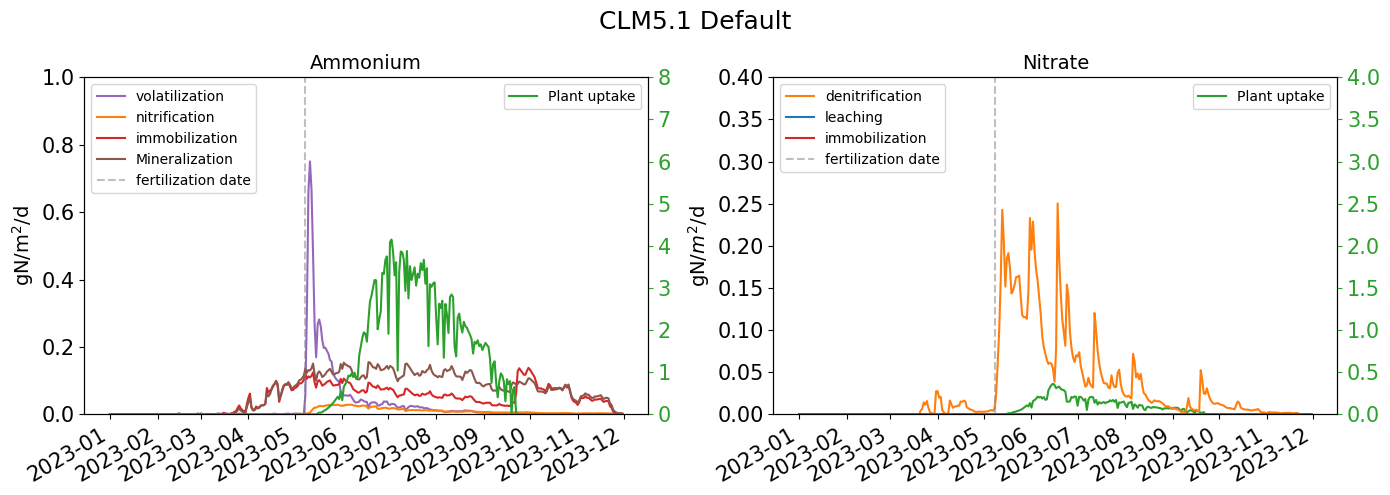

In [103]:
vola_nh4 = dsCLM_Default['NH3_TOTAL'].sel(time='2023').resample(time='D').mean()
nh4_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NH4'].sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
no3_plant_web = dsCLM_Default['SMINN_TO_PLANT_FUN_NO3'].sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
immob_nh4 = (dsCLM_Default['ACTUAL_IMMOB_NH4'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
immob_no3 = (dsCLM_Default['ACTUAL_IMMOB_NO3'] * dsCLM_Clarion['depth2']).sum(dim='levdcmp').sel(time='2023').resample(time='D').mean()
Total_N_runoff_web = dsCLM_Default["MANURE_NITRATE_RUNOFF"] + dsCLM_Default['FERT_NITRATE_RUNOFF'] + dsCLM_Default['SMIN_NO3_RUNOFF'] + dsCLM_Default['SMIN_NO3_LEACHED']
Total_N_runoff_web = Total_N_runoff_web.sel(time='2023').resample(time='D').mean()
nit = dsCLM_Default['F_NIT'].sel(time='2023').resample(time='D').mean()
denit = dsCLM_Default['F_DENIT'].sel(time='2023').resample(time='D').mean()
gross_nmin = dsCLM_Default['GROSS_NMIN'].sel(time='2023').resample(time='D').mean()
plot_time = Total_N_runoff_web.indexes['time'].to_datetimeindex()

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax1 = ax[0].twinx()
ax1.plot(plot_time, nh4_plant_web.values*to_perday, label='Plant uptake', color='#2ca02c')
ax1.set_ylim(0, 8)
ax1.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax1.legend(loc='upper right')
ax[0].plot(plot_time, vola_nh4.values*to_perday, label='volatilization', color='#9467bd')
ax[0].plot(plot_time, nit.values*to_perday, label='nitrification', color='#ff7f0e')
ax[0].plot(plot_time, immob_nh4.values*to_perday, label='immobilization', color='#d62728')
ax[0].plot(plot_time, gross_nmin.values*to_perday, label='Mineralization', color='#8c564b')
ax[0].axvline(x=fert_date_2023, ymin=0, ymax=100,ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[0].set_ylabel('gN/m$^2$/d', size=14)
ax[0].set_ylim(0, 1.0)
ax[0].legend(loc='upper left')
ax[0].set_title('Ammonium', size=14)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[0].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

ax2 = ax[1].twinx()
ax2.plot(plot_time, no3_plant_web.values*to_perday, label='Plant uptake', color='#2ca02c')
ax2.set_ylim(0, 4)
ax2.tick_params(axis='y', colors='#2ca02c', labelsize=15)
ax2.legend(loc='upper right')
ax[1].tick_params(axis='y', labelsize=15)
ax[1].plot(plot_time, denit.values*to_perday, label='denitrification', color='#ff7f0e')
ax[1].plot(plot_time, Total_N_runoff_web.values*to_perday, label='leaching', color='#1f77b4')
ax[1].plot(plot_time, immob_no3.values*to_perday, label='immobilization', color='#d62728')
ax[1].axvline(x=fert_date_2023, ymin=0, ymax=100, ls='--', alpha=0.5, color='grey', label='fertilization date')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('gN/$m^2$/d', size=14)
ax[1].set_ylim(0, 0.4)
ax[1].set_title('Nitrate', size=14)
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13)))
for label in ax[1].get_xticklabels(which='both'):
    label.set(rotation=30, horizontalalignment='right')

fig.suptitle('CLM5.1 Default', fontsize=18)
fig.tight_layout()
fig.savefig("finalgraphs/CLM5.1DefaultNitrogenflows213KgN2023.pdf", format='pdf')
plt.show()